In [1]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 26.8 MB/s eta 0:00:0000:01


In [2]:
!git clone --branch baselineCe https://github.com/Graph-Classification-Noisy-Label/hackaton.git

Cloning into 'hackaton'...
remote: Enumerating objects: 81, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 81 (delta 1), reused 1 (delta 1), pack-reused 77 (from 1)
Receiving objects: 100% (81/81), 105.83 MiB | 46.83 MiB/s, done.
Resolving deltas: 100% (13/13), done.


In [3]:
%cd hackaton/

/kaggle/working/hackaton


In [4]:
# !gdown --folder https://drive.google.com/drive/folders/1Z-1JkPJ6q4C6jX4brvq1VRbJH5RPUCAk -O datasets
!gdown --folder https://drive.google.com/drive/folders/1vZVCPbux6brOnkfqil9CIj8a4iHlUwHV -O datasets

Retrieving folder contents
Retrieving folder 1oOxZgzm6GFEMqR9CE84syVkS3zDYm14G A
Processing file 1KK7CrI83nsEBG4ft_BgBeB3FPfrtqfs6 test.json.gz
Processing file 1HLDsT0NSttc9mI8obV4xsMdz0dXYsHg5 train.json.gz
Retrieving folder 1fZMQBg3Zkd9k8D3ExvMHLPDZ-A4Uldz3 B
Processing file 1nYi_Wj0c7FwMt1kNhenS5IOlfOAONUUO test.json.gz
Processing file 14bnCHnrPdLQ9fmLbnoi3GKFrwfHy2JPN train.json.gz
Retrieving folder 16I0ny5c6cuYncYTXNLro1i_bqUsJNeSc C
Processing file 1HftG39UqLt5Zu7sYHcDl8GN6PqZV7i_M test.json.gz
Processing file 1Q_QHBljWUS4ERBXbiZGQych-JKktRiMx train.json.gz
Retrieving folder 1ToGahOt-r0Llmo6Bwq6WHnzq31Y6ixwm D
Processing file 1yPgOhqJrmqP8eYfwCKgqdTz_blPZMzvj test.json.gz
Processing file 1oZy8-zEj8heFGWAJ2loD6adqpdARVMlA train.json.gz
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=1KK7CrI83nsEBG4ft_BgBeB3FPfrtqfs6
From (redirected): https://drive.google.com/uc?

In [5]:
!ls -lh datasets

total 16K
drwxr-xr-x 2 root root 4.0K May 26 20:03 A
drwxr-xr-x 2 root root 4.0K May 26 20:03 B
drwxr-xr-x 2 root root 4.0K May 26 20:04 C
drwxr-xr-x 2 root root 4.0K May 26 20:04 D


In [6]:
!ls -a

.   checkpoints  .git  main.py	  requirements.txt  submission
..  datasets	 logs  README.md  src		    submission.gz


In [7]:
import os
import torch
import pandas as pd
import matplotlib.pyplot as plt
import logging
from tqdm import tqdm
from torch_geometric.loader import DataLoader
from torch.utils.data import random_split
# Load utility functions from cloned repository
# from src.loadData import GraphDataset
from src.utils import set_seed
from src.models import GNN
import argparse

# Set the random seed
set_seed()


In [8]:
def add_zeros(data):
    data.x = torch.zeros(data.num_nodes, dtype=torch.long)
    return data

In [9]:
def train(data_loader, model, optimizer, criterion, device, save_checkpoints, checkpoint_path, current_epoch):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for data in tqdm(data_loader, desc="Iterating training graphs", unit="batch"):
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        pred = output.argmax(dim=1)
        correct += (pred == data.y).sum().item()
        total += data.y.size(0)

    # Save checkpoints if required
    if save_checkpoints:
        checkpoint_file = f"{checkpoint_path}_epoch_{current_epoch + 1}.pth"
        torch.save(model.state_dict(), checkpoint_file)
        print(f"Checkpoint saved at {checkpoint_file}")

    return total_loss / len(data_loader),  correct / total

In [10]:
def evaluate(data_loader, model, device, criterion=None, calculate_accuracy=False):
    model.eval()
    correct = 0
    total = 0
    predictions = []
    total_loss = 0
    
    # criterion = torch.nn.CrossEntropyLoss()
    with torch.no_grad():
        for data in tqdm(data_loader, desc="Iterating eval graphs", unit="batch"):
            data = data.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            
            if calculate_accuracy:
                correct += (pred == data.y).sum().item()
                total += data.y.size(0)
                total_loss += criterion(output, data.y).item()

            else:
                predictions.extend(pred.cpu().numpy())
    
    if calculate_accuracy:
        accuracy = correct / total
        return  total_loss / len(data_loader), accuracy
        
    return predictions

In [11]:
def save_predictions(predictions, test_path):
    script_dir = os.getcwd() 
    submission_folder = os.path.join(script_dir, "submission")
    test_dir_name = os.path.basename(os.path.dirname(test_path))
    
    os.makedirs(submission_folder, exist_ok=True)
    
    output_csv_path = os.path.join(submission_folder, f"testset_{test_dir_name}.csv")
    
    test_graph_ids = list(range(len(predictions)))
    output_df = pd.DataFrame({
        "id": test_graph_ids,
        "pred": predictions
    })
    
    output_df.to_csv(output_csv_path, index=False)
    print(f"Predictions saved to {output_csv_path}")

In [12]:
def plot_training_progress(train_losses, train_accuracies, output_dir):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 6))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Training Loss", color='blue')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss per Epoch')

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label="Training Accuracy", color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy per Epoch')

    plt.show()

    # # Save plots in the current directory
    # os.makedirs(output_dir, exist_ok=True)
    # plt.tight_layout()
    # plt.savefig(os.path.join(output_dir, "training_progress.png"))
    # plt.close()

In [13]:
def get_user_input(prompt, default=None, required=False, type_cast=str):

    while True:
        user_input = input(f"{prompt} [{default}]: ")
        
        if user_input == "" and required:
            print("This field is required. Please enter a value.")
            continue
        
        if user_input == "" and default is not None:
            return default
        
        if user_input == "" and not required:
            return None
        
        try:
            return type_cast(user_input)
        except ValueError:
            print(f"Invalid input. Please enter a valid {type_cast.__name__}.")

In [14]:
def get_arguments():
    args = {}
    args['train_path'] = get_user_input("Path to the training dataset (optional)")
    args['test_path'] = get_user_input("Path to the test dataset", required=True)
    args['num_checkpoints'] = get_user_input("Number of checkpoints to save during training", type_cast=int)
    args['device'] = get_user_input("Which GPU to use if any", default=1, type_cast=int)
    args['gnn'] = get_user_input("GNN type (gin, gin-virtual, gcn, gcn-virtual)", default='gin')
    args['drop_ratio'] = get_user_input("Dropout ratio", default=0.0, type_cast=float)
    args['num_layer'] = get_user_input("Number of GNN message passing layers", default=5, type_cast=int)
    args['emb_dim'] = get_user_input("Dimensionality of hidden units in GNNs", default=300, type_cast=int)
    args['batch_size'] = get_user_input("Input batch size for training", default=32, type_cast=int)
    args['epochs'] = get_user_input("Number of epochs to train", default=10, type_cast=int)
    args['baseline_mode'] = get_user_input("Baseline mode: 1 (CE), 2 (Noisy CE)", default=1, type_cast=int)
    args['noise_prob'] = get_user_input("Noise probability p (used if baseline_mode=2)", default=0.2, type_cast=float)

    
    return argparse.Namespace(**args)


In [15]:
def populate_args(args):
    print("Arguments received:")
    for key, value in vars(args).items():
        print(f"{key}: {value}")

# args = get_arguments()

args = {}
args['train_path'] = "datasets/D/train.json.gz"
args['test_path'] = "datasets/D/test.json.gz"
args['num_checkpoints'] = 1
args['device'] = 1
args['gnn'] = 'gin'
args['drop_ratio'] = 0.0
args['num_layer'] = 5
args['emb_dim'] = 300
args['batch_size'] = 32
args['epochs'] = 30
args['baseline_mode'] = 2
args['noise_prob'] = 0.2

args = argparse.Namespace(**args)
populate_args(args)


Arguments received:
train_path: datasets/D/train.json.gz
test_path: datasets/D/test.json.gz
num_checkpoints: 1
device: 1
gnn: gin
drop_ratio: 0.0
num_layer: 5
emb_dim: 300
batch_size: 32
epochs: 30
baseline_mode: 2
noise_prob: 0.2


In [41]:
class NoisyCrossEntropyLoss(torch.nn.Module):
    def __init__(self, p_noisy):
        super().__init__()
        self.p = p_noisy
        self.ce = torch.nn.CrossEntropyLoss(reduction='none')

    def forward(self, logits, targets):
        losses = self.ce(logits, targets)
        weights = (1 - self.p) + self.p * (1 - torch.nn.functional.one_hot(targets, num_classes=logits.size(1)).float().sum(dim=1))
        return (losses * weights).mean()

In [16]:
script_dir = os.getcwd() 
# device = torch.device(f"cuda:{args.device}" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_checkpoints = args.num_checkpoints if args.num_checkpoints else 3
    
# if args.gnn == 'gin':
#     model = GNN(gnn_type='gin', num_class=6, num_layer=args.num_layer, emb_dim=args.emb_dim, drop_ratio=args.drop_ratio, virtual_node=False).to(device)
# elif args.gnn == 'gin-virtual':
#     model = GNN(gnn_type='gin', num_class=6, num_layer=args.num_layer, emb_dim=args.emb_dim, drop_ratio=args.drop_ratio, virtual_node=True).to(device)
# elif args.gnn == 'gcn':
#     model = GNN(gnn_type='gcn', num_class=6, num_layer=args.num_layer, emb_dim=args.emb_dim, drop_ratio=args.drop_ratio, virtual_node=False).to(device)
# elif args.gnn == 'gcn-virtual':
#     model = GNN(gnn_type='gcn', num_class=6, num_layer=args.num_layer, emb_dim=args.emb_dim, drop_ratio=args.drop_ratio, virtual_node=True).to(device)
# else:
#     raise ValueError('Invalid GNN type')
    
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# criterion = torch.nn.CrossEntropyLoss()
# if args.baseline_mode == 2:
#     criterion = NoisyCrossEntropyLoss(args.noise_prob)
# else:
#     criterion = torch.nn.CrossEntropyLoss()

In [17]:
test_dir_name = os.path.basename(os.path.dirname(args.test_path))
logs_folder = os.path.join(script_dir, "logs", test_dir_name)
log_file = os.path.join(logs_folder, "training.log")
os.makedirs(os.path.dirname(log_file), exist_ok=True)
logging.basicConfig(filename=log_file, level=logging.INFO, format='%(asctime)s - %(message)s')
logging.getLogger().addHandler(logging.StreamHandler())

checkpoint_path = os.path.join(script_dir, "checkpoints", f"model_{test_dir_name}_best.pth")
checkpoints_folder = os.path.join(script_dir, "checkpoints", test_dir_name)
os.makedirs(checkpoints_folder, exist_ok=True)


In [24]:
if os.path.exists(checkpoint_path) and not args.train_path:
    model.load_state_dict(torch.load(checkpoint_path))
    print(f"Loaded best model from {checkpoint_path}")

In [18]:
! pwd

/kaggle/working/hackaton


In [19]:
import gzip
import json
import torch
from torch_geometric.data import Dataset, Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import degree # Import for potentially using degree for normalization

class GraphDataset(Dataset):
    def __init__(self, filename, transform=None, pre_transform=None):
        self.raw = filename
        self.num_graphs, self.graphs_dicts = self._count_graphs()
        super().__init__(None, transform, pre_transform)

    def len(self):
        return self.num_graphs

    def get(self, idx):
        return dictToGraphObject(self.graphs_dicts[idx])

    def _count_graphs(self):
        with gzip.open(self.raw, "rt", encoding="utf-8") as f:
            graphs_dicts = json.load(f)
            return len(graphs_dicts), graphs_dicts


def dictToGraphObject(graph_dict):
    edge_index = torch.tensor(graph_dict["edge_index"], dtype=torch.long)
    edge_attr = torch.tensor(graph_dict["edge_attr"], dtype=torch.float) if graph_dict.get("edge_attr") else None
    num_nodes = graph_dict["num_nodes"]
    y = torch.tensor(graph_dict["y"][0], dtype=torch.long) if graph_dict.get("y") is not None else None

    # --- HANDLING OGB-PPA NODE FEATURES ---
    # OGB-PPA node features are typically derived from edge features.
    # The common approach is to sum the edge features of incident edges.

    # Initialize node features with zeros
    # The dimension of node features will be the same as edge features (7 for OGB-PPA)
    # If edge_attr is None, then node_features will also be None or empty.
    node_features = None
    if edge_attr is not None:
        node_feature_dim = edge_attr.shape[1] # Should be 7 for OGB-PPA
        node_features = torch.zeros((num_nodes, node_feature_dim), dtype=torch.float)

        # Iterate through edges to sum up features for each node
        # This can be made more efficient with scatter_add_
        # For each edge (u, v) with feature e_uv:
        #   node_features[u] += e_uv
        #   node_features[v] += e_uv (if undirected graph, which PPA is)

        # Efficient way using scatter_add_
        row, col = edge_index
        # Sum edge features for source nodes
        node_features.index_add_(0, row, edge_attr)
        # Sum edge features for target nodes
        node_features.index_add_(0, col, edge_attr)

        # Optional: Normalize by degree (less common for initial features in PPA, but good to know)
        deg = degree(edge_index[0], num_nodes=num_nodes, dtype=torch.float)
        node_features = node_features / deg.unsqueeze(1) # Add a dimension for broadcasting

    # --- Original graph features (if applicable) ---
    graph_features = torch.tensor(graph_dict["graph_features"], dtype=torch.float) if graph_dict.get("graph_features") else None

    # Create the Data object. Note that the node features are now explicitly `x`.
    return Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr, num_nodes=num_nodes, y=y, graph_x=graph_features)

In [20]:
print("Loading dataset")
full_dataset = GraphDataset(args.train_path)

Loading dataset


In [21]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GINConv, GCNConv, global_add_pool
# Assuming GNN_node and GNN_node_Virtualnode are in src.conv, ensure necessary imports exist there.

class GNN_node_Virtualnode(torch.nn.Module):
    """
    Output:
        node representations
    """
    def __init__(self, num_layer, emb_dim, drop_ratio=0.5, JK="last", residual=False, gnn_type='gin', input_dim=None):
        '''
            emb_dim (int): node embedding dimensionality (output dimension of the first layer, and hidden dim for subsequent layers)
            input_dim (int): the actual dimension of the input node features (e.g., 7 for OGB-PPA derived features)
        '''
        super(GNN_node_Virtualnode, self).__init__()
        self.num_layer = num_layer
        self.drop_ratio = drop_ratio
        self.JK = JK
        self.residual = residual
        self.emb_dim = emb_dim # This is the hidden dimension of the GNN layers

        if self.num_layer < 2:
            raise ValueError("Number of GNN layers must be greater than 1.")

        # --- MODIFICATION START ---
        # Replace Embedding with Linear layer for continuous node features
        if input_dim is None:
            raise ValueError("input_dim must be provided for GNN_node_Virtualnode (e.g., 7 for OGB-PPA).")
        self.node_encoder = torch.nn.Linear(input_dim, emb_dim)
        # --- MODIFICATION END ---

        ### set the initial virtual node embedding to 0.
        self.virtualnode_embedding = torch.nn.Embedding(1, emb_dim)
        torch.nn.init.constant_(self.virtualnode_embedding.weight.data, 0)

        ### List of GNNs
        self.convs = torch.nn.ModuleList()
        ### batch norms applied to node embeddings
        self.batch_norms = torch.nn.ModuleList()

        ### List of MLPs to transform virtual node at every layer
        self.mlp_virtualnode_list = torch.nn.ModuleList()

        for layer in range(num_layer):
            # PyG's GINConv and GCNConv expect `in_channels` and `out_channels`
            # For GINConv, it takes an MLP, so we pass `emb_dim` as the input/output dim of the MLP.
            # For GCNConv, it takes `in_channels` and `out_channels`.
            if gnn_type == 'gin':
                # The MLP passed to GINConv should map from emb_dim to emb_dim
                self.convs.append(GINConv(torch.nn.Sequential(
                    torch.nn.Linear(emb_dim, 2 * emb_dim),
                    torch.nn.BatchNorm1d(2 * emb_dim),
                    torch.nn.ReLU(),
                    torch.nn.Linear(2 * emb_dim, emb_dim)
                )))
            elif gnn_type == 'gcn':
                self.convs.append(GCNConv(emb_dim, emb_dim))
            else:
                raise ValueError('Undefined GNN type called {}'.format(gnn_type))

            self.batch_norms.append(torch.nn.BatchNorm1d(emb_dim))

        for layer in range(num_layer - 1):
            self.mlp_virtualnode_list.append(torch.nn.Sequential(
                torch.nn.Linear(emb_dim, 2*emb_dim),
                torch.nn.BatchNorm1d(2*emb_dim),
                torch.nn.ReLU(),
                torch.nn.Linear(2*emb_dim, emb_dim),
                torch.nn.BatchNorm1d(emb_dim),
                torch.nn.ReLU() # ReLU here is consistent with the original
            ))

    def forward(self, batched_data):
        x, edge_index, edge_attr, batch = batched_data.x, batched_data.edge_index, batched_data.edge_attr, batched_data.batch

        # --- MODIFICATION START ---
        # Ensure x is not None. It should be handled by your GraphDataset.
        if x is None:
            raise ValueError("batched_data.x (node features) is None. Ensure your dataset correctly derives them.")

        # Apply initial node encoding
        h = self.node_encoder(x)
        h_list = [h]
        # --- MODIFICATION END ---

        ### virtual node embeddings for graphs
        # batch[-1].item() + 1 gives the number of graphs in the batch
        virtualnode_embedding = self.virtualnode_embedding(torch.zeros(batch[-1].item() + 1, dtype=torch.long, device=edge_index.device))

        for layer in range(self.num_layer):
            ### add message from virtual nodes to graph nodes
            # Each node gets the virtual node embedding corresponding to its graph
            h_list[layer] = h_list[layer] + virtualnode_embedding[batch]

            ### Message passing among graph nodes
            # Pass edge_attr to the convolution if the GNNConv supports it (e.g., GINConv with a custom message function, or GATConv)
            # Your current GINConv(emb_dim) might not directly take edge_attr without a custom message function.
            # Assuming GINConv needs to be adjusted for edge_attr as well.
            # For OGB-PPA, standard GINConv usually doesn't take edge_attr directly, as node features are derived.
            # If your GINConv is a custom one that handles edge_attr, keep it. Otherwise, remove edge_attr from here.
            # Given the original GINConv(emb_dim) in your code, it's likely it doesn't use edge_attr directly.
            # So, for the general case:
            if self.convs[layer].__class__.__name__ == 'GINConv':
                h = self.convs[layer](h_list[layer], edge_index) # GINConv's forward usually doesn't take edge_attr directly
            elif self.convs[layer].__class__.__name__ == 'GCNConv':
                h = self.convs[layer](h_list[layer], edge_index, edge_weight=edge_attr if edge_attr is not None else None) # GCNConv can take edge_weight
            else:
                h = self.convs[layer](h_list[layer], edge_index, edge_attr) # Generic, if conv supports it

            h = self.batch_norms[layer](h)

            if layer == self.num_layer - 1:
                # No ReLU for the last layer's output (common for regression/classification features)
                h = F.dropout(h, self.drop_ratio, training=self.training)
            else:
                h = F.dropout(F.relu(h), self.drop_ratio, training=self.training)

            if self.residual:
                h = h + h_list[layer] # Residual connection

            h_list.append(h)

            ### update the virtual nodes
            if layer < self.num_layer - 1:
                ### add message from graph nodes to virtual nodes
                virtualnode_embedding_temp = global_add_pool(h_list[layer], batch) + virtualnode_embedding
                ### transform virtual nodes using MLP

                if self.residual:
                    virtualnode_embedding = virtualnode_embedding + F.dropout(self.mlp_virtualnode_list[layer](virtualnode_embedding_temp), self.drop_ratio, training=self.training)
                else:
                    virtualnode_embedding = F.dropout(self.mlp_virtualnode_list[layer](virtualnode_embedding_temp), self.drop_ratio, training=self.training)

        ### Different implementations of Jk-concat
        if self.JK == "last":
            node_representation = h_list[-1]
        elif self.JK == "sum":
            node_representation = 0
            # Iterate over all h_list (including initial embedding)
            for h_rep in h_list:
                node_representation += h_rep
        else:
            raise ValueError("Undefined JK type: {}".format(self.JK))

        return node_representation

In [22]:
import torch
from torch_geometric.nn import MessagePassing
from torch_geometric.nn import global_add_pool, global_mean_pool, global_max_pool, GlobalAttention, Set2Set
import torch.nn.functional as F
from torch_geometric.nn.inits import uniform

from src.conv import GNN_node # , GNN_node_Virtualnode

class GNN(torch.nn.Module):
    def __init__(self, num_class, num_layer=5, emb_dim=None, # <--- emb_dim can be dynamically set
                 gnn_type='gin', virtual_node=True, residual=False,
                 drop_ratio=0.5, JK="last", graph_pooling="mean",
                 num_graph_features=0):
        super(GNN, self).__init__()
        self.num_layer = num_layer
        self.drop_ratio = drop_ratio
        self.JK = JK
        self.num_class = num_class
        self.graph_pooling = graph_pooling
        self.num_graph_features = num_graph_features

        if self.num_layer < 2:
            raise ValueError("Number of GNN layers must be greater than 1.")

        # If emb_dim is not provided, we will determine it from the first batch
        # This requires `self.gnn_node` to handle None initially or be initialized later
        # A safer approach is to pass the expected input dim to GNN_node
        # For OGB-PPA, the input node feature dimension is 7 (from edge_attr)
        self.input_node_feat_dim = 7 # <--- Explicitly set for OGB-PPA derived features
        self.emb_dim = emb_dim if emb_dim is not None else self.input_node_feat_dim # Use derived dim if not specified

        # GNN_node now needs to know the input dimension (self.input_node_feat_dim)
        if virtual_node:
            self.gnn_node = GNN_node_Virtualnode(
                num_layer,
                self.emb_dim,
                JK=JK,
                drop_ratio=drop_ratio,
                residual=residual,
                gnn_type=gnn_type,
                input_dim=self.input_node_feat_dim) # <--- Pass input_dim
        else:
            self.gnn_node = GNN_node(num_layer, self.emb_dim, JK=JK, drop_ratio=drop_ratio, residual=residual, gnn_type=gnn_type,
                                    input_dim=self.input_node_feat_dim) # <--- Pass input_dim

        ### Pooling function
        if self.graph_pooling == "sum":
            self.pool = global_add_pool
        elif self.graph_pooling == "mean":
            self.pool = global_mean_pool
        elif self.graph_pooling == "max":
            self.pool = global_max_pool
        elif self.graph_pooling == "attention":
            # Gate network input dimension needs to match emb_dim
            self.pool = GlobalAttention(gate_nn = torch.nn.Sequential(torch.nn.Linear(self.emb_dim, 2*self.emb_dim), torch.nn.BatchNorm1d(2*self.emb_dim), torch.nn.ReLU(), torch.nn.Linear(2*self.emb_dim, 1)))
        elif self.graph_pooling == "set2set":
            self.pool = Set2Set(self.emb_dim, processing_steps = 2)
        else:
            raise ValueError("Invalid graph pooling type.")

        # Final linear layer
        if graph_pooling == "set2set":
            pooled_dim = 2 * self.emb_dim
        else:
            pooled_dim = self.emb_dim

        self.graph_pred_linear = torch.nn.Linear(pooled_dim + self.num_graph_features, self.num_class)


    def forward(self, batched_data):
        # The GNN_node module expects batched_data.x for node features
        # Your dictToGraphObject now correctly sets batched_data.x
        h_node = self.gnn_node(batched_data)
        h_graph = self.pool(h_node, batched_data.batch)

        if self.num_graph_features > 0:
            if not hasattr(batched_data, 'graph_x') or batched_data.graph_x is None:
                raise ValueError("num_graph_features is set > 0, but 'graph_x' attribute not found in batched_data.")
            if batched_data.graph_x.shape[0] != h_graph.shape[0]:
                raise ValueError(f"Batch size of graph_x ({batched_data.graph_x.shape[0]}) does not match pooled graph embeddings ({h_graph.shape[0]}).")

            h_graph = torch.cat([h_graph, batched_data.graph_x], dim=-1)

        return self.graph_pred_linear(h_graph)

In [23]:
val_size = int(0.2 * len(full_dataset))
# test_size = int(0.1 * len(full_dataset))
train_size = len(full_dataset) - val_size # - test_size

In [24]:
generator = torch.Generator().manual_seed(12)
# train_dataset, val_test_dataset = random_split(full_dataset, [train_size, val_size + test_size], generator=generator)
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size], generator=generator)

In [25]:
# test_dataset, val_dataset = random_split(val_test_dataset, [val_size, test_size], generator=generator)

In [26]:
train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=args.batch_size, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False)

## Добавила в лучшую модель (GIN with GeneralizedCrossEntropyLossMultilabel & dropout = 0.5 & virtual_mode = True) фичи нод

- тут не нормализованы фичи
- как-то обучается но очень медленно
- Epoch 22/30, Loss: 0.3054, Train Acc: 0.4444, Val Acc: 0.4539

In [45]:
model = GNN(
    gnn_type='gin',
    num_class=6,
    num_layer=args.num_layer,
    emb_dim=args.emb_dim,
    drop_ratio=0.5,
    virtual_node=True,
    # num_graph_features=7,
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

criterion = GeneralizedCrossEntropyLossMultilabel()

In [46]:
# 
num_epochs = args.epochs
best_val_accuracy = 0.0   

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

if num_checkpoints > 1:
    checkpoint_intervals = [int((i + 1) * num_epochs / num_checkpoints) for i in range(num_checkpoints)]
else:
    checkpoint_intervals = [num_epochs]

for epoch in range(num_epochs):
    train_loss, train_acc = train(
        train_loader,
        model,
        optimizer,
        criterion,
        device,
        save_checkpoints=False,
        checkpoint_path=os.path.join(checkpoints_folder, f"model_{test_dir_name}"),
        current_epoch=epoch
    )

    val_loss,val_acc = evaluate(val_loader, model, device, criterion=criterion, calculate_accuracy=True)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
    logging.info(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

Iterating eval graphs: 100%|██████████| 71/71 [00:10<00:00,  6.98batch/s]
Epoch 1/30, Loss: 0.4125, Train Acc: 0.3186, Val Acc: 0.3542


Epoch 1/30, Loss: 0.4125, Train Acc: 0.3186, Val Acc: 0.3542


Iterating eval graphs: 100%|██████████| 71/71 [00:10<00:00,  7.00batch/s]
Epoch 2/30, Loss: 0.3329, Train Acc: 0.3656, Val Acc: 0.3502


Epoch 2/30, Loss: 0.3329, Train Acc: 0.3656, Val Acc: 0.3502


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.22batch/s]
Epoch 3/30, Loss: 0.3307, Train Acc: 0.3701, Val Acc: 0.3537


Epoch 3/30, Loss: 0.3307, Train Acc: 0.3701, Val Acc: 0.3537


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.24batch/s]
Epoch 4/30, Loss: 0.3279, Train Acc: 0.3752, Val Acc: 0.3684


Epoch 4/30, Loss: 0.3279, Train Acc: 0.3752, Val Acc: 0.3684


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.21batch/s]
Epoch 5/30, Loss: 0.3253, Train Acc: 0.3855, Val Acc: 0.3759


Epoch 5/30, Loss: 0.3253, Train Acc: 0.3855, Val Acc: 0.3759


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.25batch/s]
Epoch 6/30, Loss: 0.3239, Train Acc: 0.3856, Val Acc: 0.3710


Epoch 6/30, Loss: 0.3239, Train Acc: 0.3856, Val Acc: 0.3710


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.24batch/s]
Epoch 7/30, Loss: 0.3229, Train Acc: 0.3926, Val Acc: 0.3914


Epoch 7/30, Loss: 0.3229, Train Acc: 0.3926, Val Acc: 0.3914


Iterating eval graphs: 100%|██████████| 71/71 [00:10<00:00,  7.02batch/s]
Epoch 8/30, Loss: 0.3220, Train Acc: 0.3923, Val Acc: 0.3954


Epoch 8/30, Loss: 0.3220, Train Acc: 0.3923, Val Acc: 0.3954


Iterating eval graphs: 100%|██████████| 71/71 [00:10<00:00,  7.02batch/s]
Epoch 9/30, Loss: 0.3187, Train Acc: 0.4018, Val Acc: 0.3741


Epoch 9/30, Loss: 0.3187, Train Acc: 0.4018, Val Acc: 0.3741


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.15batch/s]
Epoch 10/30, Loss: 0.3188, Train Acc: 0.4033, Val Acc: 0.3759


Epoch 10/30, Loss: 0.3188, Train Acc: 0.4033, Val Acc: 0.3759


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.18batch/s]
Epoch 11/30, Loss: 0.3182, Train Acc: 0.4056, Val Acc: 0.4025


Epoch 11/30, Loss: 0.3182, Train Acc: 0.4056, Val Acc: 0.4025


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.24batch/s]
Epoch 12/30, Loss: 0.3168, Train Acc: 0.4135, Val Acc: 0.3923


Epoch 12/30, Loss: 0.3168, Train Acc: 0.4135, Val Acc: 0.3923


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.20batch/s]
Epoch 13/30, Loss: 0.3158, Train Acc: 0.4149, Val Acc: 0.4118


Epoch 13/30, Loss: 0.3158, Train Acc: 0.4149, Val Acc: 0.4118


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.18batch/s]
Epoch 14/30, Loss: 0.3145, Train Acc: 0.4166, Val Acc: 0.4180


Epoch 14/30, Loss: 0.3145, Train Acc: 0.4166, Val Acc: 0.4180


Iterating eval graphs: 100%|██████████| 71/71 [00:10<00:00,  7.09batch/s]
Epoch 15/30, Loss: 0.3147, Train Acc: 0.4224, Val Acc: 0.4198


Epoch 15/30, Loss: 0.3147, Train Acc: 0.4224, Val Acc: 0.4198


Iterating eval graphs: 100%|██████████| 71/71 [00:10<00:00,  7.02batch/s]
Epoch 16/30, Loss: 0.3121, Train Acc: 0.4259, Val Acc: 0.4189


Epoch 16/30, Loss: 0.3121, Train Acc: 0.4259, Val Acc: 0.4189


Iterating eval graphs: 100%|██████████| 71/71 [00:10<00:00,  7.04batch/s]
Epoch 17/30, Loss: 0.3105, Train Acc: 0.4342, Val Acc: 0.4291


Epoch 17/30, Loss: 0.3105, Train Acc: 0.4342, Val Acc: 0.4291


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.17batch/s]
Epoch 18/30, Loss: 0.3118, Train Acc: 0.4276, Val Acc: 0.4415


Epoch 18/30, Loss: 0.3118, Train Acc: 0.4276, Val Acc: 0.4415


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.19batch/s]
Epoch 19/30, Loss: 0.3091, Train Acc: 0.4367, Val Acc: 0.4375


Epoch 19/30, Loss: 0.3091, Train Acc: 0.4367, Val Acc: 0.4375


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.24batch/s]
Epoch 20/30, Loss: 0.3086, Train Acc: 0.4392, Val Acc: 0.4242


Epoch 20/30, Loss: 0.3086, Train Acc: 0.4392, Val Acc: 0.4242


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.23batch/s]
Epoch 21/30, Loss: 0.3067, Train Acc: 0.4422, Val Acc: 0.4410


Epoch 21/30, Loss: 0.3067, Train Acc: 0.4422, Val Acc: 0.4410


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.22batch/s]
Epoch 22/30, Loss: 0.3054, Train Acc: 0.4444, Val Acc: 0.4539


Epoch 22/30, Loss: 0.3054, Train Acc: 0.4444, Val Acc: 0.4539


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.12batch/s]
Epoch 23/30, Loss: 0.3042, Train Acc: 0.4517, Val Acc: 0.4384


Epoch 23/30, Loss: 0.3042, Train Acc: 0.4517, Val Acc: 0.4384


Iterating training graphs:  68%|██████▊   | 193/282 [00:33<00:15,  5.73batch/s]


KeyboardInterrupt: 

## Добавила в лучшую модель (GIN with GeneralizedCrossEntropyLossMultilabel & dropout = 0.5 & virtual_mode = True) фичи нод

- тут **нормализованы** фичи
- Epoch 28/30, Loss: 0.2760, Train Acc: 0.5366, Val Acc: 0.5550
- стало гораздо более стабильно!

In [41]:
model = GNN(
    gnn_type='gin',
    num_class=6,
    num_layer=args.num_layer,
    emb_dim=args.emb_dim,
    drop_ratio=0.5,
    virtual_node=True,
    # num_graph_features=7,
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

criterion = GeneralizedCrossEntropyLossMultilabel()

In [42]:
# 
num_epochs = args.epochs
best_val_accuracy = 0.0   

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

if num_checkpoints > 1:
    checkpoint_intervals = [int((i + 1) * num_epochs / num_checkpoints) for i in range(num_checkpoints)]
else:
    checkpoint_intervals = [num_epochs]

for epoch in range(num_epochs):
    train_loss, train_acc = train(
        train_loader,
        model,
        optimizer,
        criterion,
        device,
        save_checkpoints=False,
        checkpoint_path=os.path.join(checkpoints_folder, f"model_{test_dir_name}"),
        current_epoch=epoch
    )

    val_loss,val_acc = evaluate(val_loader, model, device, criterion=criterion, calculate_accuracy=True)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
    logging.info(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.15batch/s]
Epoch 1/30, Loss: 0.4074, Train Acc: 0.3364, Val Acc: 0.3564


Epoch 1/30, Loss: 0.4074, Train Acc: 0.3364, Val Acc: 0.3564


Iterating eval graphs: 100%|██████████| 71/71 [00:10<00:00,  7.02batch/s]
Epoch 2/30, Loss: 0.3280, Train Acc: 0.3795, Val Acc: 0.3963


Epoch 2/30, Loss: 0.3280, Train Acc: 0.3795, Val Acc: 0.3963


Iterating eval graphs: 100%|██████████| 71/71 [00:10<00:00,  7.05batch/s]
Epoch 3/30, Loss: 0.3226, Train Acc: 0.3982, Val Acc: 0.3914


Epoch 3/30, Loss: 0.3226, Train Acc: 0.3982, Val Acc: 0.3914


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.15batch/s]
Epoch 4/30, Loss: 0.3170, Train Acc: 0.4129, Val Acc: 0.4255


Epoch 4/30, Loss: 0.3170, Train Acc: 0.4129, Val Acc: 0.4255


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.21batch/s]
Epoch 5/30, Loss: 0.3140, Train Acc: 0.4229, Val Acc: 0.4481


Epoch 5/30, Loss: 0.3140, Train Acc: 0.4229, Val Acc: 0.4481


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.16batch/s]
Epoch 6/30, Loss: 0.3116, Train Acc: 0.4347, Val Acc: 0.4539


Epoch 6/30, Loss: 0.3116, Train Acc: 0.4347, Val Acc: 0.4539


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.18batch/s]
Epoch 7/30, Loss: 0.3093, Train Acc: 0.4424, Val Acc: 0.4415


Epoch 7/30, Loss: 0.3093, Train Acc: 0.4424, Val Acc: 0.4415


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.20batch/s]
Epoch 8/30, Loss: 0.3062, Train Acc: 0.4552, Val Acc: 0.4703


Epoch 8/30, Loss: 0.3062, Train Acc: 0.4552, Val Acc: 0.4703


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.12batch/s]
Epoch 9/30, Loss: 0.3041, Train Acc: 0.4584, Val Acc: 0.4734


Epoch 9/30, Loss: 0.3041, Train Acc: 0.4584, Val Acc: 0.4734


Iterating eval graphs: 100%|██████████| 71/71 [00:10<00:00,  7.03batch/s]
Epoch 10/30, Loss: 0.3028, Train Acc: 0.4637, Val Acc: 0.4929


Epoch 10/30, Loss: 0.3028, Train Acc: 0.4637, Val Acc: 0.4929


Iterating eval graphs: 100%|██████████| 71/71 [00:10<00:00,  7.07batch/s]
Epoch 11/30, Loss: 0.3002, Train Acc: 0.4670, Val Acc: 0.4738


Epoch 11/30, Loss: 0.3002, Train Acc: 0.4670, Val Acc: 0.4738


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.18batch/s]
Epoch 12/30, Loss: 0.2981, Train Acc: 0.4689, Val Acc: 0.4823


Epoch 12/30, Loss: 0.2981, Train Acc: 0.4689, Val Acc: 0.4823


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.22batch/s]
Epoch 13/30, Loss: 0.2983, Train Acc: 0.4721, Val Acc: 0.4827


Epoch 13/30, Loss: 0.2983, Train Acc: 0.4721, Val Acc: 0.4827


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.21batch/s]
Epoch 14/30, Loss: 0.2950, Train Acc: 0.4868, Val Acc: 0.4792


Epoch 14/30, Loss: 0.2950, Train Acc: 0.4868, Val Acc: 0.4792


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.20batch/s]
Epoch 15/30, Loss: 0.2938, Train Acc: 0.4818, Val Acc: 0.4889


Epoch 15/30, Loss: 0.2938, Train Acc: 0.4818, Val Acc: 0.4889


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.16batch/s]
Epoch 16/30, Loss: 0.2908, Train Acc: 0.4844, Val Acc: 0.4823


Epoch 16/30, Loss: 0.2908, Train Acc: 0.4844, Val Acc: 0.4823


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.20batch/s]
Epoch 17/30, Loss: 0.2912, Train Acc: 0.4873, Val Acc: 0.4863


Epoch 17/30, Loss: 0.2912, Train Acc: 0.4873, Val Acc: 0.4863


Iterating eval graphs: 100%|██████████| 71/71 [00:10<00:00,  6.96batch/s]
Epoch 18/30, Loss: 0.2920, Train Acc: 0.4861, Val Acc: 0.5071


Epoch 18/30, Loss: 0.2920, Train Acc: 0.4861, Val Acc: 0.5071


Iterating eval graphs: 100%|██████████| 71/71 [00:10<00:00,  7.02batch/s]
Epoch 19/30, Loss: 0.2880, Train Acc: 0.5028, Val Acc: 0.5164


Epoch 19/30, Loss: 0.2880, Train Acc: 0.5028, Val Acc: 0.5164


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.15batch/s]
Epoch 20/30, Loss: 0.2872, Train Acc: 0.5030, Val Acc: 0.5093


Epoch 20/30, Loss: 0.2872, Train Acc: 0.5030, Val Acc: 0.5093


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.22batch/s]
Epoch 21/30, Loss: 0.2855, Train Acc: 0.5011, Val Acc: 0.5191


Epoch 21/30, Loss: 0.2855, Train Acc: 0.5011, Val Acc: 0.5191


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.19batch/s]
Epoch 22/30, Loss: 0.2841, Train Acc: 0.5091, Val Acc: 0.5403


Epoch 22/30, Loss: 0.2841, Train Acc: 0.5091, Val Acc: 0.5403


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.15batch/s]
Epoch 23/30, Loss: 0.2820, Train Acc: 0.5172, Val Acc: 0.5217


Epoch 23/30, Loss: 0.2820, Train Acc: 0.5172, Val Acc: 0.5217


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.17batch/s]
Epoch 24/30, Loss: 0.2791, Train Acc: 0.5142, Val Acc: 0.5443


Epoch 24/30, Loss: 0.2791, Train Acc: 0.5142, Val Acc: 0.5443


Iterating eval graphs: 100%|██████████| 71/71 [00:10<00:00,  7.01batch/s]
Epoch 25/30, Loss: 0.2805, Train Acc: 0.5257, Val Acc: 0.5049


Epoch 25/30, Loss: 0.2805, Train Acc: 0.5257, Val Acc: 0.5049


Iterating eval graphs: 100%|██████████| 71/71 [00:10<00:00,  6.99batch/s]
Epoch 26/30, Loss: 0.2785, Train Acc: 0.5291, Val Acc: 0.5018


Epoch 26/30, Loss: 0.2785, Train Acc: 0.5291, Val Acc: 0.5018


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.11batch/s]
Epoch 27/30, Loss: 0.2764, Train Acc: 0.5362, Val Acc: 0.5266


Epoch 27/30, Loss: 0.2764, Train Acc: 0.5362, Val Acc: 0.5266


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.17batch/s]
Epoch 28/30, Loss: 0.2760, Train Acc: 0.5366, Val Acc: 0.5550


Epoch 28/30, Loss: 0.2760, Train Acc: 0.5366, Val Acc: 0.5550


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.19batch/s]
Epoch 29/30, Loss: 0.2740, Train Acc: 0.5395, Val Acc: 0.5395


Epoch 29/30, Loss: 0.2740, Train Acc: 0.5395, Val Acc: 0.5395


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.21batch/s]
Epoch 30/30, Loss: 0.2714, Train Acc: 0.5413, Val Acc: 0.5492


Epoch 30/30, Loss: 0.2714, Train Acc: 0.5413, Val Acc: 0.5492


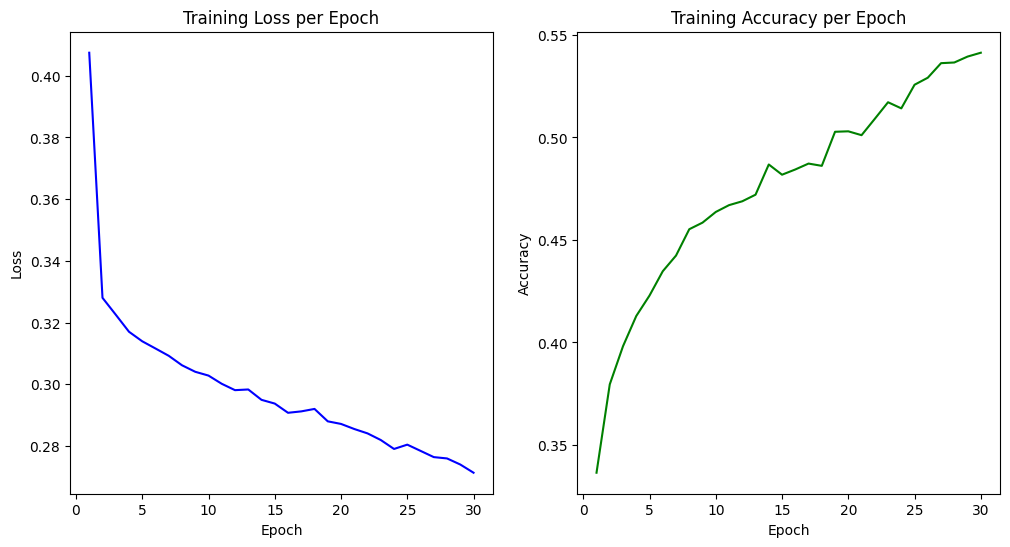

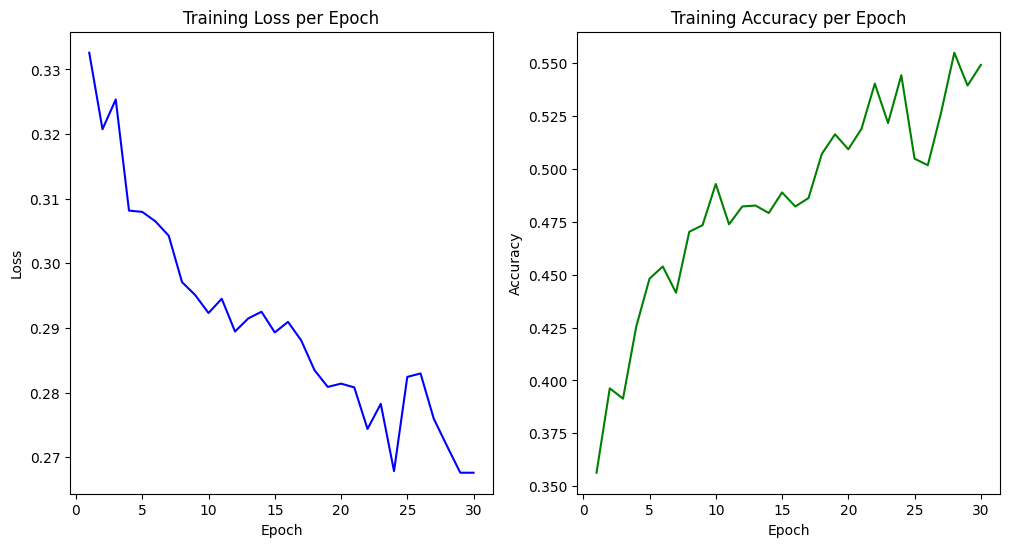

In [46]:
plot_training_progress(train_losses, train_accuracies, os.path.join(logs_folder, "plots"))
plot_training_progress(val_losses, val_accuracies, os.path.join(logs_folder, "plotsVal"))

## Заменим лосс на multiclass

- сначала быстро обучалось, потом стало скакать
- нужен lr поменьше?
- Epoch 22/30, Loss: 1.0092, Train Acc: 0.5181, Val Acc: 0.5248

In [47]:
class GeneralizedCrossEntropyLoss(torch.nn.Module):
    def __init__(self, q=0.3):
        super().__init__()
        self.q = q

    def forward(self, logits, targets):
        probs = torch.softmax(logits, dim=1)
        probs_true = probs[torch.arange(len(targets)), targets]
        if self.q == 0:
            loss = -torch.log(probs_true)
        else:
            loss = (1 - probs_true ** self.q) / self.q
        return loss.mean()

In [48]:
model = GNN(
    gnn_type='gin',
    num_class=6,
    num_layer=args.num_layer,
    emb_dim=args.emb_dim,
    drop_ratio=0.5,
    virtual_node=True,
    # num_graph_features=7,
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

criterion = GeneralizedCrossEntropyLoss()

In [49]:
# 
num_epochs = args.epochs
best_val_accuracy = 0.0   

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

if num_checkpoints > 1:
    checkpoint_intervals = [int((i + 1) * num_epochs / num_checkpoints) for i in range(num_checkpoints)]
else:
    checkpoint_intervals = [num_epochs]

for epoch in range(num_epochs):
    train_loss, train_acc = train(
        train_loader,
        model,
        optimizer,
        criterion,
        device,
        save_checkpoints=False,
        checkpoint_path=os.path.join(checkpoints_folder, f"model_{test_dir_name}"),
        current_epoch=epoch
    )

    val_loss,val_acc = evaluate(val_loader, model, device, criterion=criterion, calculate_accuracy=True)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
    logging.info(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.21batch/s]
Epoch 1/30, Loss: 1.2849, Train Acc: 0.3310, Val Acc: 0.3382


Epoch 1/30, Loss: 1.2849, Train Acc: 0.3310, Val Acc: 0.3382


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.17batch/s]
Epoch 2/30, Loss: 1.2028, Train Acc: 0.3824, Val Acc: 0.4167


Epoch 2/30, Loss: 1.2028, Train Acc: 0.3824, Val Acc: 0.4167


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.22batch/s]
Epoch 3/30, Loss: 1.1703, Train Acc: 0.4044, Val Acc: 0.3582


Epoch 3/30, Loss: 1.1703, Train Acc: 0.4044, Val Acc: 0.3582


Iterating eval graphs: 100%|██████████| 71/71 [00:10<00:00,  6.98batch/s]
Epoch 4/30, Loss: 1.1552, Train Acc: 0.4147, Val Acc: 0.4415


Epoch 4/30, Loss: 1.1552, Train Acc: 0.4147, Val Acc: 0.4415


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.15batch/s]
Epoch 5/30, Loss: 1.1350, Train Acc: 0.4274, Val Acc: 0.4277


Epoch 5/30, Loss: 1.1350, Train Acc: 0.4274, Val Acc: 0.4277


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.22batch/s]
Epoch 6/30, Loss: 1.1247, Train Acc: 0.4356, Val Acc: 0.4362


Epoch 6/30, Loss: 1.1247, Train Acc: 0.4356, Val Acc: 0.4362


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.27batch/s]
Epoch 7/30, Loss: 1.1167, Train Acc: 0.4477, Val Acc: 0.4623


Epoch 7/30, Loss: 1.1167, Train Acc: 0.4477, Val Acc: 0.4623


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.22batch/s]
Epoch 8/30, Loss: 1.1093, Train Acc: 0.4479, Val Acc: 0.4415


Epoch 8/30, Loss: 1.1093, Train Acc: 0.4479, Val Acc: 0.4415


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.23batch/s]
Epoch 9/30, Loss: 1.0947, Train Acc: 0.4574, Val Acc: 0.4508


Epoch 9/30, Loss: 1.0947, Train Acc: 0.4574, Val Acc: 0.4508


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.20batch/s]
Epoch 10/30, Loss: 1.0877, Train Acc: 0.4652, Val Acc: 0.4690


Epoch 10/30, Loss: 1.0877, Train Acc: 0.4652, Val Acc: 0.4690


Iterating eval graphs: 100%|██████████| 71/71 [00:10<00:00,  7.03batch/s]
Epoch 11/30, Loss: 1.0791, Train Acc: 0.4658, Val Acc: 0.4969


Epoch 11/30, Loss: 1.0791, Train Acc: 0.4658, Val Acc: 0.4969


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.14batch/s]
Epoch 12/30, Loss: 1.0719, Train Acc: 0.4720, Val Acc: 0.4601


Epoch 12/30, Loss: 1.0719, Train Acc: 0.4720, Val Acc: 0.4601


Iterating eval graphs: 100%|██████████| 71/71 [00:10<00:00,  7.05batch/s]
Epoch 13/30, Loss: 1.0598, Train Acc: 0.4806, Val Acc: 0.4295


Epoch 13/30, Loss: 1.0598, Train Acc: 0.4806, Val Acc: 0.4295


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.20batch/s]
Epoch 14/30, Loss: 1.0534, Train Acc: 0.4840, Val Acc: 0.5075


Epoch 14/30, Loss: 1.0534, Train Acc: 0.4840, Val Acc: 0.5075


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.14batch/s]
Epoch 15/30, Loss: 1.0508, Train Acc: 0.4902, Val Acc: 0.4672


Epoch 15/30, Loss: 1.0508, Train Acc: 0.4902, Val Acc: 0.4672


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.21batch/s]
Epoch 16/30, Loss: 1.0487, Train Acc: 0.4912, Val Acc: 0.5044


Epoch 16/30, Loss: 1.0487, Train Acc: 0.4912, Val Acc: 0.5044


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.21batch/s]
Epoch 17/30, Loss: 1.0396, Train Acc: 0.4943, Val Acc: 0.5195


Epoch 17/30, Loss: 1.0396, Train Acc: 0.4943, Val Acc: 0.5195


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.23batch/s]
Epoch 18/30, Loss: 1.0359, Train Acc: 0.4945, Val Acc: 0.4942


Epoch 18/30, Loss: 1.0359, Train Acc: 0.4945, Val Acc: 0.4942


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.16batch/s]
Epoch 19/30, Loss: 1.0187, Train Acc: 0.5055, Val Acc: 0.5222


Epoch 19/30, Loss: 1.0187, Train Acc: 0.5055, Val Acc: 0.5222


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.10batch/s]
Epoch 20/30, Loss: 1.0173, Train Acc: 0.5102, Val Acc: 0.5191


Epoch 20/30, Loss: 1.0173, Train Acc: 0.5102, Val Acc: 0.5191


Iterating eval graphs: 100%|██████████| 71/71 [00:10<00:00,  7.03batch/s]
Epoch 21/30, Loss: 1.0165, Train Acc: 0.5103, Val Acc: 0.5102


Epoch 21/30, Loss: 1.0165, Train Acc: 0.5103, Val Acc: 0.5102


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.18batch/s]
Epoch 22/30, Loss: 1.0092, Train Acc: 0.5181, Val Acc: 0.5248


Epoch 22/30, Loss: 1.0092, Train Acc: 0.5181, Val Acc: 0.5248


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.15batch/s]
Epoch 23/30, Loss: 1.0080, Train Acc: 0.5177, Val Acc: 0.5031


Epoch 23/30, Loss: 1.0080, Train Acc: 0.5177, Val Acc: 0.5031


Iterating training graphs:  70%|██████▉   | 197/282 [00:34<00:14,  5.70batch/s]


KeyboardInterrupt: 

## попробую другую реализацию (с клиппингом)

- как будто более стабильная
- Epoch 30/30, Loss: 0.9558, Train Acc: 0.5500, Val Acc: 0.5621

In [27]:

import torch
import torch.nn as nn
import torch.nn.functional as F

class GeneralizedCrossEntropyLoss(nn.Module):
    """
    Generalized Cross Entropy Loss for Training Deep Neural Networks with Noisy Labels
    2018 - Zhang et al. - https://arxiv.org/pdf/1805.07836.pdf
    
    Args:
        q (float): Robustness parameter. q=0 gives standard cross-entropy, q=1 gives MAE.
                  Recommended range: [0.1, 0.7] for noise robustness.
        reduction (str): Specifies the reduction to apply to the output.
        eps (float): Small value to prevent numerical instability.
    """
    
    def __init__(self, q=0.3, reduction='mean', eps=1e-7):
        super(GeneralizedCrossEntropyLoss, self).__init__()
        self.q = q
        self.reduction = reduction
        self.eps = eps
    
    def forward(self, logits, targets):
        """
        Args:
            logits: Tensor of shape (N, C) containing raw logits
            targets: Tensor of shape (N,) containing class indices
        """
        # Convert logits to probabilities
        y_pred = F.softmax(logits, dim=-1)
        
        # Convert targets to one-hot encoding
        y_true = F.one_hot(targets, num_classes=logits.size(-1)).float()
        
        # Compute GCE loss with clamping for numerical stability
        # Clamp predictions to avoid numerical issues
        y_pred = torch.clamp(y_pred, min=self.eps, max=1.0 - self.eps)
        
        # Compute the sum of y_true * y_pred along class dimension
        pred_sum = torch.sum(y_true * y_pred, dim=-1)
        
        # Clamp again before taking the power to ensure stability
        pred_sum = torch.clamp(pred_sum, min=self.eps)
        
        # GCE loss: (1 - pred_sum^q) / q
        if self.q == 0:
            # Special case: standard cross-entropy (limit as q->0)
            loss = -torch.log(pred_sum)
        else:
            intermed = torch.pow(pred_sum, self.q)
            loss = (1 - intermed) / self.q
        
        if self.reduction == 'mean':
            return torch.mean(loss)
        elif self.reduction == 'sum':
            return torch.sum(loss)
        else:  # 'none'
            return loss

In [51]:
model = GNN(
    gnn_type='gin',
    num_class=6,
    num_layer=args.num_layer,
    emb_dim=args.emb_dim,
    drop_ratio=0.5,
    virtual_node=True,
    # num_graph_features=7,
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

criterion = GeneralizedCrossEntropyLoss()

In [52]:
# 
num_epochs = args.epochs
best_val_accuracy = 0.0   

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

if num_checkpoints > 1:
    checkpoint_intervals = [int((i + 1) * num_epochs / num_checkpoints) for i in range(num_checkpoints)]
else:
    checkpoint_intervals = [num_epochs]

for epoch in range(num_epochs):
    train_loss, train_acc = train(
        train_loader,
        model,
        optimizer,
        criterion,
        device,
        save_checkpoints=False,
        checkpoint_path=os.path.join(checkpoints_folder, f"model_{test_dir_name}"),
        current_epoch=epoch
    )

    val_loss,val_acc = evaluate(val_loader, model, device, criterion=criterion, calculate_accuracy=True)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
    logging.info(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

Iterating eval graphs: 100%|██████████| 71/71 [00:10<00:00,  7.10batch/s]
Epoch 1/30, Loss: 1.2695, Train Acc: 0.3472, Val Acc: 0.3590


Epoch 1/30, Loss: 1.2695, Train Acc: 0.3472, Val Acc: 0.3590


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.11batch/s]
Epoch 2/30, Loss: 1.1985, Train Acc: 0.3833, Val Acc: 0.3599


Epoch 2/30, Loss: 1.1985, Train Acc: 0.3833, Val Acc: 0.3599


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.20batch/s]
Epoch 3/30, Loss: 1.1800, Train Acc: 0.3958, Val Acc: 0.3941


Epoch 3/30, Loss: 1.1800, Train Acc: 0.3958, Val Acc: 0.3941


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.20batch/s]
Epoch 4/30, Loss: 1.1528, Train Acc: 0.4157, Val Acc: 0.3989


Epoch 4/30, Loss: 1.1528, Train Acc: 0.4157, Val Acc: 0.3989


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.24batch/s]
Epoch 5/30, Loss: 1.1348, Train Acc: 0.4289, Val Acc: 0.4255


Epoch 5/30, Loss: 1.1348, Train Acc: 0.4289, Val Acc: 0.4255


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.11batch/s]
Epoch 6/30, Loss: 1.1328, Train Acc: 0.4299, Val Acc: 0.4473


Epoch 6/30, Loss: 1.1328, Train Acc: 0.4299, Val Acc: 0.4473


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.23batch/s]
Epoch 7/30, Loss: 1.1164, Train Acc: 0.4427, Val Acc: 0.4668


Epoch 7/30, Loss: 1.1164, Train Acc: 0.4427, Val Acc: 0.4668


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.23batch/s]
Epoch 8/30, Loss: 1.1051, Train Acc: 0.4522, Val Acc: 0.4738


Epoch 8/30, Loss: 1.1051, Train Acc: 0.4522, Val Acc: 0.4738


Iterating eval graphs: 100%|██████████| 71/71 [00:10<00:00,  7.04batch/s]
Epoch 9/30, Loss: 1.0961, Train Acc: 0.4577, Val Acc: 0.4543


Epoch 9/30, Loss: 1.0961, Train Acc: 0.4577, Val Acc: 0.4543


Iterating eval graphs: 100%|██████████| 71/71 [00:10<00:00,  7.02batch/s]
Epoch 10/30, Loss: 1.0810, Train Acc: 0.4666, Val Acc: 0.4849


Epoch 10/30, Loss: 1.0810, Train Acc: 0.4666, Val Acc: 0.4849


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.21batch/s]
Epoch 11/30, Loss: 1.0819, Train Acc: 0.4654, Val Acc: 0.4730


Epoch 11/30, Loss: 1.0819, Train Acc: 0.4654, Val Acc: 0.4730


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.20batch/s]
Epoch 12/30, Loss: 1.0638, Train Acc: 0.4771, Val Acc: 0.4561


Epoch 12/30, Loss: 1.0638, Train Acc: 0.4771, Val Acc: 0.4561


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.24batch/s]
Epoch 13/30, Loss: 1.0599, Train Acc: 0.4775, Val Acc: 0.4583


Epoch 13/30, Loss: 1.0599, Train Acc: 0.4775, Val Acc: 0.4583


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.24batch/s]
Epoch 14/30, Loss: 1.0533, Train Acc: 0.4801, Val Acc: 0.4947


Epoch 14/30, Loss: 1.0533, Train Acc: 0.4801, Val Acc: 0.4947


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.21batch/s]
Epoch 15/30, Loss: 1.0527, Train Acc: 0.4852, Val Acc: 0.5009


Epoch 15/30, Loss: 1.0527, Train Acc: 0.4852, Val Acc: 0.5009


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.10batch/s]
Epoch 16/30, Loss: 1.0357, Train Acc: 0.4967, Val Acc: 0.5253


Epoch 16/30, Loss: 1.0357, Train Acc: 0.4967, Val Acc: 0.5253


Iterating eval graphs: 100%|██████████| 71/71 [00:10<00:00,  7.06batch/s]
Epoch 17/30, Loss: 1.0302, Train Acc: 0.5047, Val Acc: 0.5102


Epoch 17/30, Loss: 1.0302, Train Acc: 0.5047, Val Acc: 0.5102


Iterating eval graphs: 100%|██████████| 71/71 [00:10<00:00,  7.04batch/s]
Epoch 18/30, Loss: 1.0293, Train Acc: 0.5023, Val Acc: 0.5319


Epoch 18/30, Loss: 1.0293, Train Acc: 0.5023, Val Acc: 0.5319


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.25batch/s]
Epoch 19/30, Loss: 1.0167, Train Acc: 0.5081, Val Acc: 0.5257


Epoch 19/30, Loss: 1.0167, Train Acc: 0.5081, Val Acc: 0.5257


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.23batch/s]
Epoch 20/30, Loss: 1.0115, Train Acc: 0.5109, Val Acc: 0.5363


Epoch 20/30, Loss: 1.0115, Train Acc: 0.5109, Val Acc: 0.5363


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.24batch/s]
Epoch 21/30, Loss: 1.0084, Train Acc: 0.5143, Val Acc: 0.5279


Epoch 21/30, Loss: 1.0084, Train Acc: 0.5143, Val Acc: 0.5279


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.24batch/s]
Epoch 22/30, Loss: 1.0050, Train Acc: 0.5191, Val Acc: 0.5297


Epoch 22/30, Loss: 1.0050, Train Acc: 0.5191, Val Acc: 0.5297


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.18batch/s]
Epoch 23/30, Loss: 0.9924, Train Acc: 0.5238, Val Acc: 0.5479


Epoch 23/30, Loss: 0.9924, Train Acc: 0.5238, Val Acc: 0.5479


Iterating eval graphs: 100%|██████████| 71/71 [00:10<00:00,  7.05batch/s]
Epoch 24/30, Loss: 0.9894, Train Acc: 0.5267, Val Acc: 0.5248


Epoch 24/30, Loss: 0.9894, Train Acc: 0.5267, Val Acc: 0.5248


Iterating eval graphs: 100%|██████████| 71/71 [00:10<00:00,  6.99batch/s]
Epoch 25/30, Loss: 0.9850, Train Acc: 0.5278, Val Acc: 0.5306


Epoch 25/30, Loss: 0.9850, Train Acc: 0.5278, Val Acc: 0.5306


Iterating eval graphs: 100%|██████████| 71/71 [00:10<00:00,  7.09batch/s]
Epoch 26/30, Loss: 0.9819, Train Acc: 0.5322, Val Acc: 0.5230


Epoch 26/30, Loss: 0.9819, Train Acc: 0.5322, Val Acc: 0.5230


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.21batch/s]
Epoch 27/30, Loss: 0.9728, Train Acc: 0.5373, Val Acc: 0.5519


Epoch 27/30, Loss: 0.9728, Train Acc: 0.5373, Val Acc: 0.5519


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.19batch/s]
Epoch 28/30, Loss: 0.9683, Train Acc: 0.5416, Val Acc: 0.5514


Epoch 28/30, Loss: 0.9683, Train Acc: 0.5416, Val Acc: 0.5514


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.20batch/s]
Epoch 29/30, Loss: 0.9744, Train Acc: 0.5332, Val Acc: 0.5363


Epoch 29/30, Loss: 0.9744, Train Acc: 0.5332, Val Acc: 0.5363


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.22batch/s]
Epoch 30/30, Loss: 0.9558, Train Acc: 0.5500, Val Acc: 0.5621


Epoch 30/30, Loss: 0.9558, Train Acc: 0.5500, Val Acc: 0.5621


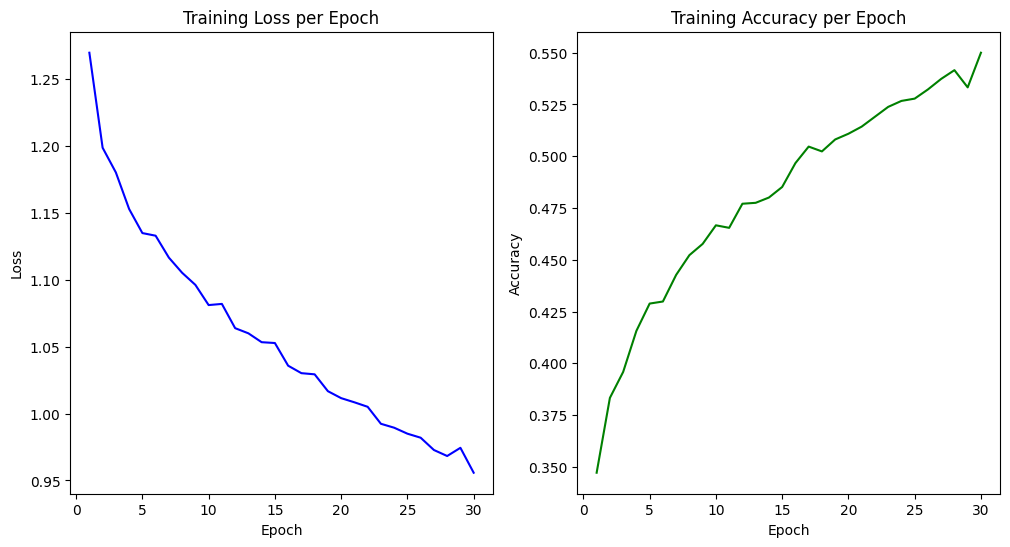

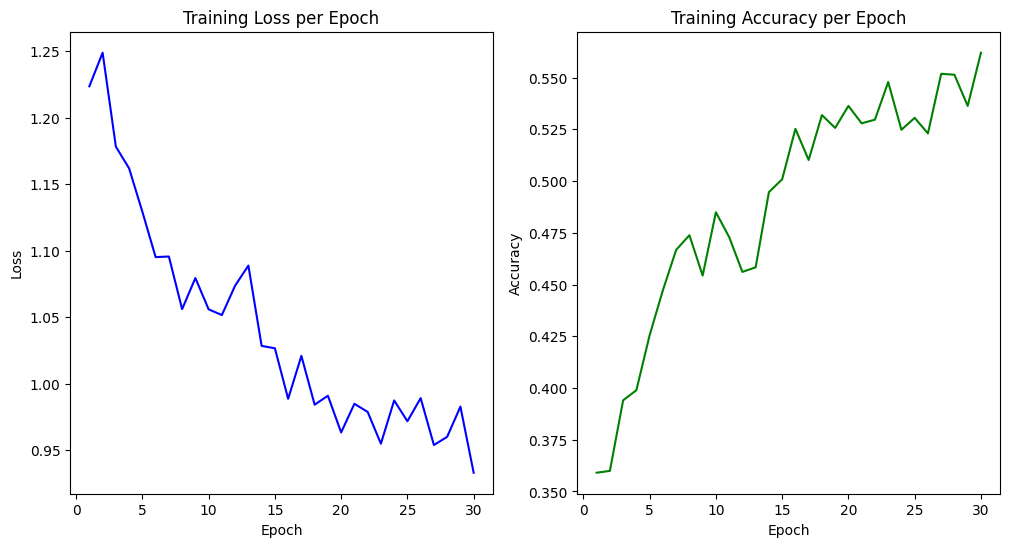

In [53]:
plot_training_progress(train_losses, train_accuracies, os.path.join(logs_folder, "plots"))
plot_training_progress(val_losses, val_accuracies, os.path.join(logs_folder, "plotsVal"))

## Сделала set2set и уменьшила размер модельки (эмбеддинги и слои)

Epoch 30/30, Loss: 0.9348, Train Acc: 0.5571, Val Acc: 0.5598

In [59]:
model = GNN(
    gnn_type='gin',
    num_class=6,
    num_layer=3,
    emb_dim=128,
    drop_ratio=0.5,
    virtual_node=True,
    graph_pooling="set2set",
    # num_graph_features=7,
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

criterion = GeneralizedCrossEntropyLoss()

In [60]:
num_epochs = args.epochs
best_val_accuracy = 0.0   

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

if num_checkpoints > 1:
    checkpoint_intervals = [int((i + 1) * num_epochs / num_checkpoints) for i in range(num_checkpoints)]
else:
    checkpoint_intervals = [num_epochs]

for epoch in range(num_epochs):
    train_loss, train_acc = train(
        train_loader,
        model,
        optimizer,
        criterion,
        device,
        save_checkpoints=False,
        checkpoint_path=os.path.join(checkpoints_folder, f"model_{test_dir_name}"),
        current_epoch=epoch
    )

    val_loss,val_acc = evaluate(val_loader, model, device, criterion=criterion, calculate_accuracy=True)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
    logging.info(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

Iterating eval graphs: 100%|██████████| 71/71 [00:08<00:00,  8.25batch/s]
Epoch 1/30, Loss: 1.2608, Train Acc: 0.3512, Val Acc: 0.3785


Epoch 1/30, Loss: 1.2608, Train Acc: 0.3512, Val Acc: 0.3785


Iterating eval graphs: 100%|██████████| 71/71 [00:08<00:00,  8.35batch/s]
Epoch 2/30, Loss: 1.1806, Train Acc: 0.3866, Val Acc: 0.4145


Epoch 2/30, Loss: 1.1806, Train Acc: 0.3866, Val Acc: 0.4145


Iterating eval graphs: 100%|██████████| 71/71 [00:08<00:00,  8.33batch/s]
Epoch 3/30, Loss: 1.1531, Train Acc: 0.4106, Val Acc: 0.4295


Epoch 3/30, Loss: 1.1531, Train Acc: 0.4106, Val Acc: 0.4295


Iterating eval graphs: 100%|██████████| 71/71 [00:08<00:00,  8.38batch/s]
Epoch 4/30, Loss: 1.1381, Train Acc: 0.4241, Val Acc: 0.4375


Epoch 4/30, Loss: 1.1381, Train Acc: 0.4241, Val Acc: 0.4375


Iterating eval graphs: 100%|██████████| 71/71 [00:08<00:00,  8.32batch/s]
Epoch 5/30, Loss: 1.1148, Train Acc: 0.4374, Val Acc: 0.4309


Epoch 5/30, Loss: 1.1148, Train Acc: 0.4374, Val Acc: 0.4309


Iterating eval graphs: 100%|██████████| 71/71 [00:08<00:00,  8.28batch/s]
Epoch 6/30, Loss: 1.1057, Train Acc: 0.4423, Val Acc: 0.4397


Epoch 6/30, Loss: 1.1057, Train Acc: 0.4423, Val Acc: 0.4397


Iterating eval graphs: 100%|██████████| 71/71 [00:08<00:00,  8.35batch/s]
Epoch 7/30, Loss: 1.0888, Train Acc: 0.4574, Val Acc: 0.4619


Epoch 7/30, Loss: 1.0888, Train Acc: 0.4574, Val Acc: 0.4619


Iterating eval graphs: 100%|██████████| 71/71 [00:08<00:00,  8.19batch/s]
Epoch 8/30, Loss: 1.0751, Train Acc: 0.4671, Val Acc: 0.4765


Epoch 8/30, Loss: 1.0751, Train Acc: 0.4671, Val Acc: 0.4765


Iterating eval graphs: 100%|██████████| 71/71 [00:08<00:00,  8.35batch/s]
Epoch 9/30, Loss: 1.0642, Train Acc: 0.4722, Val Acc: 0.4614


Epoch 9/30, Loss: 1.0642, Train Acc: 0.4722, Val Acc: 0.4614


Iterating eval graphs: 100%|██████████| 71/71 [00:08<00:00,  7.99batch/s]
Epoch 10/30, Loss: 1.0549, Train Acc: 0.4830, Val Acc: 0.5111


Epoch 10/30, Loss: 1.0549, Train Acc: 0.4830, Val Acc: 0.5111


Iterating eval graphs: 100%|██████████| 71/71 [00:08<00:00,  8.19batch/s]
Epoch 11/30, Loss: 1.0496, Train Acc: 0.4843, Val Acc: 0.4876


Epoch 11/30, Loss: 1.0496, Train Acc: 0.4843, Val Acc: 0.4876


Iterating eval graphs: 100%|██████████| 71/71 [00:08<00:00,  8.17batch/s]
Epoch 12/30, Loss: 1.0416, Train Acc: 0.4880, Val Acc: 0.5098


Epoch 12/30, Loss: 1.0416, Train Acc: 0.4880, Val Acc: 0.5098


Iterating eval graphs: 100%|██████████| 71/71 [00:08<00:00,  8.13batch/s]
Epoch 13/30, Loss: 1.0305, Train Acc: 0.5000, Val Acc: 0.4978


Epoch 13/30, Loss: 1.0305, Train Acc: 0.5000, Val Acc: 0.4978


Iterating eval graphs: 100%|██████████| 71/71 [00:08<00:00,  8.22batch/s]
Epoch 14/30, Loss: 1.0281, Train Acc: 0.5003, Val Acc: 0.5124


Epoch 14/30, Loss: 1.0281, Train Acc: 0.5003, Val Acc: 0.5124


Iterating eval graphs: 100%|██████████| 71/71 [00:08<00:00,  8.21batch/s]
Epoch 15/30, Loss: 1.0211, Train Acc: 0.5055, Val Acc: 0.4987


Epoch 15/30, Loss: 1.0211, Train Acc: 0.5055, Val Acc: 0.4987


Iterating eval graphs: 100%|██████████| 71/71 [00:08<00:00,  8.06batch/s]
Epoch 16/30, Loss: 1.0133, Train Acc: 0.5104, Val Acc: 0.5133


Epoch 16/30, Loss: 1.0133, Train Acc: 0.5104, Val Acc: 0.5133


Iterating eval graphs: 100%|██████████| 71/71 [00:08<00:00,  8.27batch/s]
Epoch 17/30, Loss: 1.0049, Train Acc: 0.5156, Val Acc: 0.5341


Epoch 17/30, Loss: 1.0049, Train Acc: 0.5156, Val Acc: 0.5341


Iterating eval graphs: 100%|██████████| 71/71 [00:08<00:00,  8.23batch/s]
Epoch 18/30, Loss: 1.0000, Train Acc: 0.5178, Val Acc: 0.4960


Epoch 18/30, Loss: 1.0000, Train Acc: 0.5178, Val Acc: 0.4960


Iterating eval graphs: 100%|██████████| 71/71 [00:08<00:00,  8.26batch/s]
Epoch 19/30, Loss: 0.9938, Train Acc: 0.5162, Val Acc: 0.5222


Epoch 19/30, Loss: 0.9938, Train Acc: 0.5162, Val Acc: 0.5222


Iterating eval graphs: 100%|██████████| 71/71 [00:08<00:00,  8.24batch/s]
Epoch 20/30, Loss: 0.9838, Train Acc: 0.5242, Val Acc: 0.5439


Epoch 20/30, Loss: 0.9838, Train Acc: 0.5242, Val Acc: 0.5439


Iterating eval graphs: 100%|██████████| 71/71 [00:08<00:00,  8.21batch/s]
Epoch 21/30, Loss: 0.9795, Train Acc: 0.5305, Val Acc: 0.5195


Epoch 21/30, Loss: 0.9795, Train Acc: 0.5305, Val Acc: 0.5195


Iterating eval graphs: 100%|██████████| 71/71 [00:08<00:00,  8.12batch/s]
Epoch 22/30, Loss: 0.9750, Train Acc: 0.5377, Val Acc: 0.5377


Epoch 22/30, Loss: 0.9750, Train Acc: 0.5377, Val Acc: 0.5377


Iterating eval graphs: 100%|██████████| 71/71 [00:08<00:00,  8.21batch/s]
Epoch 23/30, Loss: 0.9685, Train Acc: 0.5373, Val Acc: 0.5412


Epoch 23/30, Loss: 0.9685, Train Acc: 0.5373, Val Acc: 0.5412


Iterating eval graphs: 100%|██████████| 71/71 [00:08<00:00,  8.23batch/s]
Epoch 24/30, Loss: 0.9648, Train Acc: 0.5422, Val Acc: 0.5434


Epoch 24/30, Loss: 0.9648, Train Acc: 0.5422, Val Acc: 0.5434


Iterating eval graphs: 100%|██████████| 71/71 [00:08<00:00,  8.25batch/s]
Epoch 25/30, Loss: 0.9580, Train Acc: 0.5423, Val Acc: 0.5191


Epoch 25/30, Loss: 0.9580, Train Acc: 0.5423, Val Acc: 0.5191


Iterating eval graphs: 100%|██████████| 71/71 [00:08<00:00,  8.21batch/s]
Epoch 26/30, Loss: 0.9537, Train Acc: 0.5457, Val Acc: 0.5510


Epoch 26/30, Loss: 0.9537, Train Acc: 0.5457, Val Acc: 0.5510


Iterating eval graphs: 100%|██████████| 71/71 [00:08<00:00,  8.17batch/s]
Epoch 27/30, Loss: 0.9528, Train Acc: 0.5519, Val Acc: 0.5598


Epoch 27/30, Loss: 0.9528, Train Acc: 0.5519, Val Acc: 0.5598


Iterating eval graphs: 100%|██████████| 71/71 [00:08<00:00,  8.26batch/s]
Epoch 28/30, Loss: 0.9418, Train Acc: 0.5535, Val Acc: 0.5439


Epoch 28/30, Loss: 0.9418, Train Acc: 0.5535, Val Acc: 0.5439


Iterating eval graphs: 100%|██████████| 71/71 [00:08<00:00,  8.27batch/s]
Epoch 29/30, Loss: 0.9440, Train Acc: 0.5534, Val Acc: 0.5381


Epoch 29/30, Loss: 0.9440, Train Acc: 0.5534, Val Acc: 0.5381


Iterating eval graphs: 100%|██████████| 71/71 [00:08<00:00,  8.18batch/s]
Epoch 30/30, Loss: 0.9348, Train Acc: 0.5571, Val Acc: 0.5598


Epoch 30/30, Loss: 0.9348, Train Acc: 0.5571, Val Acc: 0.5598


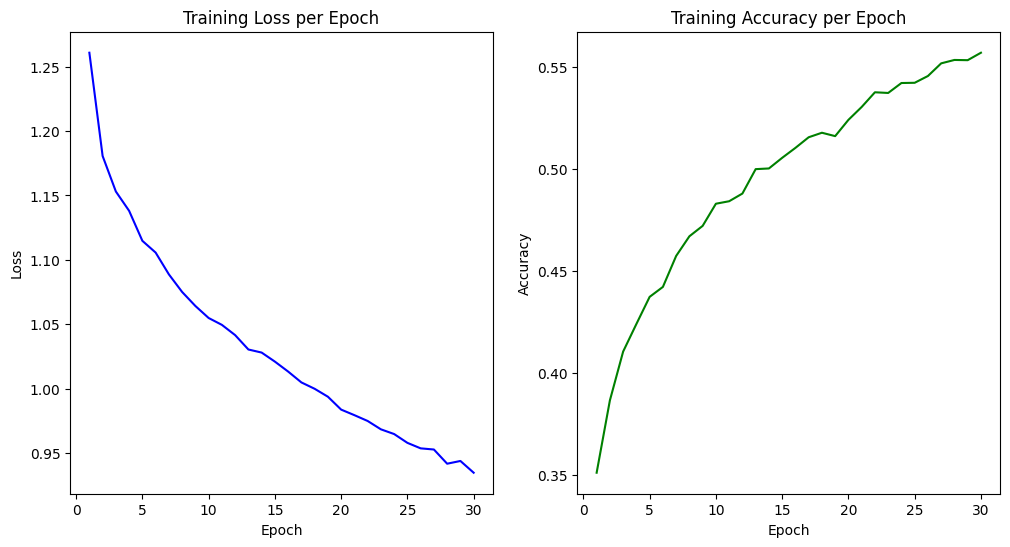

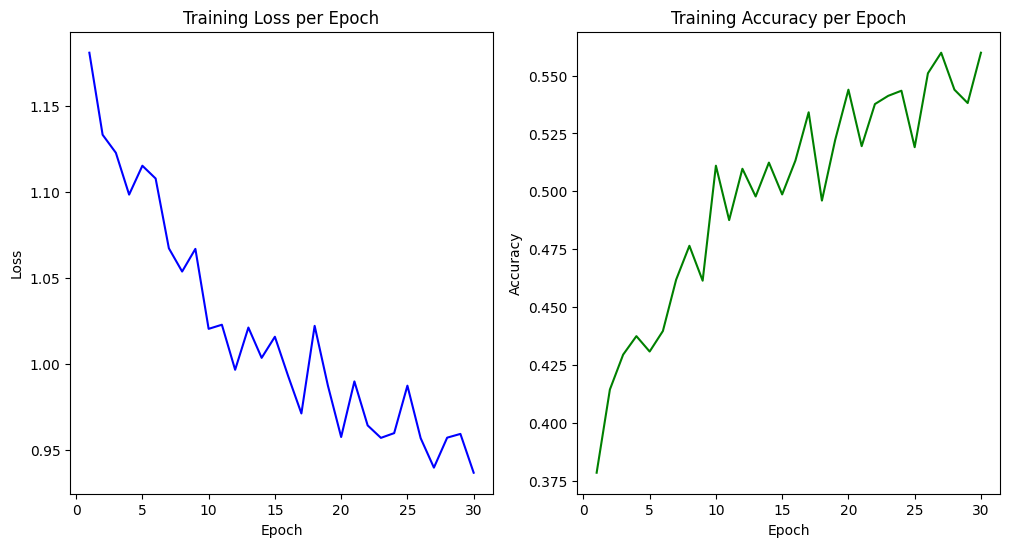

In [61]:
plot_training_progress(train_losses, train_accuracies, os.path.join(logs_folder, "plots"))
plot_training_progress(val_losses, val_accuracies, os.path.join(logs_folder, "plotsVal"))

## Дообучу ещё

- как будто на 90 эпохе стало происходить переобучение

In [62]:
for epoch in range(30):
    train_loss, train_acc = train(
        train_loader,
        model,
        optimizer,
        criterion,
        device,
        save_checkpoints=False,
        checkpoint_path=os.path.join(checkpoints_folder, f"model_{test_dir_name}"),
        current_epoch=epoch+30,
    )

    val_loss,val_acc = evaluate(val_loader, model, device, criterion=criterion, calculate_accuracy=True)

    print(f"Epoch {epoch + 31}/{num_epochs + 30}, Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
    logging.info(f"Epoch {epoch + 31}/{num_epochs + 30}, Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

Iterating eval graphs: 100%|██████████| 71/71 [00:08<00:00,  8.14batch/s]
Epoch 31/60, Loss: 0.9304, Train Acc: 0.5574, Val Acc: 0.5519


Epoch 31/60, Loss: 0.9304, Train Acc: 0.5574, Val Acc: 0.5519


Iterating eval graphs: 100%|██████████| 71/71 [00:08<00:00,  8.23batch/s]
Epoch 32/60, Loss: 0.9291, Train Acc: 0.5632, Val Acc: 0.5576


Epoch 32/60, Loss: 0.9291, Train Acc: 0.5632, Val Acc: 0.5576


Iterating eval graphs: 100%|██████████| 71/71 [00:08<00:00,  8.21batch/s]
Epoch 33/60, Loss: 0.9218, Train Acc: 0.5683, Val Acc: 0.5536


Epoch 33/60, Loss: 0.9218, Train Acc: 0.5683, Val Acc: 0.5536


Iterating eval graphs: 100%|██████████| 71/71 [00:08<00:00,  8.26batch/s]
Epoch 34/60, Loss: 0.9184, Train Acc: 0.5690, Val Acc: 0.5727


Epoch 34/60, Loss: 0.9184, Train Acc: 0.5690, Val Acc: 0.5727


Iterating eval graphs: 100%|██████████| 71/71 [00:08<00:00,  8.17batch/s]
Epoch 35/60, Loss: 0.9094, Train Acc: 0.5715, Val Acc: 0.5505


Epoch 35/60, Loss: 0.9094, Train Acc: 0.5715, Val Acc: 0.5505


Iterating eval graphs: 100%|██████████| 71/71 [00:08<00:00,  8.04batch/s]
Epoch 36/60, Loss: 0.9120, Train Acc: 0.5721, Val Acc: 0.5709


Epoch 36/60, Loss: 0.9120, Train Acc: 0.5721, Val Acc: 0.5709


Iterating eval graphs: 100%|██████████| 71/71 [00:08<00:00,  8.13batch/s]
Epoch 37/60, Loss: 0.9049, Train Acc: 0.5788, Val Acc: 0.5465


Epoch 37/60, Loss: 0.9049, Train Acc: 0.5788, Val Acc: 0.5465


Iterating eval graphs: 100%|██████████| 71/71 [00:08<00:00,  8.20batch/s]
Epoch 38/60, Loss: 0.9031, Train Acc: 0.5762, Val Acc: 0.5634


Epoch 38/60, Loss: 0.9031, Train Acc: 0.5762, Val Acc: 0.5634


Iterating eval graphs: 100%|██████████| 71/71 [00:08<00:00,  8.22batch/s]
Epoch 39/60, Loss: 0.8954, Train Acc: 0.5810, Val Acc: 0.5399


Epoch 39/60, Loss: 0.8954, Train Acc: 0.5810, Val Acc: 0.5399


Iterating eval graphs: 100%|██████████| 71/71 [00:08<00:00,  8.21batch/s]
Epoch 40/60, Loss: 0.8959, Train Acc: 0.5812, Val Acc: 0.5550


Epoch 40/60, Loss: 0.8959, Train Acc: 0.5812, Val Acc: 0.5550


Iterating eval graphs: 100%|██████████| 71/71 [00:08<00:00,  8.15batch/s]
Epoch 41/60, Loss: 0.8954, Train Acc: 0.5813, Val Acc: 0.5514


Epoch 41/60, Loss: 0.8954, Train Acc: 0.5813, Val Acc: 0.5514


Iterating eval graphs: 100%|██████████| 71/71 [00:08<00:00,  8.16batch/s]
Epoch 42/60, Loss: 0.8842, Train Acc: 0.5912, Val Acc: 0.5669


Epoch 42/60, Loss: 0.8842, Train Acc: 0.5912, Val Acc: 0.5669


Iterating eval graphs: 100%|██████████| 71/71 [00:08<00:00,  8.21batch/s]
Epoch 43/60, Loss: 0.8844, Train Acc: 0.5868, Val Acc: 0.5700


Epoch 43/60, Loss: 0.8844, Train Acc: 0.5868, Val Acc: 0.5700


Iterating eval graphs: 100%|██████████| 71/71 [00:08<00:00,  8.21batch/s]
Epoch 44/60, Loss: 0.8861, Train Acc: 0.5861, Val Acc: 0.5829


Epoch 44/60, Loss: 0.8861, Train Acc: 0.5861, Val Acc: 0.5829


Iterating eval graphs: 100%|██████████| 71/71 [00:08<00:00,  8.27batch/s]
Epoch 45/60, Loss: 0.8772, Train Acc: 0.5962, Val Acc: 0.5492


Epoch 45/60, Loss: 0.8772, Train Acc: 0.5962, Val Acc: 0.5492


Iterating eval graphs: 100%|██████████| 71/71 [00:08<00:00,  8.21batch/s]
Epoch 46/60, Loss: 0.8713, Train Acc: 0.5957, Val Acc: 0.5754


Epoch 46/60, Loss: 0.8713, Train Acc: 0.5957, Val Acc: 0.5754


Iterating eval graphs: 100%|██████████| 71/71 [00:08<00:00,  8.29batch/s]
Epoch 47/60, Loss: 0.8647, Train Acc: 0.6028, Val Acc: 0.5780


Epoch 47/60, Loss: 0.8647, Train Acc: 0.6028, Val Acc: 0.5780


Iterating eval graphs: 100%|██████████| 71/71 [00:08<00:00,  8.24batch/s]
Epoch 48/60, Loss: 0.8673, Train Acc: 0.5962, Val Acc: 0.5869


Epoch 48/60, Loss: 0.8673, Train Acc: 0.5962, Val Acc: 0.5869


Iterating eval graphs: 100%|██████████| 71/71 [00:08<00:00,  8.26batch/s]
Epoch 49/60, Loss: 0.8585, Train Acc: 0.6053, Val Acc: 0.5634


Epoch 49/60, Loss: 0.8585, Train Acc: 0.6053, Val Acc: 0.5634


Iterating eval graphs: 100%|██████████| 71/71 [00:08<00:00,  8.28batch/s]
Epoch 50/60, Loss: 0.8590, Train Acc: 0.6068, Val Acc: 0.5811


Epoch 50/60, Loss: 0.8590, Train Acc: 0.6068, Val Acc: 0.5811


Iterating eval graphs: 100%|██████████| 71/71 [00:08<00:00,  8.29batch/s]
Epoch 51/60, Loss: 0.8592, Train Acc: 0.6017, Val Acc: 0.5714


Epoch 51/60, Loss: 0.8592, Train Acc: 0.6017, Val Acc: 0.5714


Iterating eval graphs: 100%|██████████| 71/71 [00:08<00:00,  8.22batch/s]
Epoch 52/60, Loss: 0.8563, Train Acc: 0.6022, Val Acc: 0.5869


Epoch 52/60, Loss: 0.8563, Train Acc: 0.6022, Val Acc: 0.5869


Iterating eval graphs: 100%|██████████| 71/71 [00:08<00:00,  8.23batch/s]
Epoch 53/60, Loss: 0.8552, Train Acc: 0.6053, Val Acc: 0.5749


Epoch 53/60, Loss: 0.8552, Train Acc: 0.6053, Val Acc: 0.5749


Iterating eval graphs: 100%|██████████| 71/71 [00:08<00:00,  8.16batch/s]
Epoch 54/60, Loss: 0.8417, Train Acc: 0.6154, Val Acc: 0.5740


Epoch 54/60, Loss: 0.8417, Train Acc: 0.6154, Val Acc: 0.5740


Iterating eval graphs: 100%|██████████| 71/71 [00:08<00:00,  8.14batch/s]
Epoch 55/60, Loss: 0.8429, Train Acc: 0.6130, Val Acc: 0.5811


Epoch 55/60, Loss: 0.8429, Train Acc: 0.6130, Val Acc: 0.5811


Iterating training graphs:  16%|█▌        | 45/282 [00:06<00:34,  6.88batch/s]


KeyboardInterrupt: 

In [64]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [65]:
for epoch in range(30):
    train_loss, train_acc = train(
        train_loader,
        model,
        optimizer,
        criterion,
        device,
        save_checkpoints=False,
        checkpoint_path=os.path.join(checkpoints_folder, f"model_{test_dir_name}"),
        current_epoch=epoch+55,
    )

    val_loss,val_acc = evaluate(val_loader, model, device, criterion=criterion, calculate_accuracy=True)

    print(f"Epoch {epoch + 56}/{num_epochs + 55}, Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
    logging.info(f"Epoch {epoch + 56}/{num_epochs + 55}, Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

Iterating eval graphs: 100%|██████████| 71/71 [00:08<00:00,  8.32batch/s]
Epoch 56/85, Loss: 0.7939, Train Acc: 0.6384, Val Acc: 0.5816


Epoch 56/85, Loss: 0.7939, Train Acc: 0.6384, Val Acc: 0.5816


Iterating eval graphs: 100%|██████████| 71/71 [00:08<00:00,  8.38batch/s]
Epoch 57/85, Loss: 0.7812, Train Acc: 0.6484, Val Acc: 0.5913


Epoch 57/85, Loss: 0.7812, Train Acc: 0.6484, Val Acc: 0.5913


Iterating eval graphs: 100%|██████████| 71/71 [00:08<00:00,  8.29batch/s]
Epoch 58/85, Loss: 0.7740, Train Acc: 0.6477, Val Acc: 0.5953


Epoch 58/85, Loss: 0.7740, Train Acc: 0.6477, Val Acc: 0.5953


Iterating eval graphs: 100%|██████████| 71/71 [00:08<00:00,  8.30batch/s]
Epoch 59/85, Loss: 0.7782, Train Acc: 0.6466, Val Acc: 0.5953


Epoch 59/85, Loss: 0.7782, Train Acc: 0.6466, Val Acc: 0.5953


Iterating eval graphs: 100%|██████████| 71/71 [00:08<00:00,  8.33batch/s]
Epoch 60/85, Loss: 0.7656, Train Acc: 0.6566, Val Acc: 0.5904


Epoch 60/85, Loss: 0.7656, Train Acc: 0.6566, Val Acc: 0.5904


Iterating eval graphs: 100%|██████████| 71/71 [00:08<00:00,  8.23batch/s]
Epoch 61/85, Loss: 0.7704, Train Acc: 0.6492, Val Acc: 0.5913


Epoch 61/85, Loss: 0.7704, Train Acc: 0.6492, Val Acc: 0.5913


Iterating eval graphs: 100%|██████████| 71/71 [00:08<00:00,  8.39batch/s]
Epoch 62/85, Loss: 0.7661, Train Acc: 0.6559, Val Acc: 0.5824


Epoch 62/85, Loss: 0.7661, Train Acc: 0.6559, Val Acc: 0.5824


Iterating eval graphs: 100%|██████████| 71/71 [00:08<00:00,  8.41batch/s]
Epoch 63/85, Loss: 0.7688, Train Acc: 0.6504, Val Acc: 0.5895


Epoch 63/85, Loss: 0.7688, Train Acc: 0.6504, Val Acc: 0.5895


Iterating eval graphs: 100%|██████████| 71/71 [00:08<00:00,  8.30batch/s]
Epoch 64/85, Loss: 0.7550, Train Acc: 0.6610, Val Acc: 0.5838


Epoch 64/85, Loss: 0.7550, Train Acc: 0.6610, Val Acc: 0.5838


Iterating eval graphs: 100%|██████████| 71/71 [00:08<00:00,  8.36batch/s]
Epoch 65/85, Loss: 0.7606, Train Acc: 0.6525, Val Acc: 0.5922


Epoch 65/85, Loss: 0.7606, Train Acc: 0.6525, Val Acc: 0.5922


Iterating training graphs:  74%|███████▍  | 210/282 [00:28<00:09,  7.31batch/s]


KeyboardInterrupt: 

In [ ]:
# residual

In [73]:
model = GNN(
    gnn_type='gin',
    num_class=6,
    num_layer=args.num_layer,
    emb_dim=args.emb_dim,
    drop_ratio=0.5,
    virtual_node=True,
    # num_graph_features=7,
    residual=True,
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

criterion = GeneralizedCrossEntropyLoss()

In [74]:
# 
num_epochs = args.epochs
best_val_accuracy = 0.0   

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

if num_checkpoints > 1:
    checkpoint_intervals = [int((i + 1) * num_epochs / num_checkpoints) for i in range(num_checkpoints)]
else:
    checkpoint_intervals = [num_epochs]

for epoch in range(num_epochs):
    train_loss, train_acc = train(
        train_loader,
        model,
        optimizer,
        criterion,
        device,
        save_checkpoints=False,
        checkpoint_path=os.path.join(checkpoints_folder, f"model_{test_dir_name}"),
        current_epoch=epoch
    )

    val_loss,val_acc = evaluate(val_loader, model, device, criterion=criterion, calculate_accuracy=True)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
    logging.info(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.13batch/s]
Epoch 1/30, Loss: 1.5725, Train Acc: 0.3322, Val Acc: 0.3843


Epoch 1/30, Loss: 1.5725, Train Acc: 0.3322, Val Acc: 0.3843


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.10batch/s]
Epoch 2/30, Loss: 1.3236, Train Acc: 0.3775, Val Acc: 0.4317


Epoch 2/30, Loss: 1.3236, Train Acc: 0.3775, Val Acc: 0.4317


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.11batch/s]
Epoch 3/30, Loss: 1.2390, Train Acc: 0.3995, Val Acc: 0.3958


Epoch 3/30, Loss: 1.2390, Train Acc: 0.3995, Val Acc: 0.3958


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.18batch/s]
Epoch 4/30, Loss: 1.2092, Train Acc: 0.4129, Val Acc: 0.4441


Epoch 4/30, Loss: 1.2092, Train Acc: 0.4129, Val Acc: 0.4441


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.17batch/s]
Epoch 5/30, Loss: 1.1662, Train Acc: 0.4300, Val Acc: 0.4207


Epoch 5/30, Loss: 1.1662, Train Acc: 0.4300, Val Acc: 0.4207


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.20batch/s]
Epoch 6/30, Loss: 1.1552, Train Acc: 0.4381, Val Acc: 0.4801


Epoch 6/30, Loss: 1.1552, Train Acc: 0.4381, Val Acc: 0.4801


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.19batch/s]
Epoch 7/30, Loss: 1.1258, Train Acc: 0.4569, Val Acc: 0.4504


Epoch 7/30, Loss: 1.1258, Train Acc: 0.4569, Val Acc: 0.4504


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.17batch/s]
Epoch 8/30, Loss: 1.1198, Train Acc: 0.4624, Val Acc: 0.4486


Epoch 8/30, Loss: 1.1198, Train Acc: 0.4624, Val Acc: 0.4486


Iterating eval graphs: 100%|██████████| 71/71 [00:10<00:00,  7.06batch/s]
Epoch 9/30, Loss: 1.1127, Train Acc: 0.4642, Val Acc: 0.4934


Epoch 9/30, Loss: 1.1127, Train Acc: 0.4642, Val Acc: 0.4934


Iterating eval graphs: 100%|██████████| 71/71 [00:10<00:00,  7.06batch/s]
Epoch 10/30, Loss: 1.0963, Train Acc: 0.4801, Val Acc: 0.4614


Epoch 10/30, Loss: 1.0963, Train Acc: 0.4801, Val Acc: 0.4614


Iterating eval graphs: 100%|██████████| 71/71 [00:10<00:00,  6.83batch/s]
Epoch 11/30, Loss: 1.0858, Train Acc: 0.4801, Val Acc: 0.5164


Epoch 11/30, Loss: 1.0858, Train Acc: 0.4801, Val Acc: 0.5164


Iterating eval graphs: 100%|██████████| 71/71 [00:10<00:00,  7.04batch/s]
Epoch 12/30, Loss: 1.0801, Train Acc: 0.4897, Val Acc: 0.4716


Epoch 12/30, Loss: 1.0801, Train Acc: 0.4897, Val Acc: 0.4716


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.14batch/s]
Epoch 13/30, Loss: 1.0599, Train Acc: 0.4963, Val Acc: 0.5191


Epoch 13/30, Loss: 1.0599, Train Acc: 0.4963, Val Acc: 0.5191


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.22batch/s]
Epoch 14/30, Loss: 1.0635, Train Acc: 0.4980, Val Acc: 0.4743


Epoch 14/30, Loss: 1.0635, Train Acc: 0.4980, Val Acc: 0.4743


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.20batch/s]
Epoch 15/30, Loss: 1.0550, Train Acc: 0.5050, Val Acc: 0.5173


Epoch 15/30, Loss: 1.0550, Train Acc: 0.5050, Val Acc: 0.5173


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.18batch/s]
Epoch 16/30, Loss: 1.0386, Train Acc: 0.5107, Val Acc: 0.5399


Epoch 16/30, Loss: 1.0386, Train Acc: 0.5107, Val Acc: 0.5399


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.15batch/s]
Epoch 17/30, Loss: 1.0310, Train Acc: 0.5170, Val Acc: 0.4894


Epoch 17/30, Loss: 1.0310, Train Acc: 0.5170, Val Acc: 0.4894


Iterating eval graphs: 100%|██████████| 71/71 [00:10<00:00,  7.02batch/s]
Epoch 18/30, Loss: 1.0224, Train Acc: 0.5223, Val Acc: 0.5328


Epoch 18/30, Loss: 1.0224, Train Acc: 0.5223, Val Acc: 0.5328


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.14batch/s]
Epoch 19/30, Loss: 1.0147, Train Acc: 0.5240, Val Acc: 0.5386


Epoch 19/30, Loss: 1.0147, Train Acc: 0.5240, Val Acc: 0.5386


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.11batch/s]
Epoch 20/30, Loss: 0.9966, Train Acc: 0.5338, Val Acc: 0.5554


Epoch 20/30, Loss: 0.9966, Train Acc: 0.5338, Val Acc: 0.5554


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.20batch/s]
Epoch 21/30, Loss: 0.9907, Train Acc: 0.5359, Val Acc: 0.5417


Epoch 21/30, Loss: 0.9907, Train Acc: 0.5359, Val Acc: 0.5417


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.15batch/s]
Epoch 22/30, Loss: 0.9905, Train Acc: 0.5344, Val Acc: 0.5235


Epoch 22/30, Loss: 0.9905, Train Acc: 0.5344, Val Acc: 0.5235


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.16batch/s]
Epoch 23/30, Loss: 0.9951, Train Acc: 0.5382, Val Acc: 0.5567


Epoch 23/30, Loss: 0.9951, Train Acc: 0.5382, Val Acc: 0.5567


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.13batch/s]
Epoch 24/30, Loss: 0.9747, Train Acc: 0.5498, Val Acc: 0.5368


Epoch 24/30, Loss: 0.9747, Train Acc: 0.5498, Val Acc: 0.5368


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.16batch/s]
Epoch 25/30, Loss: 0.9692, Train Acc: 0.5477, Val Acc: 0.5488


Epoch 25/30, Loss: 0.9692, Train Acc: 0.5477, Val Acc: 0.5488


Iterating eval graphs:  52%|█████▏    | 37/71 [00:05<00:04,  6.93batch/s]


KeyboardInterrupt: 

In [ ]:
# попробовать с dropout поменьше

In [31]:
model = GNN(
    gnn_type='gin',
    num_class=6,
    num_layer=args.num_layer,
    emb_dim=args.emb_dim,
    drop_ratio=0.2,
    virtual_node=True,
    # num_graph_features=7,
    residual=True,
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

criterion = GeneralizedCrossEntropyLoss()

In [79]:
model = GNN(
    gnn_type='gin',
    num_class=6,
    num_layer=args.num_layer,
    emb_dim=args.emb_dim,
    drop_ratio=0.2,
    virtual_node=True,
    # num_graph_features=7,
    residual=True,
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

criterion = GeneralizedCrossEntropyLoss()

num_epochs = args.epochs
best_val_accuracy = 0.0   

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

if num_checkpoints > 1:
    checkpoint_intervals = [int((i + 1) * num_epochs / num_checkpoints) for i in range(num_checkpoints)]
else:
    checkpoint_intervals = [num_epochs]

for epoch in range(num_epochs):
    train_loss, train_acc = train(
        train_loader,
        model,
        optimizer,
        criterion,
        device,
        save_checkpoints=False,
        checkpoint_path=os.path.join(checkpoints_folder, f"model_{test_dir_name}"),
        current_epoch=epoch
    )

    val_loss,val_acc = evaluate(val_loader, model, device, criterion=criterion, calculate_accuracy=True)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
    logging.info(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

Iterating eval graphs: 100%|██████████| 71/71 [00:10<00:00,  7.09batch/s]
Epoch 1/30, Loss: 1.5054, Train Acc: 0.3452, Val Acc: 0.3409


Epoch 1/30, Loss: 1.5054, Train Acc: 0.3452, Val Acc: 0.3409


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.11batch/s]
Epoch 2/30, Loss: 1.2682, Train Acc: 0.3983, Val Acc: 0.3914


Epoch 2/30, Loss: 1.2682, Train Acc: 0.3983, Val Acc: 0.3914


Iterating eval graphs: 100%|██████████| 71/71 [00:10<00:00,  7.05batch/s]
Epoch 3/30, Loss: 1.2084, Train Acc: 0.4158, Val Acc: 0.4508


Epoch 3/30, Loss: 1.2084, Train Acc: 0.4158, Val Acc: 0.4508


Iterating eval graphs: 100%|██████████| 71/71 [00:10<00:00,  7.03batch/s]
Epoch 4/30, Loss: 1.1743, Train Acc: 0.4375, Val Acc: 0.4455


Epoch 4/30, Loss: 1.1743, Train Acc: 0.4375, Val Acc: 0.4455


Iterating eval graphs: 100%|██████████| 71/71 [00:10<00:00,  6.92batch/s]
Epoch 5/30, Loss: 1.1428, Train Acc: 0.4455, Val Acc: 0.4286


Epoch 5/30, Loss: 1.1428, Train Acc: 0.4455, Val Acc: 0.4286


Iterating eval graphs: 100%|██████████| 71/71 [00:10<00:00,  7.04batch/s]
Epoch 6/30, Loss: 1.1244, Train Acc: 0.4545, Val Acc: 0.4725


Epoch 6/30, Loss: 1.1244, Train Acc: 0.4545, Val Acc: 0.4725


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.12batch/s]
Epoch 7/30, Loss: 1.1026, Train Acc: 0.4671, Val Acc: 0.4787


Epoch 7/30, Loss: 1.1026, Train Acc: 0.4671, Val Acc: 0.4787


Iterating eval graphs: 100%|██████████| 71/71 [00:10<00:00,  7.07batch/s]
Epoch 8/30, Loss: 1.0819, Train Acc: 0.4793, Val Acc: 0.4379


Epoch 8/30, Loss: 1.0819, Train Acc: 0.4793, Val Acc: 0.4379


Iterating eval graphs: 100%|██████████| 71/71 [00:10<00:00,  7.10batch/s]
Epoch 9/30, Loss: 1.0811, Train Acc: 0.4775, Val Acc: 0.4379


Epoch 9/30, Loss: 1.0811, Train Acc: 0.4775, Val Acc: 0.4379


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.10batch/s]
Epoch 10/30, Loss: 1.0710, Train Acc: 0.4949, Val Acc: 0.4929


Epoch 10/30, Loss: 1.0710, Train Acc: 0.4949, Val Acc: 0.4929


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.12batch/s]
Epoch 11/30, Loss: 1.0490, Train Acc: 0.4947, Val Acc: 0.5004


Epoch 11/30, Loss: 1.0490, Train Acc: 0.4947, Val Acc: 0.5004


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.12batch/s]
Epoch 12/30, Loss: 1.0368, Train Acc: 0.5034, Val Acc: 0.5120


Epoch 12/30, Loss: 1.0368, Train Acc: 0.5034, Val Acc: 0.5120


Iterating eval graphs: 100%|██████████| 71/71 [00:10<00:00,  6.94batch/s]
Epoch 13/30, Loss: 1.0295, Train Acc: 0.5126, Val Acc: 0.5173


Epoch 13/30, Loss: 1.0295, Train Acc: 0.5126, Val Acc: 0.5173


Iterating eval graphs: 100%|██████████| 71/71 [00:10<00:00,  6.94batch/s]
Epoch 14/30, Loss: 1.0207, Train Acc: 0.5163, Val Acc: 0.5248


Epoch 14/30, Loss: 1.0207, Train Acc: 0.5163, Val Acc: 0.5248


Iterating eval graphs: 100%|██████████| 71/71 [00:10<00:00,  6.93batch/s]
Epoch 15/30, Loss: 1.0080, Train Acc: 0.5207, Val Acc: 0.5284


Epoch 15/30, Loss: 1.0080, Train Acc: 0.5207, Val Acc: 0.5284


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.11batch/s]
Epoch 16/30, Loss: 0.9974, Train Acc: 0.5260, Val Acc: 0.5235


Epoch 16/30, Loss: 0.9974, Train Acc: 0.5260, Val Acc: 0.5235


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.11batch/s]
Epoch 17/30, Loss: 0.9904, Train Acc: 0.5281, Val Acc: 0.5395


Epoch 17/30, Loss: 0.9904, Train Acc: 0.5281, Val Acc: 0.5395


Iterating eval graphs: 100%|██████████| 71/71 [00:10<00:00,  7.06batch/s]
Epoch 18/30, Loss: 0.9754, Train Acc: 0.5453, Val Acc: 0.5332


Epoch 18/30, Loss: 0.9754, Train Acc: 0.5453, Val Acc: 0.5332


Iterating eval graphs: 100%|██████████| 71/71 [00:10<00:00,  7.07batch/s]
Epoch 19/30, Loss: 0.9674, Train Acc: 0.5422, Val Acc: 0.5434


Epoch 19/30, Loss: 0.9674, Train Acc: 0.5422, Val Acc: 0.5434


Iterating eval graphs: 100%|██████████| 71/71 [00:10<00:00,  7.07batch/s]
Epoch 20/30, Loss: 0.9638, Train Acc: 0.5502, Val Acc: 0.5226


Epoch 20/30, Loss: 0.9638, Train Acc: 0.5502, Val Acc: 0.5226


Iterating eval graphs: 100%|██████████| 71/71 [00:10<00:00,  7.10batch/s]
Epoch 21/30, Loss: 0.9579, Train Acc: 0.5524, Val Acc: 0.5235


Epoch 21/30, Loss: 0.9579, Train Acc: 0.5524, Val Acc: 0.5235


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.10batch/s]
Epoch 22/30, Loss: 0.9518, Train Acc: 0.5475, Val Acc: 0.5590


Epoch 22/30, Loss: 0.9518, Train Acc: 0.5475, Val Acc: 0.5590


Iterating eval graphs: 100%|██████████| 71/71 [00:10<00:00,  6.98batch/s]
Epoch 23/30, Loss: 0.9402, Train Acc: 0.5583, Val Acc: 0.5377


Epoch 23/30, Loss: 0.9402, Train Acc: 0.5583, Val Acc: 0.5377


Iterating eval graphs: 100%|██████████| 71/71 [00:10<00:00,  6.96batch/s]
Epoch 24/30, Loss: 0.9309, Train Acc: 0.5696, Val Acc: 0.5328


Epoch 24/30, Loss: 0.9309, Train Acc: 0.5696, Val Acc: 0.5328


Iterating eval graphs: 100%|██████████| 71/71 [00:10<00:00,  7.01batch/s]
Epoch 25/30, Loss: 0.9270, Train Acc: 0.5649, Val Acc: 0.5629


Epoch 25/30, Loss: 0.9270, Train Acc: 0.5649, Val Acc: 0.5629


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.12batch/s]
Epoch 26/30, Loss: 0.9200, Train Acc: 0.5710, Val Acc: 0.5700


Epoch 26/30, Loss: 0.9200, Train Acc: 0.5710, Val Acc: 0.5700


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.11batch/s]
Epoch 27/30, Loss: 0.9082, Train Acc: 0.5793, Val Acc: 0.5585


Epoch 27/30, Loss: 0.9082, Train Acc: 0.5793, Val Acc: 0.5585


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.10batch/s]
Epoch 28/30, Loss: 0.9016, Train Acc: 0.5787, Val Acc: 0.5660


Epoch 28/30, Loss: 0.9016, Train Acc: 0.5787, Val Acc: 0.5660


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.11batch/s]
Epoch 29/30, Loss: 0.8991, Train Acc: 0.5861, Val Acc: 0.5523


Epoch 29/30, Loss: 0.8991, Train Acc: 0.5861, Val Acc: 0.5523


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.11batch/s]
Epoch 30/30, Loss: 0.8936, Train Acc: 0.5863, Val Acc: 0.5638


Epoch 30/30, Loss: 0.8936, Train Acc: 0.5863, Val Acc: 0.5638


In [80]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [81]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
for epoch in range(30, 30 + num_epochs):
    train_loss, train_acc = train(
        train_loader,
        model,
        optimizer,
        criterion,
        device,
        save_checkpoints=False,
        checkpoint_path=os.path.join(checkpoints_folder, f"model_{test_dir_name}"),
        current_epoch=epoch
    )

    val_loss,val_acc = evaluate(val_loader, model, device, criterion=criterion, calculate_accuracy=True)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
    logging.info(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

Iterating eval graphs: 100%|██████████| 71/71 [00:10<00:00,  6.97batch/s]
Epoch 31/30, Loss: 0.8498, Train Acc: 0.6098, Val Acc: 0.5758


Epoch 31/30, Loss: 0.8498, Train Acc: 0.6098, Val Acc: 0.5758


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.17batch/s]
Epoch 32/30, Loss: 0.8340, Train Acc: 0.6166, Val Acc: 0.5767


Epoch 32/30, Loss: 0.8340, Train Acc: 0.6166, Val Acc: 0.5767


Iterating eval graphs: 100%|██████████| 71/71 [00:10<00:00,  7.10batch/s]
Epoch 33/30, Loss: 0.8270, Train Acc: 0.6185, Val Acc: 0.5802


Epoch 33/30, Loss: 0.8270, Train Acc: 0.6185, Val Acc: 0.5802


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.15batch/s]
Epoch 34/30, Loss: 0.8187, Train Acc: 0.6267, Val Acc: 0.5824


Epoch 34/30, Loss: 0.8187, Train Acc: 0.6267, Val Acc: 0.5824


Iterating eval graphs: 100%|██████████| 71/71 [00:10<00:00,  7.09batch/s]
Epoch 35/30, Loss: 0.8172, Train Acc: 0.6281, Val Acc: 0.5873


Epoch 35/30, Loss: 0.8172, Train Acc: 0.6281, Val Acc: 0.5873


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.12batch/s]
Epoch 36/30, Loss: 0.8049, Train Acc: 0.6377, Val Acc: 0.5691


Epoch 36/30, Loss: 0.8049, Train Acc: 0.6377, Val Acc: 0.5691


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.17batch/s]
Epoch 37/30, Loss: 0.8003, Train Acc: 0.6389, Val Acc: 0.5767


Epoch 37/30, Loss: 0.8003, Train Acc: 0.6389, Val Acc: 0.5767


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.19batch/s]
Epoch 38/30, Loss: 0.7973, Train Acc: 0.6405, Val Acc: 0.5926


Epoch 38/30, Loss: 0.7973, Train Acc: 0.6405, Val Acc: 0.5926


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.18batch/s]
Epoch 39/30, Loss: 0.7835, Train Acc: 0.6416, Val Acc: 0.5824


Epoch 39/30, Loss: 0.7835, Train Acc: 0.6416, Val Acc: 0.5824


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.23batch/s]
Epoch 40/30, Loss: 0.7863, Train Acc: 0.6417, Val Acc: 0.5922


Epoch 40/30, Loss: 0.7863, Train Acc: 0.6417, Val Acc: 0.5922


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.19batch/s]
Epoch 41/30, Loss: 0.7761, Train Acc: 0.6504, Val Acc: 0.5869


Epoch 41/30, Loss: 0.7761, Train Acc: 0.6504, Val Acc: 0.5869


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.16batch/s]
Epoch 42/30, Loss: 0.7676, Train Acc: 0.6516, Val Acc: 0.5882


Epoch 42/30, Loss: 0.7676, Train Acc: 0.6516, Val Acc: 0.5882


Iterating eval graphs: 100%|██████████| 71/71 [00:10<00:00,  7.04batch/s]
Epoch 43/30, Loss: 0.7647, Train Acc: 0.6529, Val Acc: 0.5975


Epoch 43/30, Loss: 0.7647, Train Acc: 0.6529, Val Acc: 0.5975


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.14batch/s]
Epoch 44/30, Loss: 0.7579, Train Acc: 0.6592, Val Acc: 0.5922


Epoch 44/30, Loss: 0.7579, Train Acc: 0.6592, Val Acc: 0.5922


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.21batch/s]
Epoch 45/30, Loss: 0.7510, Train Acc: 0.6594, Val Acc: 0.5895


Epoch 45/30, Loss: 0.7510, Train Acc: 0.6594, Val Acc: 0.5895


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.19batch/s]
Epoch 46/30, Loss: 0.7359, Train Acc: 0.6681, Val Acc: 0.5931


Epoch 46/30, Loss: 0.7359, Train Acc: 0.6681, Val Acc: 0.5931


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.24batch/s]
Epoch 47/30, Loss: 0.7322, Train Acc: 0.6712, Val Acc: 0.5940


Epoch 47/30, Loss: 0.7322, Train Acc: 0.6712, Val Acc: 0.5940


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.19batch/s]
Epoch 48/30, Loss: 0.7339, Train Acc: 0.6704, Val Acc: 0.5922


Epoch 48/30, Loss: 0.7339, Train Acc: 0.6704, Val Acc: 0.5922


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.23batch/s]
Epoch 49/30, Loss: 0.7215, Train Acc: 0.6746, Val Acc: 0.5922


Epoch 49/30, Loss: 0.7215, Train Acc: 0.6746, Val Acc: 0.5922


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.20batch/s]
Epoch 50/30, Loss: 0.7198, Train Acc: 0.6727, Val Acc: 0.6095


Epoch 50/30, Loss: 0.7198, Train Acc: 0.6727, Val Acc: 0.6095


Iterating eval graphs: 100%|██████████| 71/71 [00:10<00:00,  6.96batch/s]
Epoch 51/30, Loss: 0.7141, Train Acc: 0.6762, Val Acc: 0.5802


Epoch 51/30, Loss: 0.7141, Train Acc: 0.6762, Val Acc: 0.5802


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.13batch/s]
Epoch 52/30, Loss: 0.7031, Train Acc: 0.6845, Val Acc: 0.5851


Epoch 52/30, Loss: 0.7031, Train Acc: 0.6845, Val Acc: 0.5851


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.11batch/s]
Epoch 53/30, Loss: 0.7018, Train Acc: 0.6801, Val Acc: 0.5807


Epoch 53/30, Loss: 0.7018, Train Acc: 0.6801, Val Acc: 0.5807


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.13batch/s]
Epoch 54/30, Loss: 0.6890, Train Acc: 0.6891, Val Acc: 0.5762


Epoch 54/30, Loss: 0.6890, Train Acc: 0.6891, Val Acc: 0.5762


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.23batch/s]
Epoch 55/30, Loss: 0.6903, Train Acc: 0.6871, Val Acc: 0.5873


Epoch 55/30, Loss: 0.6903, Train Acc: 0.6871, Val Acc: 0.5873


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.20batch/s]
Epoch 56/30, Loss: 0.6840, Train Acc: 0.6879, Val Acc: 0.6090


Epoch 56/30, Loss: 0.6840, Train Acc: 0.6879, Val Acc: 0.6090


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.16batch/s]
Epoch 57/30, Loss: 0.6708, Train Acc: 0.6943, Val Acc: 0.6020


Epoch 57/30, Loss: 0.6708, Train Acc: 0.6943, Val Acc: 0.6020


Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.15batch/s]
Epoch 58/30, Loss: 0.6700, Train Acc: 0.6943, Val Acc: 0.5900


Epoch 58/30, Loss: 0.6700, Train Acc: 0.6943, Val Acc: 0.5900


Iterating training graphs:  34%|███▍      | 97/282 [00:16<00:31,  5.78batch/s]


KeyboardInterrupt: 

In [89]:
checkpoint_file = f"model_A_epoch_55.pth"
torch.save(model.state_dict(), checkpoint_file)
print(f"Checkpoint saved at {checkpoint_file}")

Checkpoint saved at model_A_epoch_55.pth


то же самое для B датасета

In [51]:
model = GNN(
    gnn_type='gin',
    num_class=6,
    num_layer=args.num_layer,
    emb_dim=args.emb_dim,
    drop_ratio=0.2,
    virtual_node=True,
    # num_graph_features=7,
    residual=True,
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

criterion = GeneralizedCrossEntropyLoss()

In [52]:
# 
num_epochs = args.epochs
best_val_accuracy = 0.0   

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

if num_checkpoints > 1:
    checkpoint_intervals = [int((i + 1) * num_epochs / num_checkpoints) for i in range(num_checkpoints)]
else:
    checkpoint_intervals = [num_epochs]

for epoch in range(num_epochs):
    train_loss, train_acc = train(
        train_loader,
        model,
        optimizer,
        criterion,
        device,
        save_checkpoints=False,
        checkpoint_path=os.path.join(checkpoints_folder, f"model_{test_dir_name}"),
        current_epoch=epoch
    )

    val_loss,val_acc = evaluate(val_loader, model, device, criterion=criterion, calculate_accuracy=True)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
    logging.info(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

Iterating eval graphs: 100%|██████████| 35/35 [00:04<00:00,  7.23batch/s]
Epoch 1/30, Loss: 1.6940, Train Acc: 0.2987, Val Acc: 0.3357
Epoch 1/30, Loss: 1.6940, Train Acc: 0.2987, Val Acc: 0.3357


Epoch 1/30, Loss: 1.6940, Train Acc: 0.2987, Val Acc: 0.3357


Iterating eval graphs: 100%|██████████| 35/35 [00:04<00:00,  7.27batch/s]
Epoch 2/30, Loss: 1.4842, Train Acc: 0.3248, Val Acc: 0.3830
Epoch 2/30, Loss: 1.4842, Train Acc: 0.3248, Val Acc: 0.3830


Epoch 2/30, Loss: 1.4842, Train Acc: 0.3248, Val Acc: 0.3830


Iterating eval graphs: 100%|██████████| 35/35 [00:04<00:00,  7.21batch/s]
Epoch 3/30, Loss: 1.3617, Train Acc: 0.3696, Val Acc: 0.3277
Epoch 3/30, Loss: 1.3617, Train Acc: 0.3696, Val Acc: 0.3277


Epoch 3/30, Loss: 1.3617, Train Acc: 0.3696, Val Acc: 0.3277


Iterating eval graphs: 100%|██████████| 35/35 [00:04<00:00,  7.31batch/s]
Epoch 4/30, Loss: 1.3214, Train Acc: 0.3886, Val Acc: 0.3795
Epoch 4/30, Loss: 1.3214, Train Acc: 0.3886, Val Acc: 0.3795


Epoch 4/30, Loss: 1.3214, Train Acc: 0.3886, Val Acc: 0.3795


Iterating eval graphs: 100%|██████████| 35/35 [00:04<00:00,  7.08batch/s]
Epoch 5/30, Loss: 1.3414, Train Acc: 0.3772, Val Acc: 0.3911
Epoch 5/30, Loss: 1.3414, Train Acc: 0.3772, Val Acc: 0.3911


Epoch 5/30, Loss: 1.3414, Train Acc: 0.3772, Val Acc: 0.3911


Iterating eval graphs: 100%|██████████| 35/35 [00:04<00:00,  7.29batch/s]
Epoch 6/30, Loss: 1.2941, Train Acc: 0.4013, Val Acc: 0.3920
Epoch 6/30, Loss: 1.2941, Train Acc: 0.4013, Val Acc: 0.3920


Epoch 6/30, Loss: 1.2941, Train Acc: 0.4013, Val Acc: 0.3920


Iterating eval graphs: 100%|██████████| 35/35 [00:04<00:00,  7.19batch/s]
Epoch 7/30, Loss: 1.2738, Train Acc: 0.4254, Val Acc: 0.4277
Epoch 7/30, Loss: 1.2738, Train Acc: 0.4254, Val Acc: 0.4277


Epoch 7/30, Loss: 1.2738, Train Acc: 0.4254, Val Acc: 0.4277


Iterating eval graphs: 100%|██████████| 35/35 [00:04<00:00,  7.22batch/s]
Epoch 8/30, Loss: 1.2610, Train Acc: 0.4154, Val Acc: 0.4571
Epoch 8/30, Loss: 1.2610, Train Acc: 0.4154, Val Acc: 0.4571


Epoch 8/30, Loss: 1.2610, Train Acc: 0.4154, Val Acc: 0.4571


Iterating eval graphs: 100%|██████████| 35/35 [00:04<00:00,  7.12batch/s]
Epoch 9/30, Loss: 1.2618, Train Acc: 0.4272, Val Acc: 0.4482
Epoch 9/30, Loss: 1.2618, Train Acc: 0.4272, Val Acc: 0.4482


Epoch 9/30, Loss: 1.2618, Train Acc: 0.4272, Val Acc: 0.4482


Iterating eval graphs: 100%|██████████| 35/35 [00:04<00:00,  7.23batch/s]
Epoch 10/30, Loss: 1.2528, Train Acc: 0.4299, Val Acc: 0.4170
Epoch 10/30, Loss: 1.2528, Train Acc: 0.4299, Val Acc: 0.4170


Epoch 10/30, Loss: 1.2528, Train Acc: 0.4299, Val Acc: 0.4170


Iterating eval graphs: 100%|██████████| 35/35 [00:05<00:00,  6.76batch/s]
Epoch 11/30, Loss: 1.2270, Train Acc: 0.4375, Val Acc: 0.4554
Epoch 11/30, Loss: 1.2270, Train Acc: 0.4375, Val Acc: 0.4554


Epoch 11/30, Loss: 1.2270, Train Acc: 0.4375, Val Acc: 0.4554


Iterating eval graphs: 100%|██████████| 35/35 [00:05<00:00,  6.97batch/s]
Epoch 12/30, Loss: 1.2205, Train Acc: 0.4402, Val Acc: 0.4375
Epoch 12/30, Loss: 1.2205, Train Acc: 0.4402, Val Acc: 0.4375


Epoch 12/30, Loss: 1.2205, Train Acc: 0.4402, Val Acc: 0.4375


Iterating eval graphs: 100%|██████████| 35/35 [00:04<00:00,  7.17batch/s]
Epoch 13/30, Loss: 1.2153, Train Acc: 0.4453, Val Acc: 0.4696
Epoch 13/30, Loss: 1.2153, Train Acc: 0.4453, Val Acc: 0.4696


Epoch 13/30, Loss: 1.2153, Train Acc: 0.4453, Val Acc: 0.4696


Iterating eval graphs: 100%|██████████| 35/35 [00:04<00:00,  7.19batch/s]
Epoch 14/30, Loss: 1.2373, Train Acc: 0.4411, Val Acc: 0.4375
Epoch 14/30, Loss: 1.2373, Train Acc: 0.4411, Val Acc: 0.4375


Epoch 14/30, Loss: 1.2373, Train Acc: 0.4411, Val Acc: 0.4375


Iterating eval graphs: 100%|██████████| 35/35 [00:04<00:00,  7.23batch/s]
Epoch 15/30, Loss: 1.1972, Train Acc: 0.4603, Val Acc: 0.4321
Epoch 15/30, Loss: 1.1972, Train Acc: 0.4603, Val Acc: 0.4321


Epoch 15/30, Loss: 1.1972, Train Acc: 0.4603, Val Acc: 0.4321


Iterating eval graphs: 100%|██████████| 35/35 [00:04<00:00,  7.32batch/s]
Epoch 16/30, Loss: 1.2117, Train Acc: 0.4507, Val Acc: 0.4705
Epoch 16/30, Loss: 1.2117, Train Acc: 0.4507, Val Acc: 0.4705


Epoch 16/30, Loss: 1.2117, Train Acc: 0.4507, Val Acc: 0.4705


Iterating eval graphs: 100%|██████████| 35/35 [00:04<00:00,  7.27batch/s]
Epoch 17/30, Loss: 1.1879, Train Acc: 0.4585, Val Acc: 0.4527
Epoch 17/30, Loss: 1.1879, Train Acc: 0.4585, Val Acc: 0.4527


Epoch 17/30, Loss: 1.1879, Train Acc: 0.4585, Val Acc: 0.4527


Iterating eval graphs: 100%|██████████| 35/35 [00:04<00:00,  7.30batch/s]
Epoch 18/30, Loss: 1.2179, Train Acc: 0.4493, Val Acc: 0.4696
Epoch 18/30, Loss: 1.2179, Train Acc: 0.4493, Val Acc: 0.4696


Epoch 18/30, Loss: 1.2179, Train Acc: 0.4493, Val Acc: 0.4696


Iterating eval graphs: 100%|██████████| 35/35 [00:04<00:00,  7.23batch/s]
Epoch 19/30, Loss: 1.2006, Train Acc: 0.4594, Val Acc: 0.4929
Epoch 19/30, Loss: 1.2006, Train Acc: 0.4594, Val Acc: 0.4929


Epoch 19/30, Loss: 1.2006, Train Acc: 0.4594, Val Acc: 0.4929


Iterating eval graphs: 100%|██████████| 35/35 [00:04<00:00,  7.32batch/s]
Epoch 20/30, Loss: 1.1831, Train Acc: 0.4623, Val Acc: 0.4634
Epoch 20/30, Loss: 1.1831, Train Acc: 0.4623, Val Acc: 0.4634


Epoch 20/30, Loss: 1.1831, Train Acc: 0.4623, Val Acc: 0.4634


Iterating eval graphs: 100%|██████████| 35/35 [00:04<00:00,  7.27batch/s]
Epoch 21/30, Loss: 1.1793, Train Acc: 0.4721, Val Acc: 0.4366
Epoch 21/30, Loss: 1.1793, Train Acc: 0.4721, Val Acc: 0.4366


Epoch 21/30, Loss: 1.1793, Train Acc: 0.4721, Val Acc: 0.4366


Iterating eval graphs: 100%|██████████| 35/35 [00:04<00:00,  7.29batch/s]
Epoch 22/30, Loss: 1.1626, Train Acc: 0.4777, Val Acc: 0.4634
Epoch 22/30, Loss: 1.1626, Train Acc: 0.4777, Val Acc: 0.4634


Epoch 22/30, Loss: 1.1626, Train Acc: 0.4777, Val Acc: 0.4634


Iterating eval graphs: 100%|██████████| 35/35 [00:04<00:00,  7.14batch/s]
Epoch 23/30, Loss: 1.1479, Train Acc: 0.4893, Val Acc: 0.4786
Epoch 23/30, Loss: 1.1479, Train Acc: 0.4893, Val Acc: 0.4786


Epoch 23/30, Loss: 1.1479, Train Acc: 0.4893, Val Acc: 0.4786


Iterating eval graphs: 100%|██████████| 35/35 [00:05<00:00,  6.97batch/s]
Epoch 24/30, Loss: 1.1475, Train Acc: 0.4750, Val Acc: 0.4857
Epoch 24/30, Loss: 1.1475, Train Acc: 0.4750, Val Acc: 0.4857


Epoch 24/30, Loss: 1.1475, Train Acc: 0.4750, Val Acc: 0.4857


Iterating eval graphs: 100%|██████████| 35/35 [00:05<00:00,  6.98batch/s]
Epoch 25/30, Loss: 1.1607, Train Acc: 0.4763, Val Acc: 0.4821
Epoch 25/30, Loss: 1.1607, Train Acc: 0.4763, Val Acc: 0.4821


Epoch 25/30, Loss: 1.1607, Train Acc: 0.4763, Val Acc: 0.4821


Iterating eval graphs: 100%|██████████| 35/35 [00:04<00:00,  7.13batch/s]
Epoch 26/30, Loss: 1.1458, Train Acc: 0.4846, Val Acc: 0.4964
Epoch 26/30, Loss: 1.1458, Train Acc: 0.4846, Val Acc: 0.4964


Epoch 26/30, Loss: 1.1458, Train Acc: 0.4846, Val Acc: 0.4964


Iterating eval graphs: 100%|██████████| 35/35 [00:04<00:00,  7.19batch/s]
Epoch 27/30, Loss: 1.1417, Train Acc: 0.4886, Val Acc: 0.4679
Epoch 27/30, Loss: 1.1417, Train Acc: 0.4886, Val Acc: 0.4679


Epoch 27/30, Loss: 1.1417, Train Acc: 0.4886, Val Acc: 0.4679


Iterating eval graphs: 100%|██████████| 35/35 [00:04<00:00,  7.28batch/s]
Epoch 28/30, Loss: 1.1296, Train Acc: 0.4926, Val Acc: 0.4821
Epoch 28/30, Loss: 1.1296, Train Acc: 0.4926, Val Acc: 0.4821


Epoch 28/30, Loss: 1.1296, Train Acc: 0.4926, Val Acc: 0.4821


Iterating eval graphs: 100%|██████████| 35/35 [00:04<00:00,  7.23batch/s]
Epoch 29/30, Loss: 1.1216, Train Acc: 0.4960, Val Acc: 0.4741
Epoch 29/30, Loss: 1.1216, Train Acc: 0.4960, Val Acc: 0.4741


Epoch 29/30, Loss: 1.1216, Train Acc: 0.4960, Val Acc: 0.4741


Iterating eval graphs: 100%|██████████| 35/35 [00:04<00:00,  7.28batch/s]
Epoch 30/30, Loss: 1.1155, Train Acc: 0.5013, Val Acc: 0.4830
Epoch 30/30, Loss: 1.1155, Train Acc: 0.5013, Val Acc: 0.4830


Epoch 30/30, Loss: 1.1155, Train Acc: 0.5013, Val Acc: 0.4830


In [53]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
for epoch in range(30, 30 + num_epochs):
    train_loss, train_acc = train(
        train_loader,
        model,
        optimizer,
        criterion,
        device,
        save_checkpoints=False,
        checkpoint_path=os.path.join(checkpoints_folder, f"model_{test_dir_name}"),
        current_epoch=epoch
    )

    val_loss,val_acc = evaluate(val_loader, model, device, criterion=criterion, calculate_accuracy=True)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
    logging.info(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

Iterating eval graphs: 100%|██████████| 35/35 [00:04<00:00,  7.28batch/s]
Epoch 31/30, Loss: 1.0843, Train Acc: 0.5105, Val Acc: 0.5071
Epoch 31/30, Loss: 1.0843, Train Acc: 0.5105, Val Acc: 0.5071


Epoch 31/30, Loss: 1.0843, Train Acc: 0.5105, Val Acc: 0.5071


Iterating eval graphs: 100%|██████████| 35/35 [00:04<00:00,  7.36batch/s]
Epoch 32/30, Loss: 1.0625, Train Acc: 0.5196, Val Acc: 0.5036
Epoch 32/30, Loss: 1.0625, Train Acc: 0.5196, Val Acc: 0.5036


Epoch 32/30, Loss: 1.0625, Train Acc: 0.5196, Val Acc: 0.5036


Iterating eval graphs: 100%|██████████| 35/35 [00:04<00:00,  7.29batch/s]
Epoch 33/30, Loss: 1.0552, Train Acc: 0.5210, Val Acc: 0.5089
Epoch 33/30, Loss: 1.0552, Train Acc: 0.5210, Val Acc: 0.5089


Epoch 33/30, Loss: 1.0552, Train Acc: 0.5210, Val Acc: 0.5089


Iterating eval graphs: 100%|██████████| 35/35 [00:04<00:00,  7.30batch/s]
Epoch 34/30, Loss: 1.0377, Train Acc: 0.5259, Val Acc: 0.5107
Epoch 34/30, Loss: 1.0377, Train Acc: 0.5259, Val Acc: 0.5107


Epoch 34/30, Loss: 1.0377, Train Acc: 0.5259, Val Acc: 0.5107


Iterating eval graphs: 100%|██████████| 35/35 [00:04<00:00,  7.26batch/s]
Epoch 35/30, Loss: 1.0346, Train Acc: 0.5339, Val Acc: 0.5009
Epoch 35/30, Loss: 1.0346, Train Acc: 0.5339, Val Acc: 0.5009


Epoch 35/30, Loss: 1.0346, Train Acc: 0.5339, Val Acc: 0.5009


Iterating eval graphs: 100%|██████████| 35/35 [00:04<00:00,  7.23batch/s]
Epoch 36/30, Loss: 1.0320, Train Acc: 0.5317, Val Acc: 0.4938
Epoch 36/30, Loss: 1.0320, Train Acc: 0.5317, Val Acc: 0.4938


Epoch 36/30, Loss: 1.0320, Train Acc: 0.5317, Val Acc: 0.4938


Iterating eval graphs: 100%|██████████| 35/35 [00:05<00:00,  7.00batch/s]
Epoch 37/30, Loss: 1.0383, Train Acc: 0.5266, Val Acc: 0.5018
Epoch 37/30, Loss: 1.0383, Train Acc: 0.5266, Val Acc: 0.5018


Epoch 37/30, Loss: 1.0383, Train Acc: 0.5266, Val Acc: 0.5018


Iterating eval graphs: 100%|██████████| 35/35 [00:04<00:00,  7.00batch/s]
Epoch 38/30, Loss: 1.0344, Train Acc: 0.5308, Val Acc: 0.5009
Epoch 38/30, Loss: 1.0344, Train Acc: 0.5308, Val Acc: 0.5009


Epoch 38/30, Loss: 1.0344, Train Acc: 0.5308, Val Acc: 0.5009


Iterating eval graphs: 100%|██████████| 35/35 [00:04<00:00,  7.21batch/s]
Epoch 39/30, Loss: 1.0219, Train Acc: 0.5337, Val Acc: 0.5161
Epoch 39/30, Loss: 1.0219, Train Acc: 0.5337, Val Acc: 0.5161


Epoch 39/30, Loss: 1.0219, Train Acc: 0.5337, Val Acc: 0.5161


Iterating eval graphs: 100%|██████████| 35/35 [00:04<00:00,  7.26batch/s]
Epoch 40/30, Loss: 1.0146, Train Acc: 0.5404, Val Acc: 0.4938
Epoch 40/30, Loss: 1.0146, Train Acc: 0.5404, Val Acc: 0.4938


Epoch 40/30, Loss: 1.0146, Train Acc: 0.5404, Val Acc: 0.4938


Iterating eval graphs: 100%|██████████| 35/35 [00:04<00:00,  7.17batch/s]
Epoch 41/30, Loss: 1.0148, Train Acc: 0.5415, Val Acc: 0.5000
Epoch 41/30, Loss: 1.0148, Train Acc: 0.5415, Val Acc: 0.5000


Epoch 41/30, Loss: 1.0148, Train Acc: 0.5415, Val Acc: 0.5000


Iterating eval graphs: 100%|██████████| 35/35 [00:04<00:00,  7.32batch/s]
Epoch 42/30, Loss: 1.0078, Train Acc: 0.5373, Val Acc: 0.4982
Epoch 42/30, Loss: 1.0078, Train Acc: 0.5373, Val Acc: 0.4982


Epoch 42/30, Loss: 1.0078, Train Acc: 0.5373, Val Acc: 0.4982


Iterating eval graphs: 100%|██████████| 35/35 [00:04<00:00,  7.20batch/s]
Epoch 43/30, Loss: 0.9837, Train Acc: 0.5473, Val Acc: 0.5071
Epoch 43/30, Loss: 0.9837, Train Acc: 0.5473, Val Acc: 0.5071


Epoch 43/30, Loss: 0.9837, Train Acc: 0.5473, Val Acc: 0.5071


Iterating eval graphs: 100%|██████████| 35/35 [00:04<00:00,  7.29batch/s]
Epoch 44/30, Loss: 0.9952, Train Acc: 0.5442, Val Acc: 0.4920
Epoch 44/30, Loss: 0.9952, Train Acc: 0.5442, Val Acc: 0.4920


Epoch 44/30, Loss: 0.9952, Train Acc: 0.5442, Val Acc: 0.4920


Iterating eval graphs: 100%|██████████| 35/35 [00:04<00:00,  7.25batch/s]
Epoch 45/30, Loss: 0.9879, Train Acc: 0.5545, Val Acc: 0.4866
Epoch 45/30, Loss: 0.9879, Train Acc: 0.5545, Val Acc: 0.4866


Epoch 45/30, Loss: 0.9879, Train Acc: 0.5545, Val Acc: 0.4866


Iterating eval graphs: 100%|██████████| 35/35 [00:04<00:00,  7.28batch/s]
Epoch 46/30, Loss: 0.9829, Train Acc: 0.5500, Val Acc: 0.4938
Epoch 46/30, Loss: 0.9829, Train Acc: 0.5500, Val Acc: 0.4938


Epoch 46/30, Loss: 0.9829, Train Acc: 0.5500, Val Acc: 0.4938


Iterating eval graphs: 100%|██████████| 35/35 [00:04<00:00,  7.24batch/s]
Epoch 47/30, Loss: 0.9663, Train Acc: 0.5565, Val Acc: 0.4973
Epoch 47/30, Loss: 0.9663, Train Acc: 0.5565, Val Acc: 0.4973


Epoch 47/30, Loss: 0.9663, Train Acc: 0.5565, Val Acc: 0.4973


Iterating eval graphs: 100%|██████████| 35/35 [00:04<00:00,  7.29batch/s]
Epoch 48/30, Loss: 0.9655, Train Acc: 0.5638, Val Acc: 0.5036
Epoch 48/30, Loss: 0.9655, Train Acc: 0.5638, Val Acc: 0.5036


Epoch 48/30, Loss: 0.9655, Train Acc: 0.5638, Val Acc: 0.5036


Iterating eval graphs: 100%|██████████| 35/35 [00:04<00:00,  7.24batch/s]
Epoch 49/30, Loss: 0.9560, Train Acc: 0.5607, Val Acc: 0.5054
Epoch 49/30, Loss: 0.9560, Train Acc: 0.5607, Val Acc: 0.5054


Epoch 49/30, Loss: 0.9560, Train Acc: 0.5607, Val Acc: 0.5054


Iterating eval graphs: 100%|██████████| 35/35 [00:05<00:00,  6.83batch/s]
Epoch 50/30, Loss: 0.9594, Train Acc: 0.5627, Val Acc: 0.5134
Epoch 50/30, Loss: 0.9594, Train Acc: 0.5627, Val Acc: 0.5134


Epoch 50/30, Loss: 0.9594, Train Acc: 0.5627, Val Acc: 0.5134


Iterating eval graphs: 100%|██████████| 35/35 [00:05<00:00,  6.87batch/s]
Epoch 51/30, Loss: 0.9475, Train Acc: 0.5712, Val Acc: 0.4848
Epoch 51/30, Loss: 0.9475, Train Acc: 0.5712, Val Acc: 0.4848


Epoch 51/30, Loss: 0.9475, Train Acc: 0.5712, Val Acc: 0.4848


Iterating eval graphs: 100%|██████████| 35/35 [00:04<00:00,  7.22batch/s]
Epoch 52/30, Loss: 0.9417, Train Acc: 0.5531, Val Acc: 0.5000
Epoch 52/30, Loss: 0.9417, Train Acc: 0.5531, Val Acc: 0.5000


Epoch 52/30, Loss: 0.9417, Train Acc: 0.5531, Val Acc: 0.5000


Iterating eval graphs: 100%|██████████| 35/35 [00:04<00:00,  7.19batch/s]
Epoch 53/30, Loss: 0.9338, Train Acc: 0.5663, Val Acc: 0.4839
Epoch 53/30, Loss: 0.9338, Train Acc: 0.5663, Val Acc: 0.4839


Epoch 53/30, Loss: 0.9338, Train Acc: 0.5663, Val Acc: 0.4839


Iterating eval graphs: 100%|██████████| 35/35 [00:04<00:00,  7.26batch/s]
Epoch 54/30, Loss: 0.9266, Train Acc: 0.5759, Val Acc: 0.4991
Epoch 54/30, Loss: 0.9266, Train Acc: 0.5759, Val Acc: 0.4991


Epoch 54/30, Loss: 0.9266, Train Acc: 0.5759, Val Acc: 0.4991


Iterating eval graphs: 100%|██████████| 35/35 [00:04<00:00,  7.19batch/s]
Epoch 55/30, Loss: 0.9212, Train Acc: 0.5734, Val Acc: 0.4804
Epoch 55/30, Loss: 0.9212, Train Acc: 0.5734, Val Acc: 0.4804


Epoch 55/30, Loss: 0.9212, Train Acc: 0.5734, Val Acc: 0.4804


Iterating eval graphs: 100%|██████████| 35/35 [00:04<00:00,  7.23batch/s]
Epoch 56/30, Loss: 0.9174, Train Acc: 0.5779, Val Acc: 0.5000
Epoch 56/30, Loss: 0.9174, Train Acc: 0.5779, Val Acc: 0.5000


Epoch 56/30, Loss: 0.9174, Train Acc: 0.5779, Val Acc: 0.5000


Iterating eval graphs: 100%|██████████| 35/35 [00:04<00:00,  7.10batch/s]
Epoch 57/30, Loss: 0.9020, Train Acc: 0.5900, Val Acc: 0.4732
Epoch 57/30, Loss: 0.9020, Train Acc: 0.5900, Val Acc: 0.4732


Epoch 57/30, Loss: 0.9020, Train Acc: 0.5900, Val Acc: 0.4732


Iterating eval graphs: 100%|██████████| 35/35 [00:04<00:00,  7.26batch/s]
Epoch 58/30, Loss: 0.8989, Train Acc: 0.5828, Val Acc: 0.4714
Epoch 58/30, Loss: 0.8989, Train Acc: 0.5828, Val Acc: 0.4714


Epoch 58/30, Loss: 0.8989, Train Acc: 0.5828, Val Acc: 0.4714


Iterating eval graphs: 100%|██████████| 35/35 [00:04<00:00,  7.23batch/s]
Epoch 59/30, Loss: 0.8814, Train Acc: 0.5897, Val Acc: 0.4804
Epoch 59/30, Loss: 0.8814, Train Acc: 0.5897, Val Acc: 0.4804


Epoch 59/30, Loss: 0.8814, Train Acc: 0.5897, Val Acc: 0.4804


Iterating eval graphs: 100%|██████████| 35/35 [00:04<00:00,  7.29batch/s]
Epoch 60/30, Loss: 0.8860, Train Acc: 0.5882, Val Acc: 0.4821
Epoch 60/30, Loss: 0.8860, Train Acc: 0.5882, Val Acc: 0.4821


Epoch 60/30, Loss: 0.8860, Train Acc: 0.5882, Val Acc: 0.4821


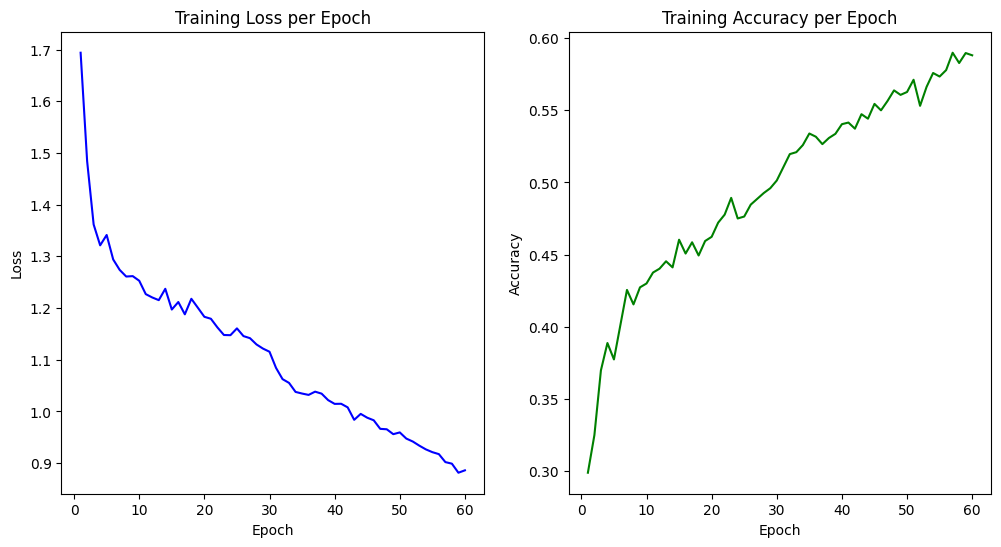

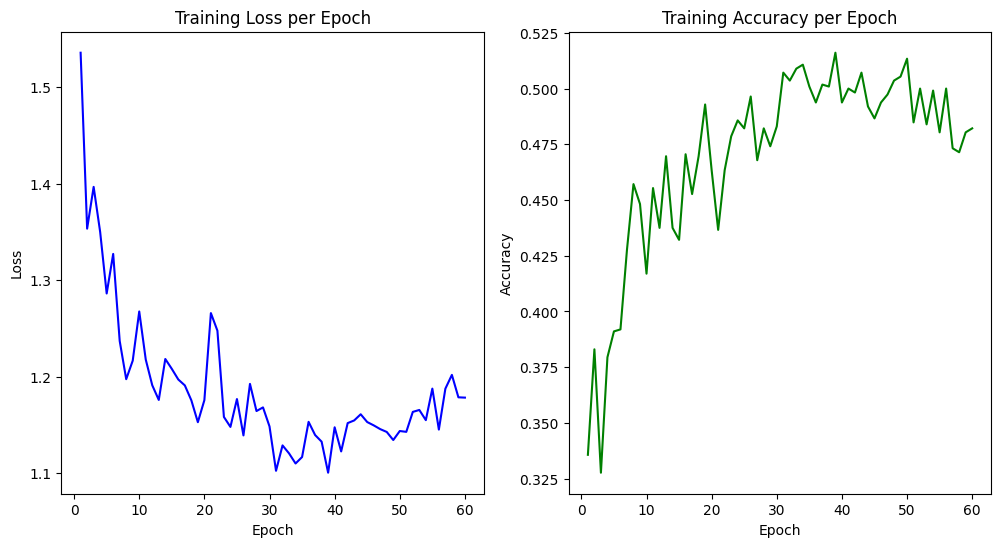

In [57]:
plot_training_progress(train_losses, train_accuracies, os.path.join(logs_folder, "plots"))
plot_training_progress(val_losses, val_accuracies, os.path.join(logs_folder, "plotsVal"))

In [54]:
checkpoint_file = f"model_B_epoch_60.pth"
torch.save(model.state_dict(), checkpoint_file)
print(f"Checkpoint saved at {checkpoint_file}")

Checkpoint saved at model_B_epoch_60.pth


для C

In [68]:
model = GNN(
    gnn_type='gin',
    num_class=6,
    num_layer=args.num_layer,
    emb_dim=args.emb_dim,
    drop_ratio=0.2,
    virtual_node=True,
    # num_graph_features=7,
    residual=True,
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

criterion = GeneralizedCrossEntropyLoss()

num_epochs = args.epochs
best_val_accuracy = 0.0   

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

if num_checkpoints > 1:
    checkpoint_intervals = [int((i + 1) * num_epochs / num_checkpoints) for i in range(num_checkpoints)]
else:
    checkpoint_intervals = [num_epochs]

for epoch in range(num_epochs):
    train_loss, train_acc = train(
        train_loader,
        model,
        optimizer,
        criterion,
        device,
        save_checkpoints=False,
        checkpoint_path=os.path.join(checkpoints_folder, f"model_{test_dir_name}"),
        current_epoch=epoch
    )

    val_loss,val_acc = evaluate(val_loader, model, device, criterion=criterion, calculate_accuracy=True)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
    logging.info(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

Iterating eval graphs: 100%|██████████| 48/48 [00:06<00:00,  7.13batch/s]
Epoch 1/30, Loss: 1.4110, Train Acc: 0.4113, Val Acc: 0.4199
Epoch 1/30, Loss: 1.4110, Train Acc: 0.4113, Val Acc: 0.4199


Epoch 1/30, Loss: 1.4110, Train Acc: 0.4113, Val Acc: 0.4199


Iterating eval graphs: 100%|██████████| 48/48 [00:06<00:00,  7.01batch/s]
Epoch 2/30, Loss: 1.1435, Train Acc: 0.4725, Val Acc: 0.5469
Epoch 2/30, Loss: 1.1435, Train Acc: 0.4725, Val Acc: 0.5469


Epoch 2/30, Loss: 1.1435, Train Acc: 0.4725, Val Acc: 0.5469


Iterating eval graphs: 100%|██████████| 48/48 [00:06<00:00,  7.15batch/s]
Epoch 3/30, Loss: 1.0814, Train Acc: 0.4951, Val Acc: 0.5033
Epoch 3/30, Loss: 1.0814, Train Acc: 0.4951, Val Acc: 0.5033


Epoch 3/30, Loss: 1.0814, Train Acc: 0.4951, Val Acc: 0.5033


Iterating eval graphs: 100%|██████████| 48/48 [00:06<00:00,  7.25batch/s]
Epoch 4/30, Loss: 1.0388, Train Acc: 0.5171, Val Acc: 0.4414
Epoch 4/30, Loss: 1.0388, Train Acc: 0.5171, Val Acc: 0.4414


Epoch 4/30, Loss: 1.0388, Train Acc: 0.5171, Val Acc: 0.4414


Iterating eval graphs: 100%|██████████| 48/48 [00:06<00:00,  7.14batch/s]
Epoch 5/30, Loss: 1.0271, Train Acc: 0.5273, Val Acc: 0.5592
Epoch 5/30, Loss: 1.0271, Train Acc: 0.5273, Val Acc: 0.5592


Epoch 5/30, Loss: 1.0271, Train Acc: 0.5273, Val Acc: 0.5592


Iterating eval graphs: 100%|██████████| 48/48 [00:06<00:00,  6.97batch/s]
Epoch 6/30, Loss: 0.9846, Train Acc: 0.5413, Val Acc: 0.5827
Epoch 6/30, Loss: 0.9846, Train Acc: 0.5413, Val Acc: 0.5827


Epoch 6/30, Loss: 0.9846, Train Acc: 0.5413, Val Acc: 0.5827


Iterating eval graphs: 100%|██████████| 48/48 [00:06<00:00,  7.13batch/s]
Epoch 7/30, Loss: 0.9392, Train Acc: 0.5480, Val Acc: 0.5768
Epoch 7/30, Loss: 0.9392, Train Acc: 0.5480, Val Acc: 0.5768


Epoch 7/30, Loss: 0.9392, Train Acc: 0.5480, Val Acc: 0.5768


Iterating eval graphs: 100%|██████████| 48/48 [00:06<00:00,  7.21batch/s]
Epoch 8/30, Loss: 0.9087, Train Acc: 0.5615, Val Acc: 0.5326
Epoch 8/30, Loss: 0.9087, Train Acc: 0.5615, Val Acc: 0.5326


Epoch 8/30, Loss: 0.9087, Train Acc: 0.5615, Val Acc: 0.5326


Iterating eval graphs: 100%|██████████| 48/48 [00:06<00:00,  7.14batch/s]
Epoch 9/30, Loss: 0.9018, Train Acc: 0.5710, Val Acc: 0.5924
Epoch 9/30, Loss: 0.9018, Train Acc: 0.5710, Val Acc: 0.5924


Epoch 9/30, Loss: 0.9018, Train Acc: 0.5710, Val Acc: 0.5924


Iterating eval graphs: 100%|██████████| 48/48 [00:06<00:00,  7.23batch/s]
Epoch 10/30, Loss: 0.8760, Train Acc: 0.5859, Val Acc: 0.4382
Epoch 10/30, Loss: 0.8760, Train Acc: 0.5859, Val Acc: 0.4382


Epoch 10/30, Loss: 0.8760, Train Acc: 0.5859, Val Acc: 0.4382


Iterating eval graphs: 100%|██████████| 48/48 [00:06<00:00,  6.99batch/s]
Epoch 11/30, Loss: 0.8675, Train Acc: 0.5861, Val Acc: 0.6133
Epoch 11/30, Loss: 0.8675, Train Acc: 0.5861, Val Acc: 0.6133


Epoch 11/30, Loss: 0.8675, Train Acc: 0.5861, Val Acc: 0.6133


Iterating eval graphs: 100%|██████████| 48/48 [00:06<00:00,  7.24batch/s]
Epoch 12/30, Loss: 0.8529, Train Acc: 0.5921, Val Acc: 0.6289
Epoch 12/30, Loss: 0.8529, Train Acc: 0.5921, Val Acc: 0.6289


Epoch 12/30, Loss: 0.8529, Train Acc: 0.5921, Val Acc: 0.6289


Iterating eval graphs: 100%|██████████| 48/48 [00:06<00:00,  6.90batch/s]
Epoch 13/30, Loss: 0.8221, Train Acc: 0.6050, Val Acc: 0.6178
Epoch 13/30, Loss: 0.8221, Train Acc: 0.6050, Val Acc: 0.6178


Epoch 13/30, Loss: 0.8221, Train Acc: 0.6050, Val Acc: 0.6178


Iterating eval graphs: 100%|██████████| 48/48 [00:06<00:00,  7.17batch/s]
Epoch 14/30, Loss: 0.8279, Train Acc: 0.6019, Val Acc: 0.6068
Epoch 14/30, Loss: 0.8279, Train Acc: 0.6019, Val Acc: 0.6068


Epoch 14/30, Loss: 0.8279, Train Acc: 0.6019, Val Acc: 0.6068


Iterating eval graphs: 100%|██████████| 48/48 [00:06<00:00,  7.15batch/s]
Epoch 15/30, Loss: 0.8018, Train Acc: 0.6146, Val Acc: 0.6152
Epoch 15/30, Loss: 0.8018, Train Acc: 0.6146, Val Acc: 0.6152


Epoch 15/30, Loss: 0.8018, Train Acc: 0.6146, Val Acc: 0.6152


Iterating eval graphs: 100%|██████████| 48/48 [00:06<00:00,  6.87batch/s]
Epoch 16/30, Loss: 0.7908, Train Acc: 0.6291, Val Acc: 0.6191
Epoch 16/30, Loss: 0.7908, Train Acc: 0.6291, Val Acc: 0.6191


Epoch 16/30, Loss: 0.7908, Train Acc: 0.6291, Val Acc: 0.6191


Iterating eval graphs: 100%|██████████| 48/48 [00:06<00:00,  6.88batch/s]
Epoch 17/30, Loss: 0.7711, Train Acc: 0.6221, Val Acc: 0.6335
Epoch 17/30, Loss: 0.7711, Train Acc: 0.6221, Val Acc: 0.6335


Epoch 17/30, Loss: 0.7711, Train Acc: 0.6221, Val Acc: 0.6335


Iterating eval graphs: 100%|██████████| 48/48 [00:06<00:00,  7.21batch/s]
Epoch 18/30, Loss: 0.7485, Train Acc: 0.6427, Val Acc: 0.5977
Epoch 18/30, Loss: 0.7485, Train Acc: 0.6427, Val Acc: 0.5977


Epoch 18/30, Loss: 0.7485, Train Acc: 0.6427, Val Acc: 0.5977


Iterating eval graphs: 100%|██████████| 48/48 [00:06<00:00,  7.16batch/s]
Epoch 19/30, Loss: 0.7635, Train Acc: 0.6354, Val Acc: 0.6380
Epoch 19/30, Loss: 0.7635, Train Acc: 0.6354, Val Acc: 0.6380


Epoch 19/30, Loss: 0.7635, Train Acc: 0.6354, Val Acc: 0.6380


Iterating eval graphs: 100%|██████████| 48/48 [00:06<00:00,  7.16batch/s]
Epoch 20/30, Loss: 0.7265, Train Acc: 0.6502, Val Acc: 0.6341
Epoch 20/30, Loss: 0.7265, Train Acc: 0.6502, Val Acc: 0.6341


Epoch 20/30, Loss: 0.7265, Train Acc: 0.6502, Val Acc: 0.6341


Iterating eval graphs: 100%|██████████| 48/48 [00:06<00:00,  7.16batch/s]
Epoch 21/30, Loss: 0.7330, Train Acc: 0.6471, Val Acc: 0.6732
Epoch 21/30, Loss: 0.7330, Train Acc: 0.6471, Val Acc: 0.6732


Epoch 21/30, Loss: 0.7330, Train Acc: 0.6471, Val Acc: 0.6732


Iterating eval graphs: 100%|██████████| 48/48 [00:06<00:00,  7.24batch/s]
Epoch 22/30, Loss: 0.7162, Train Acc: 0.6584, Val Acc: 0.6712
Epoch 22/30, Loss: 0.7162, Train Acc: 0.6584, Val Acc: 0.6712


Epoch 22/30, Loss: 0.7162, Train Acc: 0.6584, Val Acc: 0.6712


Iterating eval graphs: 100%|██████████| 48/48 [00:06<00:00,  7.16batch/s]
Epoch 23/30, Loss: 0.7052, Train Acc: 0.6587, Val Acc: 0.6589
Epoch 23/30, Loss: 0.7052, Train Acc: 0.6587, Val Acc: 0.6589


Epoch 23/30, Loss: 0.7052, Train Acc: 0.6587, Val Acc: 0.6589


Iterating eval graphs: 100%|██████████| 48/48 [00:06<00:00,  7.13batch/s]
Epoch 24/30, Loss: 0.7120, Train Acc: 0.6608, Val Acc: 0.6816
Epoch 24/30, Loss: 0.7120, Train Acc: 0.6608, Val Acc: 0.6816


Epoch 24/30, Loss: 0.7120, Train Acc: 0.6608, Val Acc: 0.6816


Iterating eval graphs: 100%|██████████| 48/48 [00:06<00:00,  7.19batch/s]
Epoch 25/30, Loss: 0.6782, Train Acc: 0.6755, Val Acc: 0.6582
Epoch 25/30, Loss: 0.6782, Train Acc: 0.6755, Val Acc: 0.6582


Epoch 25/30, Loss: 0.6782, Train Acc: 0.6755, Val Acc: 0.6582


Iterating eval graphs: 100%|██████████| 48/48 [00:06<00:00,  7.25batch/s]
Epoch 26/30, Loss: 0.6792, Train Acc: 0.6740, Val Acc: 0.6595
Epoch 26/30, Loss: 0.6792, Train Acc: 0.6740, Val Acc: 0.6595


Epoch 26/30, Loss: 0.6792, Train Acc: 0.6740, Val Acc: 0.6595


Iterating eval graphs: 100%|██████████| 48/48 [00:06<00:00,  7.20batch/s]
Epoch 27/30, Loss: 0.6690, Train Acc: 0.6820, Val Acc: 0.6621
Epoch 27/30, Loss: 0.6690, Train Acc: 0.6820, Val Acc: 0.6621


Epoch 27/30, Loss: 0.6690, Train Acc: 0.6820, Val Acc: 0.6621


Iterating eval graphs: 100%|██████████| 48/48 [00:06<00:00,  7.18batch/s]
Epoch 28/30, Loss: 0.6663, Train Acc: 0.6805, Val Acc: 0.6855
Epoch 28/30, Loss: 0.6663, Train Acc: 0.6805, Val Acc: 0.6855


Epoch 28/30, Loss: 0.6663, Train Acc: 0.6805, Val Acc: 0.6855


Iterating eval graphs: 100%|██████████| 48/48 [00:06<00:00,  7.17batch/s]
Epoch 29/30, Loss: 0.6571, Train Acc: 0.6816, Val Acc: 0.6484
Epoch 29/30, Loss: 0.6571, Train Acc: 0.6816, Val Acc: 0.6484


Epoch 29/30, Loss: 0.6571, Train Acc: 0.6816, Val Acc: 0.6484


Iterating eval graphs: 100%|██████████| 48/48 [00:06<00:00,  7.27batch/s]
Epoch 30/30, Loss: 0.6467, Train Acc: 0.6847, Val Acc: 0.6315
Epoch 30/30, Loss: 0.6467, Train Acc: 0.6847, Val Acc: 0.6315


Epoch 30/30, Loss: 0.6467, Train Acc: 0.6847, Val Acc: 0.6315


In [69]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
for epoch in range(30, 30 + num_epochs):
    train_loss, train_acc = train(
        train_loader,
        model,
        optimizer,
        criterion,
        device,
        save_checkpoints=False,
        checkpoint_path=os.path.join(checkpoints_folder, f"model_{test_dir_name}"),
        current_epoch=epoch
    )

    val_loss,val_acc = evaluate(val_loader, model, device, criterion=criterion, calculate_accuracy=True)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
    logging.info(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

Iterating eval graphs: 100%|██████████| 48/48 [00:06<00:00,  7.17batch/s]
Epoch 31/30, Loss: 0.5909, Train Acc: 0.7122, Val Acc: 0.7181
Epoch 31/30, Loss: 0.5909, Train Acc: 0.7122, Val Acc: 0.7181


Epoch 31/30, Loss: 0.5909, Train Acc: 0.7122, Val Acc: 0.7181


Iterating eval graphs: 100%|██████████| 48/48 [00:06<00:00,  7.22batch/s]
Epoch 32/30, Loss: 0.5680, Train Acc: 0.7264, Val Acc: 0.7064
Epoch 32/30, Loss: 0.5680, Train Acc: 0.7264, Val Acc: 0.7064


Epoch 32/30, Loss: 0.5680, Train Acc: 0.7264, Val Acc: 0.7064


Iterating eval graphs: 100%|██████████| 48/48 [00:06<00:00,  7.17batch/s]
Epoch 33/30, Loss: 0.5555, Train Acc: 0.7327, Val Acc: 0.6862
Epoch 33/30, Loss: 0.5555, Train Acc: 0.7327, Val Acc: 0.6862


Epoch 33/30, Loss: 0.5555, Train Acc: 0.7327, Val Acc: 0.6862


Iterating eval graphs: 100%|██████████| 48/48 [00:06<00:00,  7.00batch/s]
Epoch 34/30, Loss: 0.5553, Train Acc: 0.7334, Val Acc: 0.7181
Epoch 34/30, Loss: 0.5553, Train Acc: 0.7334, Val Acc: 0.7181


Epoch 34/30, Loss: 0.5553, Train Acc: 0.7334, Val Acc: 0.7181


Iterating eval graphs: 100%|██████████| 48/48 [00:06<00:00,  6.92batch/s]
Epoch 35/30, Loss: 0.5515, Train Acc: 0.7354, Val Acc: 0.7233
Epoch 35/30, Loss: 0.5515, Train Acc: 0.7354, Val Acc: 0.7233


Epoch 35/30, Loss: 0.5515, Train Acc: 0.7354, Val Acc: 0.7233


Iterating eval graphs: 100%|██████████| 48/48 [00:06<00:00,  7.21batch/s]
Epoch 36/30, Loss: 0.5319, Train Acc: 0.7428, Val Acc: 0.7155
Epoch 36/30, Loss: 0.5319, Train Acc: 0.7428, Val Acc: 0.7155


Epoch 36/30, Loss: 0.5319, Train Acc: 0.7428, Val Acc: 0.7155


Iterating eval graphs: 100%|██████████| 48/48 [00:06<00:00,  7.14batch/s]
Epoch 37/30, Loss: 0.5247, Train Acc: 0.7451, Val Acc: 0.7188
Epoch 37/30, Loss: 0.5247, Train Acc: 0.7451, Val Acc: 0.7188


Epoch 37/30, Loss: 0.5247, Train Acc: 0.7451, Val Acc: 0.7188


Iterating eval graphs: 100%|██████████| 48/48 [00:06<00:00,  7.24batch/s]
Epoch 38/30, Loss: 0.5219, Train Acc: 0.7487, Val Acc: 0.6953
Epoch 38/30, Loss: 0.5219, Train Acc: 0.7487, Val Acc: 0.6953


Epoch 38/30, Loss: 0.5219, Train Acc: 0.7487, Val Acc: 0.6953


Iterating eval graphs: 100%|██████████| 48/48 [00:06<00:00,  6.91batch/s]
Epoch 39/30, Loss: 0.5197, Train Acc: 0.7472, Val Acc: 0.7259
Epoch 39/30, Loss: 0.5197, Train Acc: 0.7472, Val Acc: 0.7259


Epoch 39/30, Loss: 0.5197, Train Acc: 0.7472, Val Acc: 0.7259


Iterating eval graphs: 100%|██████████| 48/48 [00:06<00:00,  7.20batch/s]
Epoch 40/30, Loss: 0.5065, Train Acc: 0.7554, Val Acc: 0.6966
Epoch 40/30, Loss: 0.5065, Train Acc: 0.7554, Val Acc: 0.6966


Epoch 40/30, Loss: 0.5065, Train Acc: 0.7554, Val Acc: 0.6966


Iterating eval graphs: 100%|██████████| 48/48 [00:06<00:00,  7.14batch/s]
Epoch 41/30, Loss: 0.5119, Train Acc: 0.7492, Val Acc: 0.6960
Epoch 41/30, Loss: 0.5119, Train Acc: 0.7492, Val Acc: 0.6960


Epoch 41/30, Loss: 0.5119, Train Acc: 0.7492, Val Acc: 0.6960


Iterating eval graphs: 100%|██████████| 48/48 [00:06<00:00,  7.19batch/s]
Epoch 42/30, Loss: 0.4913, Train Acc: 0.7591, Val Acc: 0.7253
Epoch 42/30, Loss: 0.4913, Train Acc: 0.7591, Val Acc: 0.7253


Epoch 42/30, Loss: 0.4913, Train Acc: 0.7591, Val Acc: 0.7253


Iterating eval graphs: 100%|██████████| 48/48 [00:06<00:00,  7.11batch/s]
Epoch 43/30, Loss: 0.5024, Train Acc: 0.7505, Val Acc: 0.7214
Epoch 43/30, Loss: 0.5024, Train Acc: 0.7505, Val Acc: 0.7214


Epoch 43/30, Loss: 0.5024, Train Acc: 0.7505, Val Acc: 0.7214


Iterating eval graphs: 100%|██████████| 48/48 [00:06<00:00,  7.18batch/s]
Epoch 44/30, Loss: 0.4789, Train Acc: 0.7627, Val Acc: 0.7161
Epoch 44/30, Loss: 0.4789, Train Acc: 0.7627, Val Acc: 0.7161


Epoch 44/30, Loss: 0.4789, Train Acc: 0.7627, Val Acc: 0.7161


Iterating eval graphs: 100%|██████████| 48/48 [00:06<00:00,  7.11batch/s]
Epoch 45/30, Loss: 0.4642, Train Acc: 0.7728, Val Acc: 0.7155
Epoch 45/30, Loss: 0.4642, Train Acc: 0.7728, Val Acc: 0.7155


Epoch 45/30, Loss: 0.4642, Train Acc: 0.7728, Val Acc: 0.7155


Iterating eval graphs: 100%|██████████| 48/48 [00:06<00:00,  6.92batch/s]
Epoch 46/30, Loss: 0.4746, Train Acc: 0.7692, Val Acc: 0.6849
Epoch 46/30, Loss: 0.4746, Train Acc: 0.7692, Val Acc: 0.6849


Epoch 46/30, Loss: 0.4746, Train Acc: 0.7692, Val Acc: 0.6849


Iterating eval graphs: 100%|██████████| 48/48 [00:06<00:00,  7.20batch/s]
Epoch 47/30, Loss: 0.4715, Train Acc: 0.7666, Val Acc: 0.7142
Epoch 47/30, Loss: 0.4715, Train Acc: 0.7666, Val Acc: 0.7142


Epoch 47/30, Loss: 0.4715, Train Acc: 0.7666, Val Acc: 0.7142


Iterating eval graphs: 100%|██████████| 48/48 [00:06<00:00,  7.17batch/s]
Epoch 48/30, Loss: 0.4668, Train Acc: 0.7676, Val Acc: 0.7285
Epoch 48/30, Loss: 0.4668, Train Acc: 0.7676, Val Acc: 0.7285


Epoch 48/30, Loss: 0.4668, Train Acc: 0.7676, Val Acc: 0.7285


Iterating eval graphs: 100%|██████████| 48/48 [00:06<00:00,  7.19batch/s]
Epoch 49/30, Loss: 0.4545, Train Acc: 0.7705, Val Acc: 0.7090
Epoch 49/30, Loss: 0.4545, Train Acc: 0.7705, Val Acc: 0.7090


Epoch 49/30, Loss: 0.4545, Train Acc: 0.7705, Val Acc: 0.7090


Iterating eval graphs: 100%|██████████| 48/48 [00:06<00:00,  6.95batch/s]
Epoch 50/30, Loss: 0.4539, Train Acc: 0.7769, Val Acc: 0.7350
Epoch 50/30, Loss: 0.4539, Train Acc: 0.7769, Val Acc: 0.7350


Epoch 50/30, Loss: 0.4539, Train Acc: 0.7769, Val Acc: 0.7350


Iterating eval graphs: 100%|██████████| 48/48 [00:06<00:00,  7.25batch/s]
Epoch 51/30, Loss: 0.4542, Train Acc: 0.7773, Val Acc: 0.7344
Epoch 51/30, Loss: 0.4542, Train Acc: 0.7773, Val Acc: 0.7344


Epoch 51/30, Loss: 0.4542, Train Acc: 0.7773, Val Acc: 0.7344


Iterating eval graphs: 100%|██████████| 48/48 [00:06<00:00,  7.15batch/s]
Epoch 52/30, Loss: 0.4443, Train Acc: 0.7806, Val Acc: 0.7109
Epoch 52/30, Loss: 0.4443, Train Acc: 0.7806, Val Acc: 0.7109


Epoch 52/30, Loss: 0.4443, Train Acc: 0.7806, Val Acc: 0.7109


Iterating eval graphs: 100%|██████████| 48/48 [00:06<00:00,  6.90batch/s]
Epoch 53/30, Loss: 0.4461, Train Acc: 0.7791, Val Acc: 0.7370
Epoch 53/30, Loss: 0.4461, Train Acc: 0.7791, Val Acc: 0.7370


Epoch 53/30, Loss: 0.4461, Train Acc: 0.7791, Val Acc: 0.7370


Iterating eval graphs: 100%|██████████| 48/48 [00:06<00:00,  7.11batch/s]
Epoch 54/30, Loss: 0.4329, Train Acc: 0.7861, Val Acc: 0.7031
Epoch 54/30, Loss: 0.4329, Train Acc: 0.7861, Val Acc: 0.7031


Epoch 54/30, Loss: 0.4329, Train Acc: 0.7861, Val Acc: 0.7031


Iterating eval graphs: 100%|██████████| 48/48 [00:06<00:00,  7.18batch/s]
Epoch 55/30, Loss: 0.4281, Train Acc: 0.7881, Val Acc: 0.7025
Epoch 55/30, Loss: 0.4281, Train Acc: 0.7881, Val Acc: 0.7025


Epoch 55/30, Loss: 0.4281, Train Acc: 0.7881, Val Acc: 0.7025


Iterating eval graphs: 100%|██████████| 48/48 [00:06<00:00,  7.12batch/s]
Epoch 56/30, Loss: 0.4223, Train Acc: 0.7970, Val Acc: 0.7227
Epoch 56/30, Loss: 0.4223, Train Acc: 0.7970, Val Acc: 0.7227


Epoch 56/30, Loss: 0.4223, Train Acc: 0.7970, Val Acc: 0.7227


Iterating eval graphs: 100%|██████████| 48/48 [00:07<00:00,  6.85batch/s]
Epoch 57/30, Loss: 0.4188, Train Acc: 0.7918, Val Acc: 0.7324
Epoch 57/30, Loss: 0.4188, Train Acc: 0.7918, Val Acc: 0.7324


Epoch 57/30, Loss: 0.4188, Train Acc: 0.7918, Val Acc: 0.7324


Iterating eval graphs: 100%|██████████| 48/48 [00:06<00:00,  7.11batch/s]
Epoch 58/30, Loss: 0.4035, Train Acc: 0.7987, Val Acc: 0.7129
Epoch 58/30, Loss: 0.4035, Train Acc: 0.7987, Val Acc: 0.7129


Epoch 58/30, Loss: 0.4035, Train Acc: 0.7987, Val Acc: 0.7129


Iterating eval graphs: 100%|██████████| 48/48 [00:06<00:00,  7.16batch/s]
Epoch 59/30, Loss: 0.4000, Train Acc: 0.8079, Val Acc: 0.6986
Epoch 59/30, Loss: 0.4000, Train Acc: 0.8079, Val Acc: 0.6986


Epoch 59/30, Loss: 0.4000, Train Acc: 0.8079, Val Acc: 0.6986


Iterating eval graphs: 100%|██████████| 48/48 [00:06<00:00,  7.15batch/s]
Epoch 60/30, Loss: 0.3917, Train Acc: 0.8092, Val Acc: 0.7155
Epoch 60/30, Loss: 0.3917, Train Acc: 0.8092, Val Acc: 0.7155


Epoch 60/30, Loss: 0.3917, Train Acc: 0.8092, Val Acc: 0.7155


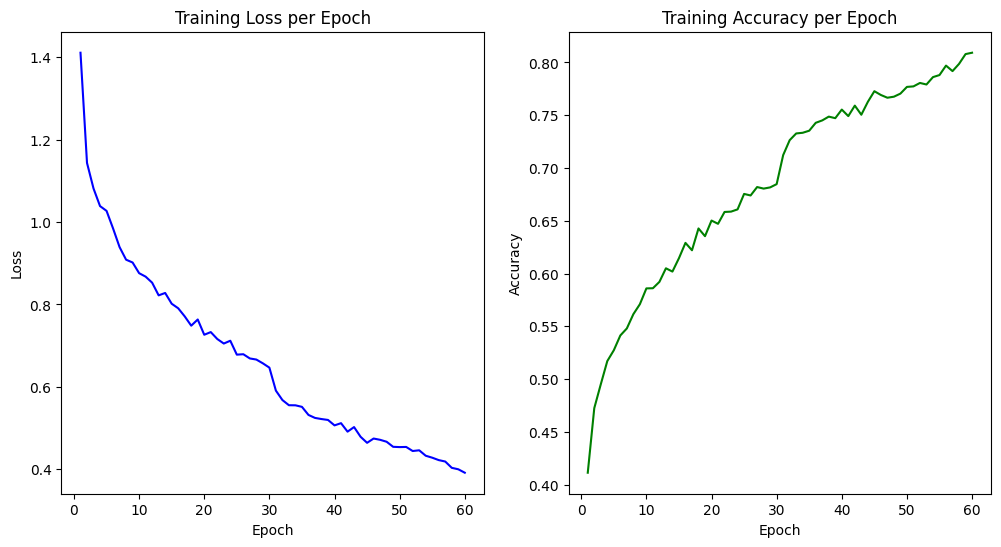

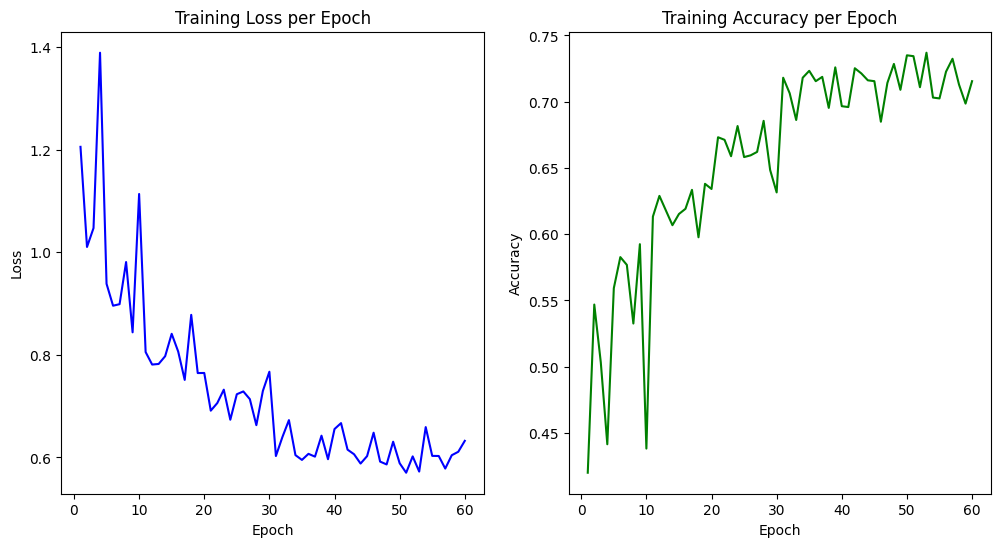

In [70]:
plot_training_progress(train_losses, train_accuracies, os.path.join(logs_folder, "plots"))
plot_training_progress(val_losses, val_accuracies, os.path.join(logs_folder, "plotsVal"))

In [71]:
checkpoint_file = f"model_C_epoch_60.pth"
torch.save(model.state_dict(), checkpoint_file)
print(f"Checkpoint saved at {checkpoint_file}")

Checkpoint saved at model_C_epoch_60.pth


для D

In [93]:
model = GNN(
    gnn_type='gin',
    num_class=6,
    num_layer=args.num_layer,
    emb_dim=args.emb_dim,
    drop_ratio=0.2,
    virtual_node=True,
    # num_graph_features=7,
    residual=True,
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

criterion = GeneralizedCrossEntropyLoss()

num_epochs = args.epochs
best_val_accuracy = 0.0   

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

if num_checkpoints > 1:
    checkpoint_intervals = [int((i + 1) * num_epochs / num_checkpoints) for i in range(num_checkpoints)]
else:
    checkpoint_intervals = [num_epochs]

for epoch in range(num_epochs):
    train_loss, train_acc = train(
        train_loader,
        model,
        optimizer,
        criterion,
        device,
        save_checkpoints=False,
        checkpoint_path=os.path.join(checkpoints_folder, f"model_{test_dir_name}"),
        current_epoch=epoch
    )

    val_loss,val_acc = evaluate(val_loader, model, device, criterion=criterion, calculate_accuracy=True)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss:.4f}, Val loss: {val_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
    # logging.info(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

Iterating eval graphs: 100%|██████████| 65/65 [00:09<00:00,  6.75batch/s]


Epoch 1/30, Loss: 1.4381, Val loss: 1.0923, Train Acc: 0.3667, Val Acc: 0.4572


Iterating eval graphs: 100%|██████████| 65/65 [00:09<00:00,  6.88batch/s]


Epoch 2/30, Loss: 1.1196, Val loss: 1.0525, Train Acc: 0.4492, Val Acc: 0.4791


Iterating eval graphs: 100%|██████████| 65/65 [00:09<00:00,  6.88batch/s]


Epoch 3/30, Loss: 1.0479, Val loss: 1.0542, Train Acc: 0.4692, Val Acc: 0.4601


Iterating eval graphs: 100%|██████████| 65/65 [00:09<00:00,  6.87batch/s]


Epoch 4/30, Loss: 0.9884, Val loss: 0.9567, Train Acc: 0.4903, Val Acc: 0.5302


Iterating eval graphs: 100%|██████████| 65/65 [00:09<00:00,  6.72batch/s]


Epoch 5/30, Loss: 0.9605, Val loss: 0.8677, Train Acc: 0.4955, Val Acc: 0.5073


Iterating eval graphs: 100%|██████████| 65/65 [00:09<00:00,  6.87batch/s]


Epoch 6/30, Loss: 0.9102, Val loss: 0.8959, Train Acc: 0.5248, Val Acc: 0.5277


Iterating eval graphs: 100%|██████████| 65/65 [00:09<00:00,  6.87batch/s]


Epoch 7/30, Loss: 0.8942, Val loss: 0.8883, Train Acc: 0.5231, Val Acc: 0.5321


Iterating eval graphs: 100%|██████████| 65/65 [00:09<00:00,  6.84batch/s]


Epoch 8/30, Loss: 0.8551, Val loss: 0.9180, Train Acc: 0.5365, Val Acc: 0.5039


Iterating eval graphs: 100%|██████████| 65/65 [00:09<00:00,  6.64batch/s]


Epoch 9/30, Loss: 0.8483, Val loss: 0.8380, Train Acc: 0.5392, Val Acc: 0.5199


Iterating eval graphs: 100%|██████████| 65/65 [00:09<00:00,  6.73batch/s]


Epoch 10/30, Loss: 0.8172, Val loss: 0.7525, Train Acc: 0.5601, Val Acc: 0.5579


Iterating eval graphs: 100%|██████████| 65/65 [00:09<00:00,  6.88batch/s]


Epoch 11/30, Loss: 0.7918, Val loss: 0.8040, Train Acc: 0.5680, Val Acc: 0.5773


Iterating eval graphs: 100%|██████████| 65/65 [00:09<00:00,  6.89batch/s]


Epoch 12/30, Loss: 0.7740, Val loss: 0.7530, Train Acc: 0.5779, Val Acc: 0.6021


Iterating eval graphs: 100%|██████████| 65/65 [00:09<00:00,  6.84batch/s]


Epoch 13/30, Loss: 0.7555, Val loss: 0.7503, Train Acc: 0.5796, Val Acc: 0.6012


Iterating eval graphs: 100%|██████████| 65/65 [00:09<00:00,  6.73batch/s]


Epoch 14/30, Loss: 0.7351, Val loss: 0.6981, Train Acc: 0.5929, Val Acc: 0.6109


Iterating eval graphs: 100%|██████████| 65/65 [00:09<00:00,  6.86batch/s]


Epoch 15/30, Loss: 0.7272, Val loss: 0.8637, Train Acc: 0.5944, Val Acc: 0.5253


Iterating eval graphs: 100%|██████████| 65/65 [00:09<00:00,  6.84batch/s]


Epoch 16/30, Loss: 0.7205, Val loss: 0.7480, Train Acc: 0.5947, Val Acc: 0.5603


Iterating eval graphs: 100%|██████████| 65/65 [00:09<00:00,  6.85batch/s]


Epoch 17/30, Loss: 0.7031, Val loss: 0.6931, Train Acc: 0.6037, Val Acc: 0.6133


Iterating eval graphs: 100%|██████████| 65/65 [00:09<00:00,  6.70batch/s]


Epoch 18/30, Loss: 0.7039, Val loss: 0.7678, Train Acc: 0.6081, Val Acc: 0.5627


Iterating eval graphs: 100%|██████████| 65/65 [00:09<00:00,  6.89batch/s]


Epoch 19/30, Loss: 0.6805, Val loss: 0.6935, Train Acc: 0.6153, Val Acc: 0.6094


Iterating eval graphs: 100%|██████████| 65/65 [00:09<00:00,  6.89batch/s]


Epoch 20/30, Loss: 0.6728, Val loss: 0.6488, Train Acc: 0.6229, Val Acc: 0.6445


Iterating eval graphs: 100%|██████████| 65/65 [00:09<00:00,  6.86batch/s]


Epoch 21/30, Loss: 0.6589, Val loss: 0.7184, Train Acc: 0.6306, Val Acc: 0.6075


Iterating eval graphs: 100%|██████████| 65/65 [00:09<00:00,  6.82batch/s]


Epoch 22/30, Loss: 0.6500, Val loss: 0.6699, Train Acc: 0.6334, Val Acc: 0.6265


Iterating eval graphs: 100%|██████████| 65/65 [00:09<00:00,  6.88batch/s]


Epoch 23/30, Loss: 0.6444, Val loss: 0.7233, Train Acc: 0.6396, Val Acc: 0.5807


Iterating eval graphs: 100%|██████████| 65/65 [00:09<00:00,  6.86batch/s]


Epoch 24/30, Loss: 0.6302, Val loss: 0.6424, Train Acc: 0.6426, Val Acc: 0.6094


Iterating eval graphs: 100%|██████████| 65/65 [00:09<00:00,  6.90batch/s]


Epoch 25/30, Loss: 0.6233, Val loss: 0.6700, Train Acc: 0.6464, Val Acc: 0.6196


Iterating eval graphs: 100%|██████████| 65/65 [00:09<00:00,  6.82batch/s]


Epoch 26/30, Loss: 0.6141, Val loss: 0.6264, Train Acc: 0.6553, Val Acc: 0.6449


Iterating eval graphs: 100%|██████████| 65/65 [00:09<00:00,  6.89batch/s]


Epoch 27/30, Loss: 0.6081, Val loss: 0.6695, Train Acc: 0.6570, Val Acc: 0.6046


Iterating eval graphs: 100%|██████████| 65/65 [00:09<00:00,  6.88batch/s]


Epoch 28/30, Loss: 0.5917, Val loss: 0.6922, Train Acc: 0.6615, Val Acc: 0.5856


Iterating eval graphs: 100%|██████████| 65/65 [00:09<00:00,  6.87batch/s]


Epoch 29/30, Loss: 0.5939, Val loss: 0.6163, Train Acc: 0.6637, Val Acc: 0.6464


Iterating eval graphs: 100%|██████████| 65/65 [00:09<00:00,  6.82batch/s]

Epoch 30/30, Loss: 0.6040, Val loss: 0.6259, Train Acc: 0.6581, Val Acc: 0.6483


In [94]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
for epoch in range(30, 30 + num_epochs):
    train_loss, train_acc = train(
        train_loader,
        model,
        optimizer,
        criterion,
        device,
        save_checkpoints=False,
        checkpoint_path=os.path.join(checkpoints_folder, f"model_{test_dir_name}"),
        current_epoch=epoch
    )

    val_loss,val_acc = evaluate(val_loader, model, device, criterion=criterion, calculate_accuracy=True)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss:.4f}, Val loss: {val_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
    logging.info(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

Iterating eval graphs: 100%|██████████| 65/65 [00:09<00:00,  6.84batch/s]
Epoch 31/30, Loss: 0.5364, Train Acc: 0.6926, Val Acc: 0.6634
Epoch 31/30, Loss: 0.5364, Train Acc: 0.6926, Val Acc: 0.6634


Epoch 31/30, Loss: 0.5364, Val loss: 0.5792, Train Acc: 0.6926, Val Acc: 0.6634


Iterating eval graphs: 100%|██████████| 65/65 [00:09<00:00,  6.91batch/s]
Epoch 32/30, Loss: 0.5268, Train Acc: 0.7008, Val Acc: 0.6595
Epoch 32/30, Loss: 0.5268, Train Acc: 0.7008, Val Acc: 0.6595


Epoch 32/30, Loss: 0.5268, Val loss: 0.5816, Train Acc: 0.7008, Val Acc: 0.6595


Iterating eval graphs: 100%|██████████| 65/65 [00:09<00:00,  6.92batch/s]
Epoch 33/30, Loss: 0.5133, Train Acc: 0.7068, Val Acc: 0.6445
Epoch 33/30, Loss: 0.5133, Train Acc: 0.7068, Val Acc: 0.6445


Epoch 33/30, Loss: 0.5133, Val loss: 0.6070, Train Acc: 0.7068, Val Acc: 0.6445


Iterating eval graphs: 100%|██████████| 65/65 [00:09<00:00,  6.71batch/s]
Epoch 34/30, Loss: 0.5089, Train Acc: 0.7125, Val Acc: 0.6503
Epoch 34/30, Loss: 0.5089, Train Acc: 0.7125, Val Acc: 0.6503


Epoch 34/30, Loss: 0.5089, Val loss: 0.5881, Train Acc: 0.7125, Val Acc: 0.6503


Iterating eval graphs: 100%|██████████| 65/65 [00:09<00:00,  6.76batch/s]
Epoch 35/30, Loss: 0.4971, Train Acc: 0.7180, Val Acc: 0.6566
Epoch 35/30, Loss: 0.4971, Train Acc: 0.7180, Val Acc: 0.6566


Epoch 35/30, Loss: 0.4971, Val loss: 0.5820, Train Acc: 0.7180, Val Acc: 0.6566


Iterating eval graphs: 100%|██████████| 65/65 [00:09<00:00,  6.92batch/s]
Epoch 36/30, Loss: 0.4972, Train Acc: 0.7212, Val Acc: 0.6581
Epoch 36/30, Loss: 0.4972, Train Acc: 0.7212, Val Acc: 0.6581


Epoch 36/30, Loss: 0.4972, Val loss: 0.5774, Train Acc: 0.7212, Val Acc: 0.6581


Iterating eval graphs: 100%|██████████| 65/65 [00:09<00:00,  6.86batch/s]
Epoch 37/30, Loss: 0.4854, Train Acc: 0.7293, Val Acc: 0.6376
Epoch 37/30, Loss: 0.4854, Train Acc: 0.7293, Val Acc: 0.6376


Epoch 37/30, Loss: 0.4854, Val loss: 0.6135, Train Acc: 0.7293, Val Acc: 0.6376


Iterating eval graphs: 100%|██████████| 65/65 [00:09<00:00,  6.89batch/s]
Epoch 38/30, Loss: 0.4841, Train Acc: 0.7254, Val Acc: 0.6586
Epoch 38/30, Loss: 0.4841, Train Acc: 0.7254, Val Acc: 0.6586


Epoch 38/30, Loss: 0.4841, Val loss: 0.5818, Train Acc: 0.7254, Val Acc: 0.6586


Iterating eval graphs: 100%|██████████| 65/65 [00:09<00:00,  6.71batch/s]
Epoch 39/30, Loss: 0.4845, Train Acc: 0.7310, Val Acc: 0.6581
Epoch 39/30, Loss: 0.4845, Train Acc: 0.7310, Val Acc: 0.6581


Epoch 39/30, Loss: 0.4845, Val loss: 0.5835, Train Acc: 0.7310, Val Acc: 0.6581


Iterating eval graphs: 100%|██████████| 65/65 [00:09<00:00,  6.85batch/s]
Epoch 40/30, Loss: 0.4731, Train Acc: 0.7327, Val Acc: 0.6610
Epoch 40/30, Loss: 0.4731, Train Acc: 0.7327, Val Acc: 0.6610


Epoch 40/30, Loss: 0.4731, Val loss: 0.5719, Train Acc: 0.7327, Val Acc: 0.6610


Iterating eval graphs: 100%|██████████| 65/65 [00:09<00:00,  6.92batch/s]
Epoch 41/30, Loss: 0.4654, Train Acc: 0.7382, Val Acc: 0.6663
Epoch 41/30, Loss: 0.4654, Train Acc: 0.7382, Val Acc: 0.6663


Epoch 41/30, Loss: 0.4654, Val loss: 0.5809, Train Acc: 0.7382, Val Acc: 0.6663


Iterating eval graphs: 100%|██████████| 65/65 [00:09<00:00,  6.88batch/s]
Epoch 42/30, Loss: 0.4702, Train Acc: 0.7363, Val Acc: 0.6542
Epoch 42/30, Loss: 0.4702, Train Acc: 0.7363, Val Acc: 0.6542


Epoch 42/30, Loss: 0.4702, Val loss: 0.5817, Train Acc: 0.7363, Val Acc: 0.6542


Iterating eval graphs: 100%|██████████| 65/65 [00:09<00:00,  6.80batch/s]
Epoch 43/30, Loss: 0.4519, Train Acc: 0.7494, Val Acc: 0.6625
Epoch 43/30, Loss: 0.4519, Train Acc: 0.7494, Val Acc: 0.6625


Epoch 43/30, Loss: 0.4519, Val loss: 0.5773, Train Acc: 0.7494, Val Acc: 0.6625


Iterating eval graphs: 100%|██████████| 65/65 [00:09<00:00,  6.89batch/s]
Epoch 44/30, Loss: 0.4515, Train Acc: 0.7491, Val Acc: 0.6629
Epoch 44/30, Loss: 0.4515, Train Acc: 0.7491, Val Acc: 0.6629


Epoch 44/30, Loss: 0.4515, Val loss: 0.5936, Train Acc: 0.7491, Val Acc: 0.6629


Iterating eval graphs: 100%|██████████| 65/65 [00:09<00:00,  6.90batch/s]
Epoch 45/30, Loss: 0.4485, Train Acc: 0.7477, Val Acc: 0.6839
Epoch 45/30, Loss: 0.4485, Train Acc: 0.7477, Val Acc: 0.6839


Epoch 45/30, Loss: 0.4485, Val loss: 0.5524, Train Acc: 0.7477, Val Acc: 0.6839


Iterating eval graphs: 100%|██████████| 65/65 [00:09<00:00,  6.87batch/s]
Epoch 46/30, Loss: 0.4549, Train Acc: 0.7451, Val Acc: 0.6547
Epoch 46/30, Loss: 0.4549, Train Acc: 0.7451, Val Acc: 0.6547


Epoch 46/30, Loss: 0.4549, Val loss: 0.5907, Train Acc: 0.7451, Val Acc: 0.6547


Iterating eval graphs: 100%|██████████| 65/65 [00:09<00:00,  6.84batch/s]
Epoch 47/30, Loss: 0.4394, Train Acc: 0.7552, Val Acc: 0.6479
Epoch 47/30, Loss: 0.4394, Train Acc: 0.7552, Val Acc: 0.6479


Epoch 47/30, Loss: 0.4394, Val loss: 0.6083, Train Acc: 0.7552, Val Acc: 0.6479


Iterating eval graphs: 100%|██████████| 65/65 [00:09<00:00,  6.87batch/s]
Epoch 48/30, Loss: 0.4357, Train Acc: 0.7557, Val Acc: 0.6707
Epoch 48/30, Loss: 0.4357, Train Acc: 0.7557, Val Acc: 0.6707


Epoch 48/30, Loss: 0.4357, Val loss: 0.5661, Train Acc: 0.7557, Val Acc: 0.6707


Iterating eval graphs: 100%|██████████| 65/65 [00:09<00:00,  6.90batch/s]
Epoch 49/30, Loss: 0.4337, Train Acc: 0.7571, Val Acc: 0.6610
Epoch 49/30, Loss: 0.4337, Train Acc: 0.7571, Val Acc: 0.6610


Epoch 49/30, Loss: 0.4337, Val loss: 0.5969, Train Acc: 0.7571, Val Acc: 0.6610


Iterating eval graphs: 100%|██████████| 65/65 [00:09<00:00,  6.90batch/s]
Epoch 50/30, Loss: 0.4266, Train Acc: 0.7622, Val Acc: 0.6722
Epoch 50/30, Loss: 0.4266, Train Acc: 0.7622, Val Acc: 0.6722


Epoch 50/30, Loss: 0.4266, Val loss: 0.6012, Train Acc: 0.7622, Val Acc: 0.6722


Iterating eval graphs: 100%|██████████| 65/65 [00:09<00:00,  6.81batch/s]
Epoch 51/30, Loss: 0.4235, Train Acc: 0.7667, Val Acc: 0.6634
Epoch 51/30, Loss: 0.4235, Train Acc: 0.7667, Val Acc: 0.6634


Epoch 51/30, Loss: 0.4235, Val loss: 0.5988, Train Acc: 0.7667, Val Acc: 0.6634


Iterating eval graphs: 100%|██████████| 65/65 [00:09<00:00,  6.88batch/s]
Epoch 52/30, Loss: 0.4251, Train Acc: 0.7636, Val Acc: 0.6600
Epoch 52/30, Loss: 0.4251, Train Acc: 0.7636, Val Acc: 0.6600


Epoch 52/30, Loss: 0.4251, Val loss: 0.5951, Train Acc: 0.7636, Val Acc: 0.6600


Iterating eval graphs: 100%|██████████| 65/65 [00:09<00:00,  6.86batch/s]
Epoch 53/30, Loss: 0.4159, Train Acc: 0.7709, Val Acc: 0.6649
Epoch 53/30, Loss: 0.4159, Train Acc: 0.7709, Val Acc: 0.6649


Epoch 53/30, Loss: 0.4159, Val loss: 0.5916, Train Acc: 0.7709, Val Acc: 0.6649


Iterating eval graphs: 100%|██████████| 65/65 [00:09<00:00,  6.76batch/s]
Epoch 54/30, Loss: 0.4145, Train Acc: 0.7727, Val Acc: 0.6600
Epoch 54/30, Loss: 0.4145, Train Acc: 0.7727, Val Acc: 0.6600


Epoch 54/30, Loss: 0.4145, Val loss: 0.5972, Train Acc: 0.7727, Val Acc: 0.6600


Iterating eval graphs: 100%|██████████| 65/65 [00:09<00:00,  6.80batch/s]
Epoch 55/30, Loss: 0.4030, Train Acc: 0.7759, Val Acc: 0.6513
Epoch 55/30, Loss: 0.4030, Train Acc: 0.7759, Val Acc: 0.6513


Epoch 55/30, Loss: 0.4030, Val loss: 0.6272, Train Acc: 0.7759, Val Acc: 0.6513


Iterating eval graphs: 100%|██████████| 65/65 [00:09<00:00,  6.80batch/s]
Epoch 56/30, Loss: 0.3974, Train Acc: 0.7776, Val Acc: 0.6299
Epoch 56/30, Loss: 0.3974, Train Acc: 0.7776, Val Acc: 0.6299


Epoch 56/30, Loss: 0.3974, Val loss: 0.6591, Train Acc: 0.7776, Val Acc: 0.6299


Iterating eval graphs: 100%|██████████| 65/65 [00:09<00:00,  6.89batch/s]
Epoch 57/30, Loss: 0.3858, Train Acc: 0.7861, Val Acc: 0.6746
Epoch 57/30, Loss: 0.3858, Train Acc: 0.7861, Val Acc: 0.6746


Epoch 57/30, Loss: 0.3858, Val loss: 0.5871, Train Acc: 0.7861, Val Acc: 0.6746


Iterating eval graphs: 100%|██████████| 65/65 [00:09<00:00,  6.88batch/s]
Epoch 58/30, Loss: 0.3863, Train Acc: 0.7825, Val Acc: 0.6751
Epoch 58/30, Loss: 0.3863, Train Acc: 0.7825, Val Acc: 0.6751


Epoch 58/30, Loss: 0.3863, Val loss: 0.5794, Train Acc: 0.7825, Val Acc: 0.6751


Iterating eval graphs: 100%|██████████| 65/65 [00:09<00:00,  6.68batch/s]
Epoch 59/30, Loss: 0.3906, Train Acc: 0.7827, Val Acc: 0.6449
Epoch 59/30, Loss: 0.3906, Train Acc: 0.7827, Val Acc: 0.6449


Epoch 59/30, Loss: 0.3906, Val loss: 0.6480, Train Acc: 0.7827, Val Acc: 0.6449


Iterating eval graphs: 100%|██████████| 65/65 [00:09<00:00,  6.76batch/s]
Epoch 60/30, Loss: 0.3854, Train Acc: 0.7860, Val Acc: 0.6717
Epoch 60/30, Loss: 0.3854, Train Acc: 0.7860, Val Acc: 0.6717


Epoch 60/30, Loss: 0.3854, Val loss: 0.5877, Train Acc: 0.7860, Val Acc: 0.6717


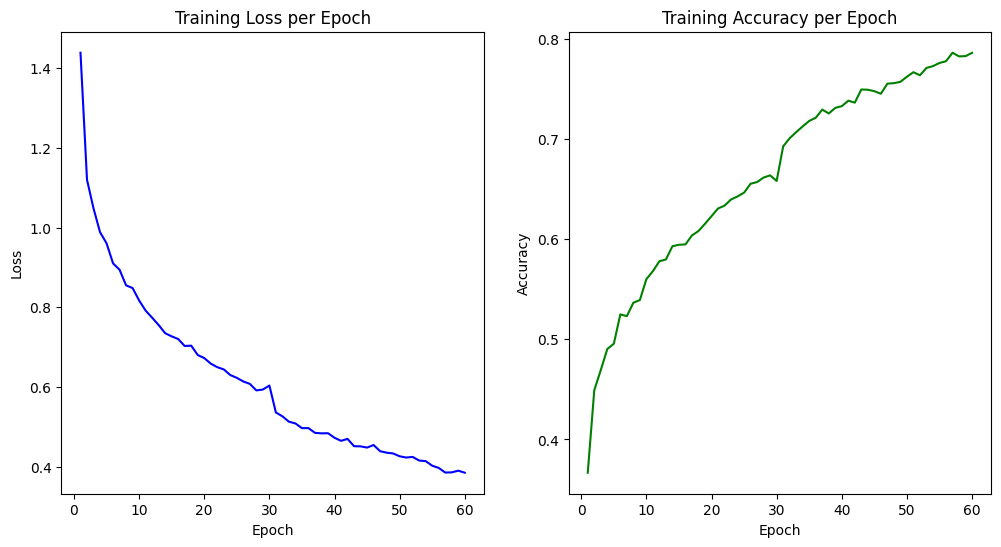

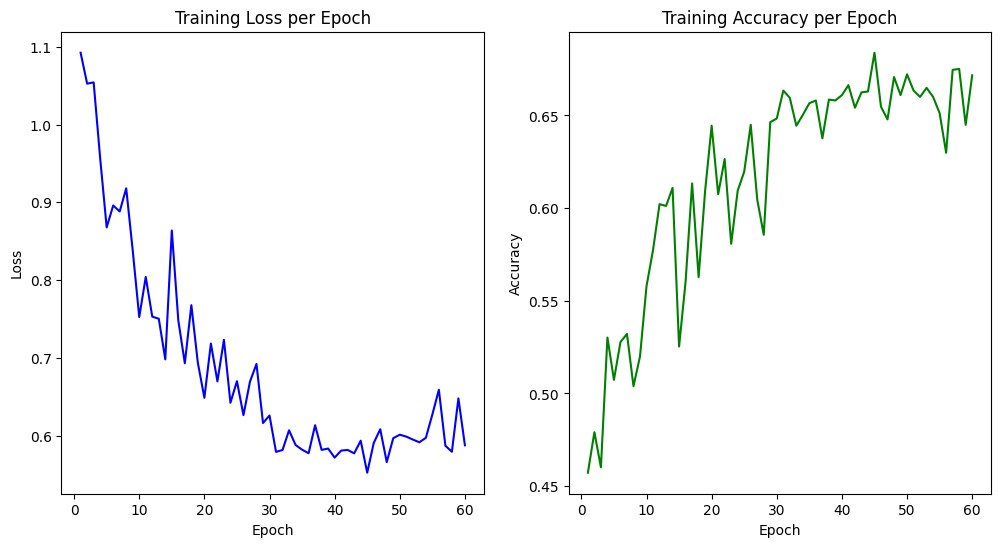

In [95]:
plot_training_progress(train_losses, train_accuracies, os.path.join(logs_folder, "plots"))
plot_training_progress(val_losses, val_accuracies, os.path.join(logs_folder, "plotsVal"))

In [96]:
checkpoint_file = f"model_D_epoch_60.pth"
torch.save(model.state_dict(), checkpoint_file)
print(f"Checkpoint saved at {checkpoint_file}")

Checkpoint saved at model_D_epoch_60.pth


# Что можно попробовать

- обучаться дольше (так как на трейне не происходит насыщение?)

- 
- уменьшить lr
- подобрать параметр лосса
- подобрать dropout
- посмотреть вообще на распределения классов
- поменять graph_pooling на attention / set2set (легко?)
- gcn (?)
- residual (легко)

- emb_dim сделать делимыми на 2?

Посложнее
- ELR
- NCOD
- focal-loss
- symmetrical CE
- добавить grapth_features
- weight decay
- gradient clipping
- уменьшать lr

---

# Уменьшила модельку
не прорыв :(

In [ ]:
model = GNN(
    gnn_type='gin',
    num_class=6,
    num_layer=3,
    emb_dim=args.emb_dim,
    drop_ratio=0.2,
    virtual_node=True,
    # num_graph_features=7,
    residual=True,
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

criterion = GeneralizedCrossEntropyLoss()

num_epochs = args.epochs
best_val_accuracy = 0.0   

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

if num_checkpoints > 1:
    checkpoint_intervals = [int((i + 1) * num_epochs / num_checkpoints) for i in range(num_checkpoints)]
else:
    checkpoint_intervals = [num_epochs]

for epoch in range(num_epochs):
    train_loss, train_acc = train(
        train_loader,
        model,
        optimizer,
        criterion,
        device,
        save_checkpoints=False,
        checkpoint_path=os.path.join(checkpoints_folder, f"model_{test_dir_name}"),
        current_epoch=epoch
    )

    val_loss,val_acc = evaluate(val_loader, model, device, criterion=criterion, calculate_accuracy=True)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss:.4f}, Val loss: {val_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
    # logging.info(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

## attention 

In [ ]:
model = GNN(
    gnn_type='gin',
    num_class=6,
    num_layer=args.num_layer,
    emb_dim=args.emb_dim,
    drop_ratio=0.2,
    virtual_node=True,
    # num_graph_features=7,
    residual=True,
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

criterion = GeneralizedCrossEntropyLoss(0.5)

num_epochs = args.epochs
best_val_accuracy = 0.0   

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

if num_checkpoints > 1:
    checkpoint_intervals = [int((i + 1) * num_epochs / num_checkpoints) for i in range(num_checkpoints)]
else:
    checkpoint_intervals = [num_epochs]

for epoch in range(num_epochs):
    train_loss, train_acc = train(
        train_loader,
        model,
        optimizer,
        criterion,
        device,
        save_checkpoints=False,
        checkpoint_path=os.path.join(checkpoints_folder, f"model_{test_dir_name}"),
        current_epoch=epoch
    )

    val_loss,val_acc = evaluate(val_loader, model, device, criterion=criterion, calculate_accuracy=True)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss:.4f}, Val loss: {val_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
    # logging.info(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

In [ ]:
if args.train_path:
    full_dataset = GraphDataset(args.train_path, transform=add_zeros)
    val_size = int(0.2 * len(full_dataset))
    train_size = len(full_dataset) - val_size

    
    generator = torch.Generator().manual_seed(12)
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size], generator=generator)

    train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=args.batch_size, shuffle=False)

    num_epochs = args.epochs
    best_val_accuracy = 0.0   

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    if num_checkpoints > 1:
        checkpoint_intervals = [int((i + 1) * num_epochs / num_checkpoints) for i in range(num_checkpoints)]
    else:
        checkpoint_intervals = [num_epochs]

    for epoch in range(num_epochs):
        train_loss, train_acc = train(
            train_loader, model, optimizer, criterion, device,
            save_checkpoints=(epoch + 1 in checkpoint_intervals),
            checkpoint_path=os.path.join(checkpoints_folder, f"model_{test_dir_name}"),
            current_epoch=epoch
        )

        val_loss,val_acc = evaluate(val_loader, model, device, calculate_accuracy=True)

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
        logging.info(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        
        if val_acc > best_val_accuracy:
            best_val_accuracy = val_acc
            torch.save(model.state_dict(), checkpoint_path)
            print(f"Best model updated and saved at {checkpoint_path}")

    plot_training_progress(train_losses, train_accuracies, os.path.join(logs_folder, "plots"))
    plot_training_progress(val_losses, val_accuracies, os.path.join(logs_folder, "plotsVal"))

In [97]:
import gc
del train_dataset
del train_loader
del full_dataset
del val_dataset
del val_loader

# del test_dataset
# del test_loader

gc.collect()

12990

In [98]:
args.test_path

'datasets/D/test.json.gz'

In [99]:
test_dataset = GraphDataset(args.test_path)
test_loader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False)
    

In [59]:
def save_predictions(predictions, dataset_name, folder):
    script_dir = os.getcwd() 
    submission_folder = os.path.join(script_dir, folder, "submission")    
    os.makedirs(submission_folder, exist_ok=True)
    
    output_csv_path = os.path.join(submission_folder, f"testset_{dataset_name}.csv")
    
    test_graph_ids = list(range(len(predictions)))
    output_df = pd.DataFrame({
        "id": test_graph_ids,
        "pred": predictions
    })
    
    output_df.to_csv(output_csv_path, index=False)
    print(f"Predictions saved to {output_csv_path}")

In [100]:
# model.load_state_dict(torch.load("/kaggle/input/gin_with_features/pytorch/a_epoch55/1/model_A_epoch_55.pth"))
predictions = evaluate(test_loader, model, device, calculate_accuracy=False)
save_predictions(predictions, dataset_name="D", folder="first")

Iterating eval graphs: 100%|██████████| 71/71 [00:09<00:00,  7.13batch/s]

Predictions saved to /kaggle/working/hackaton/hackaton/first/submission/testset_D.csv


In [81]:
from IPython.display import FileLink
FileLink('first/submission/testset_C.csv')

/kaggle/working/hackaton/hackaton/first/submission/testset_C.csv

In [102]:
! pwd

/kaggle/working/hackaton/hackaton


In [101]:
import tarfile
import os

In [103]:


def gzip_folder(folder_path, output_file):
    """
    Compresses an entire folder into a single .tar.gz file.
    
    Args:
        folder_path (str): Path to the folder to compress.
        output_file (str): Path to the output .tar.gz file.
    """
    with tarfile.open(output_file, "w:gz") as tar:
        tar.add(folder_path, arcname=os.path.basename(folder_path))
    print(f"Folder '{folder_path}' has been compressed into '{output_file}'")

# Example usage
folder_path = "./first/submission"            # Path to the folder you want to compress
output_file = "./first/submission.gz"         # Output .gz file name
gzip_folder(folder_path, output_file)

Folder './first/submission' has been compressed into './first/submission.gz'
